In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from absl import app
from absl import flags

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from os.path import join, exists, splitext, basename
from os import mkdir, listdir
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
from glob import glob
import shutil

import seaborn as sns

from src.vit_slide.train import *
from src.vit_slide.layers import *
from src.vit_slide.model import *
from time import time

import tensorflow as tf
# tf.compat.v1.flags.DEFINE_string('f','','')

flags.FLAGS([''])

2024-04-25 22:52:32.222029: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 22:52:32.920174: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


['']

# Test preloaded model

In [19]:
import tensorflow_hub as hub

In [12]:
model_url = "https://www.kaggle.com/models/spsayakpaul/vision-transformer/frameworks/TensorFlow2/variations/vit-b8-fe/versions/1"

vit_model = hub.KerasLayer(model_url, trainable=True)

input_tokens = tf.keras.Input(shape=(224, 224, 3))

x = input_tokens
# for layer in vit_model.layers[1:-1]:  # Adjust indices according to the actual model structure
output = vit_model(x)

# Create the new model
new_model = tf.keras.Model(inputs=input_tokens, outputs=output)

2023-12-13 03:24:18,709 Unable to load fingerprint when loading saved model.
Traceback (most recent call last):
  File "/opt/tensorflow/lib/python3.10/site-packages/tensorflow/python/saved_model/load.py", line 1015, in load_partial
    fingerprint = fingerprinting.read_fingerprint(export_dir)
  File "/opt/tensorflow/lib/python3.10/site-packages/tensorflow/python/saved_model/fingerprinting.py", line 172, in read_fingerprint
    raise FileNotFoundError(f"SavedModel Fingerprint Error: {e}") from None  # pylint: disable=raise-missing-from
FileNotFoundError: SavedModel Fingerprint Error: Could not read fingerprint from directory: /tmp/tfhub_modules/3cb144d42e5407a1b800e38e30e7cc9e3ab66e97


# Pre processing

In [2]:
import random
import hashlib
from src.vit_slide.data_prep import *

def file_hash(filepath):
    """Compute hash of a file."""
    hash_func = hashlib.sha256()  # Using SHA256 hash function
    with open(filepath, "rb") as file:
        for chunk in iter(lambda: file.read(4096), b""):
            hash_func.update(chunk)
    return hash_func.hexdigest()

In [3]:
hipt = False
npzdir = join(RESOURCE_DIR, "PRS_data_256_sm")
npzdir += "_hipt" if hipt else ""

rawdir = join(npzdir, "raw")
testdir = join(npzdir, "test")

print(f"{len(glob(join(rawdir, '*.npz')))} Raw files in {rawdir}")

1039 Raw files in /home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/raw


In [4]:
num_files = len(glob(join(rawdir, '*.npz')))

while num_files < 1039:
    print("waiting to check again", end="\t")
    time.sleep(5 * 60)
    num_files = len(glob(join(rawdir, '*.npz')))
    print(f"{num_files} saved")

In [5]:
np.load(glob(join(rawdir, '*.npz'))[0], allow_pickle=True)['feature_0'].shape

(144, 175, 128)

## max_dim

20.0 43
40.0 44


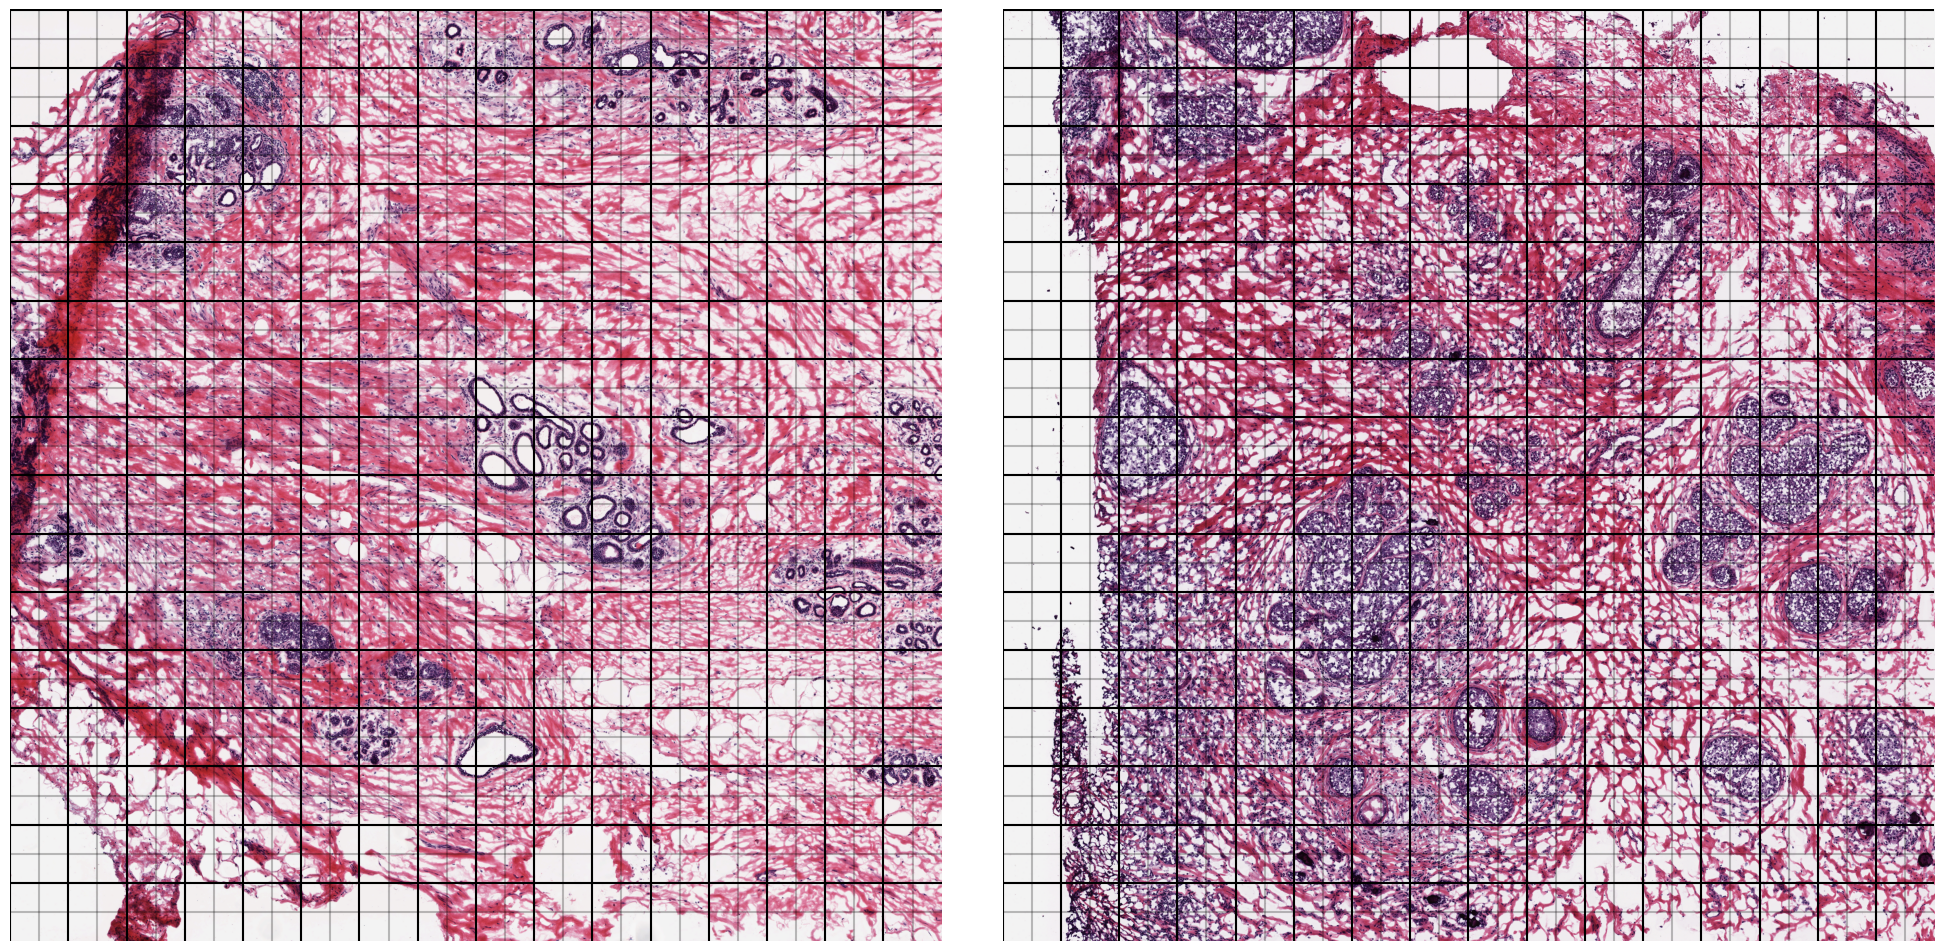

In [26]:
# Define the function to add gridlines
def add_gridlines(axis, image_shape, tile_size=128):
    for x in range(0, image_shape[0], tile_size):
        axis.axvline(x, color='k', linestyle='-', alpha=0.25)
    for y in range(0, image_shape[1], tile_size):
        axis.axhline(y, color='k', linestyle='-', alpha=0.25)
    tile_size = tile_size * 2
    for x in range(0, image_shape[0], tile_size):
        axis.axvline(x, color='k', linestyle='-')
    for y in range(0, image_shape[1], tile_size):
        axis.axhline(y, color='k', linestyle='-')

MAXDIM = 32

f, ax = plt.subplots(1, 2, figsize=(20, 10))

i = 43
test_file = np.load(join(RESOURCE_DIR, "svs_files.npy"))[i]
slideObj = OpenSlide(test_file)
slide_mag = float(slideObj.properties["aperio.AppMag"].replace(",", "."))
print(slide_mag, i)

in_s = 256 * MAXDIM
test_im_1 = slideObj.read_region((4500, 5500), 0, (in_s, in_s)).convert('RGB')
test_im_1 = test_im_1.resize((test_im_1.size[0] // 2, test_im_1.size[1] // 2))
ax[0].imshow(test_im_1)
add_gridlines(ax[0], test_im_1.size)

i = 44
test_file = np.load(join(RESOURCE_DIR, "svs_files.npy"))[i]
slideObj = OpenSlide(test_file)
slide_mag = float(slideObj.properties["aperio.AppMag"].replace(",", "."))
print(slide_mag, i)

in_s = 256 * MAXDIM * 2
test_im = slideObj.read_region((3500, 6500), 0, (in_s, in_s)).convert('RGB')
test_im = test_im.resize((test_im_1.size[0], test_im_1.size[1]))
ax[1].imshow(test_im)
add_gridlines(ax[1], test_im.size)

plt.tight_layout()
for i in range(2):
    ax[i].axis("off")

## shapes

In [27]:
train_npzfiles = glob(join(rawdir, "*.npz"))
print("Processing files...")

max_rows = 0
max_cols = 0
for idx, f in enumerate(train_npzfiles):
    data = np.load(f, allow_pickle=True)
    n_feat = len([key for key in data if "feature_" in key])
    
    for i in range(n_feat):
        feat_i = data[f"feature_{i}"]
        
        rows_to_keep = np.any(feat_i != 0, axis=(1, 2))
        cols_to_keep = np.any(feat_i != 0, axis=(0, 2))

        tensor_rows_masked = feat_i[rows_to_keep, :, :]
        tensor_cols_masked = tensor_rows_masked[:, cols_to_keep, :]
        
        rows, cols = tensor_cols_masked.shape[:2]
        
        if rows > max_rows:
            max_rows = rows
        if cols > max_cols:
            max_cols = cols
print(max_rows, max_cols)
        

Processing files...
284 247


## fixing feature splits

In [24]:
data_dir = join(RESOURCE_DIR, "PRS_data_256")
# os.makedirs(data_dir, exist_ok=True)

file_path = join(data_dir, 'PRS_2_sample_data.pkl')
with open(file_path, 'rb') as f:
    results = pickle.load(f)
    
patient_df = SLIDES_PRS_DATA_2
patient_ids = patient_df.patient.unique()

patient_slide_paths = SLIDES_PRS_2
patient_slides = [splitext(basename(f))[0] for f in patient_slide_paths]

In [33]:
raw_npzfiles = glob(join(rawdir, "*.npz"))
total_files = len(raw_npzfiles)

# singlefile = [join(npzdir, "raw", "TCGA-E2-A155.npz")]

In [34]:
for idx, filename in enumerate(raw_npzfiles):
    patient_id = os.path.splitext(os.path.basename(filename))[0]
    print(idx, patient_id)

    data = np.load(filename, allow_pickle=True)
    n_feat = len([key for key in data if "feature_" in key])
    
    slides = list(patient_df.loc[patient_df.patient == patient_id].slide)
    patient_features = []
    patient_files = []
    
    for i, slide in enumerate(slides):    
        slide_idx = patient_slides.index(slide)
        mask, coords, fg_scale, crop_size = results[slide_idx]
        features_mask = create_mask(coords, crop_size, filter_regions=False)
        svs_file = patient_slide_paths[slide_idx]
    
        features = data[f"feature_{i}"]           
        positive_region = np.any(features !=0, axis=-1).sum()   
        region_areas = [int(region.area) for region in regionprops(features_mask)]

        if positive_region < len(coords) or (len(region_areas) == 1 and region_areas[0] == positive_region):
            continue
        print(patient_slides[slide_idx])
        print("coords shape:", coords.shape)
        print("feature shape:", features.shape, positive_region)  
        print("region areas:", region_areas, sum(region_areas))

        features = features[np.any(features != 0, axis=-1)]
        padded_features = pad_and_split_features(features_mask, features)
        print("region shapes:", [p.shape for p in padded_features])
        for split in padded_features:
            if min(split.shape[:2]) >= 15 and max(split.shape[:2]) >= 21:
                patient_features.append(split)
                patient_files.append(svs_file)
        
    feats_updated = [f for f in patient_features if np.any(np.array(f.shape[:2]) >= 3)]
    patient_files_updated = [pf for f, pf in zip(patient_features, patient_files) if np.any(np.array(f.shape[:2]) >= 3)]
    
#     if len(feats_updated) > 0:
#         print("updated regions:", [p.shape for p in feats_updated])
#         print()
        
#         data_dict = {key: data[key] for key in data if "feature" not in key and "patient_files" not in key}
#         data_dict['patient_files'] = patient_files_updated
#         for idx, feature in enumerate(feats_updated):
#             data_dict[f'feature_{idx}'] = feature
#         np.savez_compressed(filename, **data_dict)

0 TCGA-E2-A155
coords shape: (17907, 2)
feature shape: (129, 227, 384) 17553
region areas: [17553, 354] 17907


In [147]:
1

1

## normalizing and updating soft values

In [7]:
df = pd.concat([SLIDES_PRS_DATA, SLIDES_PRS_DATA_2], ignore_index=True).loc[:, ["patient", "slide", "odx_train", "odx85"]]
# cutoff = df.loc[df.odx85 == "H"].odx_train.min()
# min_score = df.loc[df.odx85 == "L"].odx_train.min()
# max_score = df.loc[df.odx85 == "H"].odx_train.max()

def convert_to_soft_label(score, beta=1.50):
    cutoff = 0.7169
    min_score = -2.009
    max_score = 2.744
    if score <= cutoff:
        soft_label = (score - min_score) / (cutoff - min_score)
        return 0.50 * soft_label ** beta
    else:
        soft_label = (score - cutoff) / (max_score - cutoff) 
        return 1 - 0.50 * (1 - soft_label) ** beta
    return soft_label


def lookup_soft_label(patient):
    risk_score = df.loc[df.patient == patient].odx_train.max()
    return convert_to_soft_label(risk_score, beta=2.0)

### calculating mean, std

In [8]:
from multiprocessing import Pool, cpu_count
from time import time

D = 128
random.seed(0)
rawdir = join(npzdir, "raw")

train_npzfiles = glob(join(rawdir, "*.npz"))
subset_size = int(1.0 * len(train_npzfiles))
train_npzfiles = random.sample(train_npzfiles, subset_size)

total_files = len(train_npzfiles)
five_percent_increment = total_files // 10  # 5% of total files

def process_file(f):
    data = np.load(f, allow_pickle=True)
    n_feat = len([key for key in data if "feature_" in key])
    features = np.concatenate([data[f"feature_{i}"].reshape([-1, D]) for i in range(n_feat)], axis=0)
    features = features[(features != 0).any(axis=1)]

    count = features.shape[0]
    mean = np.mean(features, axis=0)
    M2 = np.sum((features - mean) ** 2, axis=0)
    return count, mean, M2

def parallel_feature_processing(npz_files, pool_size=cpu_count()):
    with Pool(pool_size) as pool:
        stats = pool.map(process_file, npz_files)
    pool.join()
    pool.close()
    return stats

def aggregate_stats(stats):
    total_count = sum(count for count, _, _ in stats)
    global_mean = sum(mean * count for count, mean, _ in stats) / total_count

    sum_of_squares_global = sum(sum_of_squares + count * (mean - global_mean) ** 2 for count, mean, sum_of_squares in stats)
    global_variance = sum_of_squares_global / total_count
    global_stddev = np.sqrt(global_variance)

    return global_mean, global_stddev

start_time = time()
print("Processing files...", end="\t")
all_stats = parallel_feature_processing(train_npzfiles)
feats_avg, feats_std = aggregate_stats(all_stats)
print(f"{time() - start_time:.1f} s")

np.save(join(npzdir, "features_avg.npy"), feats_avg)
np.save(join(npzdir, "features_std.npy"), feats_std)

Processing files...	7.5 s


### mean, std normalizing

In [9]:
npzdir

'/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm'

In [10]:
if os.path.exists(join(npzdir, "normalized_all")):
    shutil.rmtree(join(npzdir, "normalized_all"))
    os.makedirs(join(npzdir, "normalized_all"))
    
feats_avg = np.load(join(npzdir, "features_avg.npy"))
feats_std = np.load(join(npzdir, "features_std.npy"))

train_npzfiles = glob(join(rawdir, "*.npz"))
total_files = len(train_npzfiles)

do_normalization = True

def normalize_and_save_npz(file_path, npzdir, feats_avg, feats_std):
    data = np.load(file_path, allow_pickle=True)
    data_dict = {key: data[key] for key in data}

    patient_name = basename(file_path).split(".")[0]
    soft_label = lookup_soft_label(patient_name)
    data_dict["soft"] = soft_label

    for key in data:
        if key.startswith("feature_"):
            if do_normalization:
                features = data[key]
                non_zero_mask = features.any(axis=-1, keepdims=True)
                normalized_features = np.where(non_zero_mask, (features - feats_avg) / feats_std, features)
                data_dict[key] = normalized_features
            else:
                data_dict[key] = data[key]
             

    filename = basename(file_path)
    normalized_filepath = join(npzdir, "normalized_all", filename)
    os.makedirs(os.path.dirname(normalized_filepath), exist_ok=True)
    np.savez_compressed(normalized_filepath, **data_dict)

def parallel_process(files, npzdir, feats_avg, feats_std):
    with Pool(cpu_count()) as pool:
        pool.starmap(normalize_and_save_npz, [(f, npzdir, feats_avg, feats_std) for f in files])
    
parallel_process(train_npzfiles, npzdir, feats_avg, feats_std)

## Splitting test set

### test files

In [11]:
random.seed(0)
patients = list(SLIDES_PRS_DATA.patient.unique())

num_to_select = int(len(patients) * 0.2)
print(f"number of test files: {num_to_select}")

test_files = random.sample(patients, num_to_select)
count = 0
for test_file in test_files:
    npzfile = join(rawdir, test_file + ".npz")
    if exists(npzfile):
        print(f"{count}\t{npzfile}")
        count += 1

number of test files: 100
0	/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/raw/TCGA-E9-A3QA.npz
1	/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/raw/TCGA-AR-A1AQ.npz
2	/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/raw/TCGA-E2-A1B5.npz
3	/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/raw/TCGA-GI-A2C8.npz
4	/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/raw/TCGA-AR-A2LL.npz
5	/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/raw/TCGA-A2-A0CQ.npz
6	/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/raw/TCGA-AC-A3YJ.npz
7	/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/raw/TCGA-S3-A6ZF.npz
8	/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/raw/TCGA-BH-A0DK.npz
9	/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/raw/TCGA-BH-A0B6.npz
10	/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/raw/TCGA-AR-A24S.npz
11	/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/raw/TCGA-LL-A440.npz


In [12]:
# random.seed(0)
# patients = list(SLIDES_PRS_DATA.patient.unique())

# num_to_select = int(len(patients) * 0.2)
# print(f"number of test files: {num_to_select}")

# test_files = random.sample(patients, num_to_select)
# count = 0
# for test_file in test_files:
#     npzfile = join(rawdir, test_file + ".npz")
#     if exists(npzfile):
#         print(f"{count}\t{npzfile}")
#         count += 1

### Move Folders

In [13]:
subdirs = ["train", "test"]

for subdir in subdirs:
    dir_path = join(npzdir, subdir)
    print(dir_path)
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path, exist_ok=True)

/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/train
/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/test


In [14]:
from multiprocessing import Pool, cpu_count

normfiles = glob(join(npzdir, "normalized_all", "*.npz"))
# normfiles = glob(join(rawdir, "*.npz"))

def process_normalized_file(nf):
    patient_name = basename(nf).split(".")[0]
    subdir = "test" if patient_name in test_files else "train"
    os.makedirs(join(npzdir, subdir), exist_ok=True)

    newfile = join(npzdir, subdir, patient_name + ".npz")
    shutil.copy(nf, newfile)
    
num_processes = cpu_count()
with Pool(num_processes) as p:
    p.map(process_normalized_file, normfiles)

## Prepping for Dataset Construction

### stacking features in npz

In [15]:
import numpy as np
from os.path import join
from glob import glob
from multiprocessing import Pool, cpu_count

def process_files_pad(file_path):
    data = np.load(file_path, allow_pickle=True)
    
    if "feature_0" in data:
        # Extract all features and find max dimensions
        features = [data[key] for key in data if "feature_" in key]
        h_max = max(feat.shape[0] for feat in features)
        w_max = max(feat.shape[1] for feat in features)

        # Pad each feature to the max dimensions and stack
        features = [np.pad(feat, ((0, h_max - feat.shape[0]), (0, w_max - feat.shape[1]), (0, 0)), mode='constant', constant_values=0) for feat in features]
        features = np.stack(features)

        # Create new data dictionary with padded features
        new_data = {key: data[key] for key in data if not key.startswith("feature_")}
        new_data["features"] = features

        float_label = np.float32(data["soft"] >= 0.5)
        new_data["label"] = float_label
        new_data["soft"] = np.float32(data["soft"])

        # Save the processed data back to a compressed npz file
        np.savez_compressed(file_path, **new_data)

files = glob(join(npzdir, "t*", "*.npz"))
num_processes = cpu_count()

with Pool(num_processes) as p:
    p.map(process_files_pad, files)

### Creating TFRecords

In [16]:
subdirs = ["train_tf", "test_tf"]

for subdir in subdirs:
    dir_path = join(npzdir, subdir)
    print(dir_path)
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path, exist_ok=True)

/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/train_tf
/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/test_tf


In [17]:
import tensorflow as tf
import numpy as np
from os.path import join
from glob import glob

def find_bounding_boxes(padded_tensors):
    boxes = []
    for tensor in padded_tensors:
        rows = np.any(tensor != 0, axis=(1, 2))  # Reduce across width and depth
        cols = np.any(tensor != 0, axis=(0, 2))  # Reduce across height and depth

        # Find indices of the first and last non-zero rows and columns
        rows_indices = np.where(rows)[0]
        cols_indices = np.where(cols)[0]
        if len(rows_indices) == 0 or len(cols_indices) == 0:
            boxes.append((0, 0, 0, 0))
            continue

        top_row = rows_indices[0]
        bottom_row = rows_indices[-1]
        left_col = cols_indices[0]
        right_col = cols_indices[-1]

        height = bottom_row - top_row + 1
        width = right_col - left_col + 1
        boxes.append((top_row, left_col, height, width))
    return boxes

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value.reshape(-1)))

def serialize_example(npz_data):
    inputs = npz_data["features"]
    inputs_shape = list(inputs.shape)
    
    bboxes = find_bounding_boxes(inputs)
    bboxes = np.array(bboxes, dtype=np.int64).flatten()

    patient_files_str = '|'.join(npz_data["patient_files"].astype(str))
    patient_files_bytes = patient_files_str.encode('utf-8')

    feature = {
        'inputs': _float_feature(inputs),  # Using float_list for inputs
        'inputs_shape': _int64_feature(inputs_shape),
        'inputs_bboxes': _int64_feature(bboxes),
        'label': _float_feature(npz_data["label"]),  # Using float_list for label
        'soft': _float_feature(npz_data["soft"]),  # Using float_list for label
        'patient_files': _bytes_feature(patient_files_bytes)  # Using bytes_list for patient_files
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [18]:
from concurrent.futures import ProcessPoolExecutor

def process_file(npz_file):
    tfrecord_dir = join(npzdir, "train_tf") if ("train" in npz_file) else join(npzdir, "test_tf")
    tfrecord_file = join(tfrecord_dir, splitext(basename(npz_file))[0] + '.tfrecord')
    npz_data = np.load(npz_file, allow_pickle=True)

    # parsed_example = parse_tfrecord_function(serialize_example(npz_data), load_softlabels=True, return_files=True)
    # print(parsed_example["patient_files"])
    
    with tf.io.TFRecordWriter(tfrecord_file) as writer:
        writer.write(serialize_example(npz_data))

files_to_write = glob(join(npzdir, "t*", "*.npz"))

N = len(files_to_write)
files_to_write = files_to_write[:N]

st_time = time()
max_workers = cpu_count()

with ProcessPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(process_file, npz_file) for npz_file in files_to_write]

    for future in futures:
        future.result()
end_time = time()
print(f"Finished in {end_time - st_time:.2f}s, ({(end_time - st_time) / N:.2f}s per tfrecord)")

Finished in 25.77s, (0.02s per tfrecord)


# Testing Convolution Parameters

In [42]:
RESOURCE_DIR = join(".", "resources")
save_dir = join(RESOURCE_DIR, "PRS_data")
trainpaths = [join(save_dir, "train", f) for f in os.listdir(join(save_dir, "train")) if f.endswith('.npz')]

In [52]:
def load_npz(file_path):
    with np.load(file_path, allow_pickle=True) as f:
        n_feat = len([key for key in f if "feature_" in key])
        features = [f[f"feature_{i}"] for i in range(n_feat)]
        label = int(f['label'].item() == "H")
        patient_files = f['patient_files'].tolist()
    return features, label, patient_files

def collect_sizes(file_path):
    f_list = load_npz(file_path)[0]
    return [np.prod(f.shape[:2]) for f in f_list]

def convolve_3x3_with_stride(input_array, kernel, stride=3):
    # Determine the shape of the output based on the stride
    output_height = (input_array.shape[0] - kernel.shape[0]) // stride + 1
    output_width = (input_array.shape[1] - kernel.shape[1]) // stride + 1
    
    output_array = np.zeros((output_height, output_width))

    for i in range(0, input_array.shape[0] - 2, stride):
        for j in range(0, input_array.shape[1] - 2, stride):
            # Perform convolution for each region
            output_array[i//stride, j//stride] = np.sum(input_array[i:i+3, j:j+3] * kernel)

    return output_array

./resources/PRS_data_256/train/TCGA-EW-A1J6.npz


./resources/PRS_data_256/train/TCGA-EW-A1J6.npz


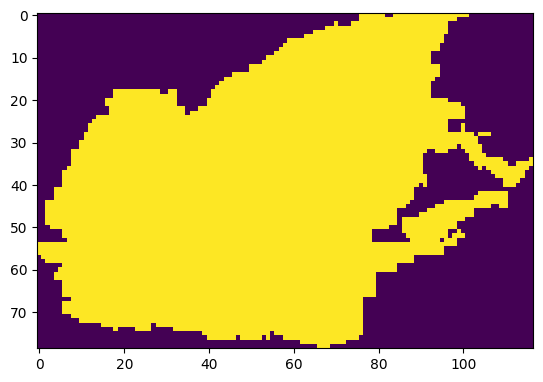

In [53]:
save_dir = join(RESOURCE_DIR, "PRS_data_256")
trainpaths = [join(save_dir, "train", f) for f in os.listdir(join(save_dir, "train")) if f.endswith('.npz')]

test_file = trainpaths[0]
print(test_file)
features, label, patient_files = load_npz(test_file)

test_mask = features[0].any(axis=-1)
plt.imshow(test_mask)

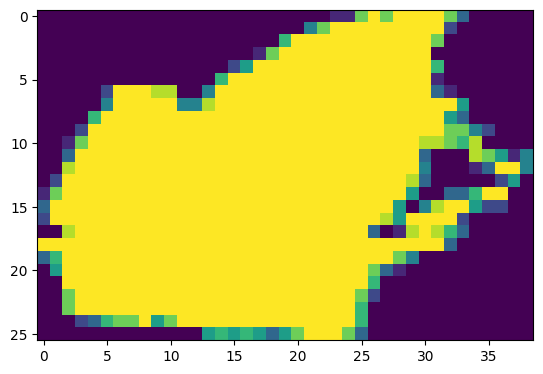

In [38]:
kernel = np.ones((3, 3))
test_mask_conv = convolve_3x3_with_stride(test_mask, kernel)
plt.imshow(test_mask_conv)

In [54]:
save_dir = join(RESOURCE_DIR, "PRS_data")
trainpaths = [join(save_dir, "train", f) for f in os.listdir(join(save_dir, "train")) if f.endswith('.npz')]
sizes = [collect_sizes(f) for f in trainpaths]
sizes = [s for ss in sizes for s in ss]

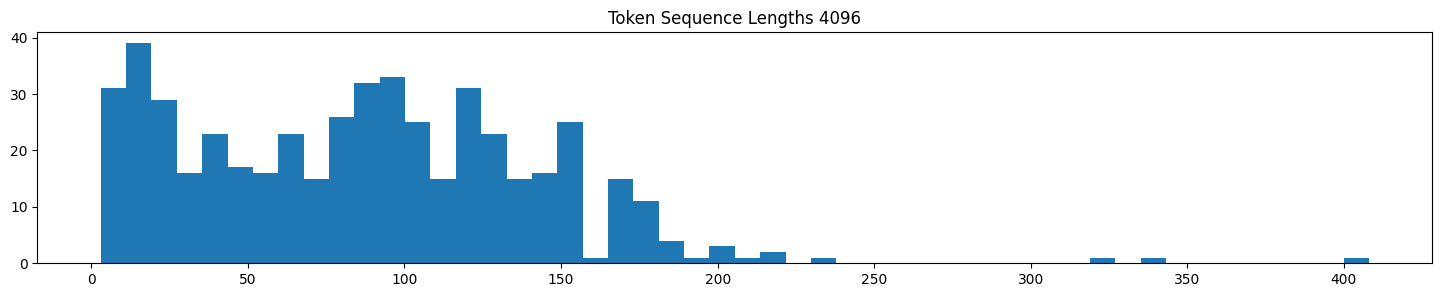

In [55]:
plt.figure(figsize=(18, 3))
plt.hist(sizes, bins=50)
plt.title("Token Sequence Lengths 4096")
plt.show()

In [71]:
def convolve_hw(h, w, kernel_s, times=2):
    for i in range(times):
        h = (h - kernel_s) // kernel_s + 1
        w = (w - kernel_s) // kernel_s + 1
    return h, w

def collect_sizes_conv(file_path, kernel_s=3, times=2):
    f_list = load_npz(file_path)[0]
    return [np.prod(convolve_hw(*f.shape[:2], kernel_s=kernel_s,times=times)) for f in f_list]

RESOURCE_DIR = join(".", "resources")
save_dir = join(RESOURCE_DIR, "PRS_data_256")
trainpaths = [join(save_dir, "train", f) for f in os.listdir(join(save_dir, "train")) if f.endswith('.npz')]

sizes_256 = [collect_sizes(f) for f in trainpaths]
sizes_256 = [s for ss in sizes_256 for s in ss]

sizes_256_conv = [collect_sizes_conv(f, kernel_s=5, times=1) for f in trainpaths]
sizes_256_conv = [s for ss in sizes_256_conv for s in ss]

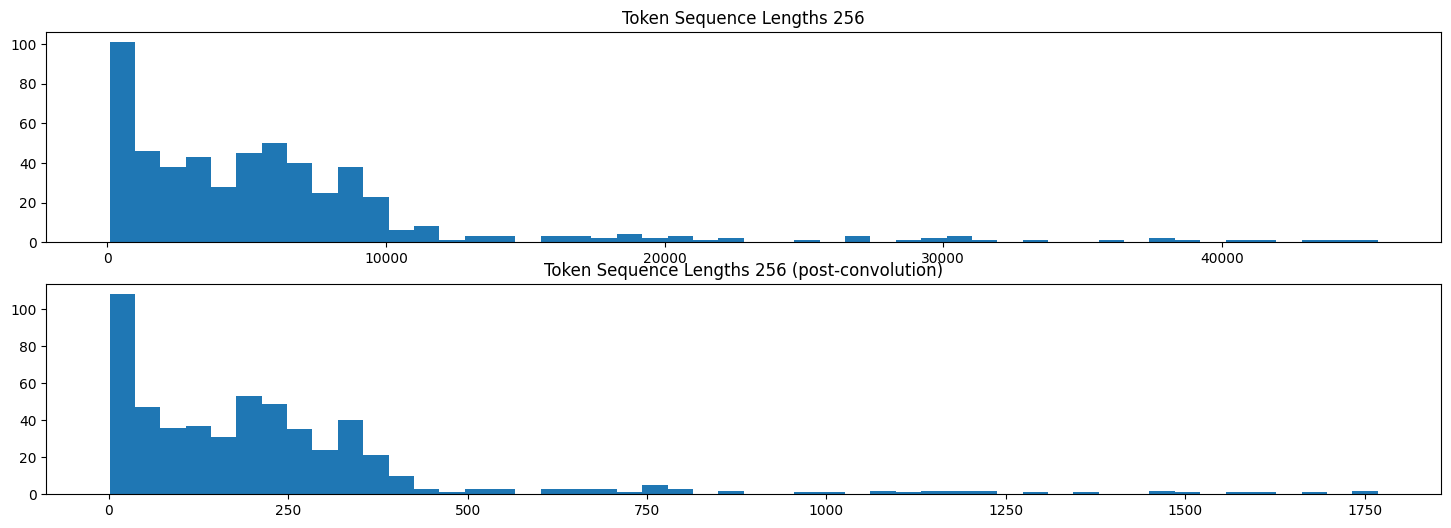

In [72]:
f, ax = plt.subplots(2, 1, figsize=(18, 6))
ax[0].hist(sizes_256, bins=50)
ax[0].set_title("Token Sequence Lengths 256")

ax[1].hist(sizes_256_conv, bins=50)
ax[1].set_title("Token Sequence Lengths 256 (post-convolution)")

plt.show()

In [12]:
from glob import glob
files = glob(join(RESOURCE_DIR, "PRS_data_256", "*", "*.npz"))
count = 0

file_feats = []
for file_path in files:
    with np.load(file_path, allow_pickle=True) as f:
        n_feat = len([key for key in f if "feature_" in key])
        features = [f[f"feature_{i}"] for i in range(n_feat)]
        
        foreground_features = [feat[feat.any(axis=-1)] for feat in features]
        foreground_features = np.concatenate(foreground_features, axis=0)
        
        file_feats.append(foreground_features)
file_feats = np.concatenate(file_feats, axis=0)


avg_feat = np.mean(file_feats, axis=0)
std_feat = np.std(file_feats, axis=0)

print(f"Average and std collected")

for file_path in files:
    with np.load(file_path, allow_pickle=True) as f:
        n_feat = len([key for key in f if "feature_" in key])
        data_to_save = dict(f)  # Copy all original keys and values
        
        for i in range(n_feat):
            feature_key = f"feature_{i}"
            feature_data = f[feature_key]
            mask = feature_data.any(axis=-1)
            foreground_feature = feature_data[mask]
            
            # Normalize the foreground feature
            normalized_foreground_feature = (foreground_feature - avg_feat) / std_feat
            
            # Replace the original feature data with the normalized data in the same shape
            normalized_feature_data = feature_data.copy()
            normalized_feature_data[mask] = normalized_foreground_feature
            data_to_save[feature_key] = normalized_feature_data
        
        # Save the normalized features and all other original data back to the file
        np.savez(file_path, **data_to_save)

Average and std collected


In [16]:
from glob import glob
files = glob(join(RESOURCE_DIR, "PRS_data_256", "*", "*.npz"))
count = 0

file_feats = []
for file_path in files:
    with np.load(file_path, allow_pickle=True) as f:
        n_feat = len([key for key in f if "feature_" in key])
        features = [f[f"feature_{i}"] for i in range(n_feat)]
        
        foreground_features = [feat[feat.any(axis=-1)] for feat in features]
        foreground_features = np.concatenate(foreground_features, axis=0)
        
        file_feats.append(foreground_features)
file_feats = np.concatenate(file_feats, axis=0)


avg_feat = np.mean(file_feats, axis=0)
std_feat = np.std(file_feats, axis=0)
std_feat

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

# Set up Dataset Functions

In [2]:
from tensorflow.data import TFRecordDataset

hipt = False
npzdir = join(RESOURCE_DIR, "PRS_data_256_sm")
npzdir += "_hipt" if hipt else ""

In [3]:
load_softlabels = True
max_size = 384
max_dim = 32
            
def parse_tfrecord_function(serialized_example, load_softlabels=False, return_files=False):
    # Define the feature structure for parsing
    feature_description = {
        'inputs': tf.io.VarLenFeature(tf.float32),
        'inputs_shape': tf.io.FixedLenFeature([4], tf.int64),
        'inputs_bboxes': tf.io.VarLenFeature(tf.int64),
        'label': tf.io.FixedLenFeature([], tf.float32),
        'soft': tf.io.FixedLenFeature([], tf.float32),
        'patient_files': tf.io.FixedLenFeature([], tf.string),
    }

    # Parse the input features from the serialized example
    parsed_features = tf.io.parse_single_example(serialized_example, feature_description)

    # Deserialize inputs and reshape
    inputs = tf.sparse.to_dense(parsed_features['inputs'])
    inputs = tf.reshape(inputs, parsed_features['inputs_shape'])
    
    bboxes = tf.sparse.to_dense(parsed_features['inputs_bboxes'])
    bboxes = tf.reshape(bboxes, [-1, 4])

    # Always parse both label and soft, but choose one based on the flag
    label = parsed_features['soft'] if load_softlabels else parsed_features['label']
    
    # Prepare return values based on flags
    return_values = {"inputs":inputs, "label":label, "bboxes": bboxes}
    if return_files:
        # Deserialize patient files and check for the delimiter
        patient_files = parsed_features['patient_files']
        patient_files = tf.strings.split(patient_files, '|')
        return_values.update({"patient_files": patient_files})
    return return_values

def create_tfrecord_dataset(tfrecord_dir, load_softlabels=False, return_files=False, pre_split=True):
    tfrecord_files = glob(join(tfrecord_dir, "*.tfrecord"))
    raw_dataset = TFRecordDataset(tfrecord_files, num_parallel_reads=tf.data.AUTOTUNE)

    def _parse_function(serialized_example):
        return parse_tfrecord_function(serialized_example, load_softlabels=load_softlabels, return_files=return_files)

    parsed_dataset = raw_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if pre_split:
        def _tensor_splitter(example):
            new_example = example.copy()
            new_example["inputs"] = split_sequences(new_example["inputs"], new_example["bboxes"], max_dim=max_dim)
            return new_example
        parsed_dataset = parsed_dataset.map(_tensor_splitter, num_parallel_calls=tf.data.AUTOTUNE)
    return parsed_dataset

def load_dataset(tfrecord_dir, load_softlabels=False, pre_split=True):
    tfrecord_dir = tfrecord_dir.replace("train", "train_tf")
    print(tfrecord_dir)
    return create_tfrecord_dataset(tfrecord_dir, load_softlabels=load_softlabels, return_files=False, pre_split=pre_split)

dataset = load_dataset(join(npzdir, "train"), load_softlabels=load_softlabels, pre_split=True)

# start_time = time()
# dataset_size = sum([1 for _ in iter(dataset)])
# # dataset_size = 939
# print(f"{dataset_size} examples loaded to dataset (read in {(time() -  start_time)/60:.2f}m)\n")

/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/train_tf


2024-04-25 22:52:38.622335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-25 22:52:38.624002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-25 22:52:38.624742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Instructions for updating:
Use fn_output_signature instead


2024-04-25 22:52:41,254 From /opt/tensorflow/lib/python3.10/site-packages/tensorflow/python/util/deprecation.py:648: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead


In [21]:
# # t = [d['inputs'].numpy().shape[0] for d in dataset]
# # t = np.array(t)

# np.median(t), t.min(), t.max()
# (30.0, 1, 160)

# Test the dataset

## test dampen

In [4]:
downscale_depth = 4

def random_dampen(x, training, factor=0.1, fraction=0.75):
    # Assume x is either a list of xi of shape [h, w, D] or a tensor of
    # shape [h, w, D]
    if not training:
        return x

    # Check if x is a list
    if isinstance(x, list):
        return [random_dampen(xi, training, factor, fraction) for xi in x]

    block_size = 2 ** (downscale_depth)
    h, w, D = x.shape

    n_blocks_h = h // block_size
    n_blocks_w = w // block_size

    num_blocks_to_dampen = int(n_blocks_h * n_blocks_w * fraction)
    num_blocks_to_dampen = np.random.randint(0, num_blocks_to_dampen + 1)

    rem_r = h % block_size
    rem_c = w % block_size

    start_r = tf.random.uniform(shape=(), maxval=rem_r, dtype=tf.int32)
    start_c = tf.random.uniform(shape=(), maxval=rem_c, dtype=tf.int32)

    mask = np.ones((h, w, D), dtype=x.dtype.as_numpy_dtype())
    indices = np.random.choice(n_blocks_h * n_blocks_w, num_blocks_to_dampen, replace=False)
    for idx in indices:
        row = (idx // n_blocks_w) * block_size + start_r
        col = (idx % n_blocks_w) * block_size + start_c
        
        factor_i = np.random.uniform(0.0, factor)
        mask[row:row + block_size, col:col + block_size, :] *= factor_i

    mask_tensor = tf.convert_to_tensor(mask, dtype=x.dtype)
    x = x * mask_tensor
    return x

In [5]:
ds = iter(dataset)
for i in range(5):
    testtf = next(ds)['inputs'][0, ...]

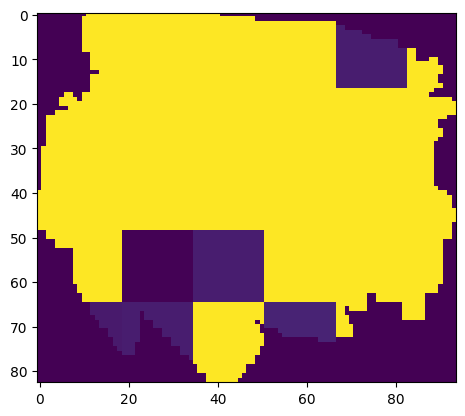

In [6]:
mask = tf.math.reduce_any(testtf != 0, axis=-1)[..., tf.newaxis]
mask = tf.cast(mask, testtf.dtype)
mask_new = random_dampen(mask, True)

plt.imshow(mask_new.numpy())


In [4]:
# Convert generator to tf.data.Dataset
dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(join(RESOURCE_DIR, "PRS_data")),
    output_signature={
        "inputs": tf.TensorSpec(shape=(None, None, None, 192), dtype=tf.float32),
        "labels": tf.TensorSpec(shape=(), dtype=tf.int32),
        "patient": tf.TensorSpec(shape=(), dtype=tf.string),
        "patient_files": tf.TensorSpec(shape=(None), dtype=tf.string)
    }
)

In [30]:
ds = iter(dataset)

for i in range(12):  # or whatever number of examples you want to inspect
    data_item = next(ds)
    features = data_item["inputs"]
    label = data_item["labels"].numpy()
    patient = data_item["patient"].numpy().decode("utf-8")
    patient_files = data_item["patient_files"].numpy()
    
    print(features.shape)
    features = revert_transformations(features)

    print(str(i).zfill(3), f"{patient}\t{[f.shape for f in features]}]\t{label} ({label_map[label]})")
    print(patient_files)
    print()

(1, 10, 12, 192)
000 TCGA-3C-AALK	[TensorShape([10, 12, 192])]]	0 (L)
[b'./resources/TCGA-BRCA-2/93b26333-5723-4fa4-a4de-6124c04ab243/TCGA-3C-AALK-01Z-00-DX1.4E6EB156-BB19-410F-878F-FC0EA7BD0B53.svs']

(1, 11, 12, 192)
001 TCGA-5T-A9QA	[TensorShape([11, 12, 192])]]	0 (L)
[b'./resources/TCGA-BRCA-2/cfe3c99d-0c00-4360-b768-2cb4fbd1040a/TCGA-5T-A9QA-01Z-00-DX1.B4212117-E0A7-4EF2-B324-8396042ACEC1.svs']

(1, 10, 14, 192)
002 TCGA-A1-A0SB	[TensorShape([10, 14, 192])]]	0 (L)
[b'./resources/TCGA-BRCA-2/cea82b7d-135a-49d5-b4f6-3fb0215f7188/TCGA-A1-A0SB-01Z-00-DX1.B34C267B-CAAA-4AB6-AD5C-276C26F997A1.svs']

(1, 9, 12, 192)
003 TCGA-A1-A0SD	[TensorShape([9, 12, 192])]]	0 (L)
[b'./resources/TCGA-BRCA-2/0a9ea7ac-9d51-4ff7-b40b-659a57e64945/TCGA-A1-A0SD-01Z-00-DX1.DB17BFA9-D951-42A8-91D2-F4C2EBC6EB9F.svs']

(1, 9, 15, 192)
004 TCGA-A1-A0SE	[TensorShape([9, 15, 192])]]	0 (L)
[b'./resources/TCGA-BRCA-2/53f1310d-cea9-4179-ad5c-3a257fcc7ed3/TCGA-A1-A0SE-01Z-00-DX1.04B09232-C6C4-46EF-AA2C-41D078D0A80A.s

2023-08-22 20:02:32.334159: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [16]:
test_N = 10
ds = iter(dataset)
test_feats = [next(ds)["inputs"] for i in range(test_N)]
test_feats = [arr.numpy()[i, ...] for arr in test_feats for i in range(arr.shape[0])]
test_feats = np.concatenate([arr[np.any(arr != 0, axis=-1)] for arr in test_feats], axis=0)

(38244, 384)

# Setup Model

In [4]:
from src.vit_slide.train import *
from src.vit_slide.layers import *
from src.vit_slide.model import *

DATE = "042824_lg_soft"
TILESIZE = "prs"
SUFFIX = f"_{TILESIZE}"

log_path = join(npzdir, "logs", DATE + SUFFIX)
out_path = join(npzdir, "outputs", DATE + SUFFIX)

In [5]:
found_example = False
ds = iter(dataset)
n_feat = 0
while n_feat < 3:
    test_inputs = next(ds)["inputs"]
    n_feat = next(ds)["bboxes"].shape[0]

2024-04-25 22:52:44.163372: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [939]
	 [[{{node Placeholder/_0}}]]
2024-04-25 22:52:44.163681: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [939]
	 [[{{node Placeholder/_0}}]]


In [10]:
in_dim = 128
phi_dim = None
use_phi = False
num_classes = 2
out_dim = 128

depth = 12
global_depth = 0

downscale_depth = 1
downscale_multiplier = 1.0

num_heads = 2
mlp_ratio = 2.0

encoding_method = "sinusoidal"

drop_path_rate = 0.4
drop_rate = 0.4
mask_num = 1
mask_preglobal = True

use_class_token = False
use_attn_mask = False

use_nystrom = False
num_landmarks = 512

global_k = -1

def create_model(run_tests=True):
    tf.keras.backend.clear_session()

    model = RS_Predictor_ViT_RPE_256(
        in_dim=in_dim,
        phi_dim=phi_dim,
        use_phi=use_phi,
        out_dim=out_dim, 
        drop_path_rate=drop_path_rate, 
        drop_rate=drop_rate,
        num_classes=num_classes,
        max_dim=max_dim,
        mask_num=mask_num,
        mask_preglobal=mask_preglobal,
        depth=depth,
        global_depth=global_depth,
        num_heads=num_heads,
        use_attn_mask=use_attn_mask,
        mlp_ratio=mlp_ratio,
        encoding_method=encoding_method,
        use_class_token=use_class_token,
        use_nystrom=use_nystrom,
        num_landmarks=num_landmarks,
        downscale_depth=downscale_depth,
        downscale_multiplier=downscale_multiplier,
        global_k=global_k,
        log_path=log_path,
        out_path=out_path,
        data_dir=npzdir,
    )
    
    if run_tests:
        print("test data...")
        model.model(test_inputs, training=True)
        model.model(test_inputs, training=False)
    return model
create_model(False).summary()

2024-04-26 18:18:25,548 Building model...


Using Background tile located: /home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/background_tile_norm.npy
[128]
input sizes ListWrapper([(32, 32), (16, 16)])
Model: "wsi_vit_256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_positional_encoding2d (  multiple                  0         
 TFPositionalEncoding2D)                                         
                                                                 
 wsi_vit_256_norm_local_lay  multiple                  512       
 er (LayerNormalization)                                         
                                                                 
 wsi_vit_256_norm_global_la  multiple                  512       
 yer (LayerNormalization)                                        
                                                                 
 wsi_vit_256_head_dense_glo  multiple                  514       
 bal (Dense)         

# Hyperparameter Search

## visualizations

In [14]:
DATE

'042324_lg_soft'

In [19]:
resource_dir = "./resources"
data_dir = join(resource_dir, "PRS_data_256_sm")
params_file = join(data_dir, DATE + "_best_hypers.feather")

results = pd.read_feather(params_file)
# results = results.iloc[1::2, :].sort_values(by='acc', ascending=False)
# results = results.loc[results.acc < .9].loc[results.early_stop == False]
results.iloc[7, :]

bs                              1
eval_bs                         1
eval_round                    187
learning_rate              0.0001
use_warmup                  False
optimizer                    adam
clip_norm                    -1.0
l2_coeff                 0.000001
l1_coeff                  0.00001
regional_coeff                0.1
momentum                     0.99
mask_num                        1
noise_aug                    0.05
dampen_noise                  0.5
dampen_fraction               1.0
early_stop_cutoff              25
pos_frac                      0.2
loss                     0.695652
acc                           0.0
iter                            3
steps                     54896.0
early_stop                   True
eval_every                    1.0
cce_weight           [0.625, 2.5]
bestLoss                      0.0
train_round                 752.0
train_steps              100000.0
Name: 7, dtype: object

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

# Remove rows with NaN values
df = results.dropna()
columns_to_drop = ["bs", "eval_bs", "eval_round", "use_warmup", "early_stop_cutoff", "steps", "early_stop", "eval_every", "train_round", "train_steps", "iter"]
df = df.drop(columns=columns_to_drop, errors='ignore')  # errors='ignore' will ensure no error is raised if a column doesn't exist

# Rename columns for brevity
df = df.rename(columns={
    "learning_rate": "lr",
    "clip_norm": "clip",
    "l2_coeff": "l2",
    "regional_coeff": "reg_coeff",
    "momentum": "mu",
    "cce_weight": "cce_w",
})


# Pair Plots:
df_log = df.copy()
df_log[["lr", "l2"]] = np.log10(df[["lr", "l2"]])
sns.pairplot(df_log, x_vars=["lr", "clip", "l2", "reg_coeff", "mu", "cce_w"], y_vars=["loss", "acc"], hue="optimizer", palette="tab10")
plt.show()

# Box Plots:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='optimizer', y='loss', palette="tab10")
plt.yscale("log")  # Setting y-axis to log-scale
plt.title("Box Plot of Loss by Optimizer")
plt.show()

# Correlation Matrix:
correlation_matrix = df[["lr", "clip", "l2", "reg_coeff", "mu", "cce_w", "loss", "acc"]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

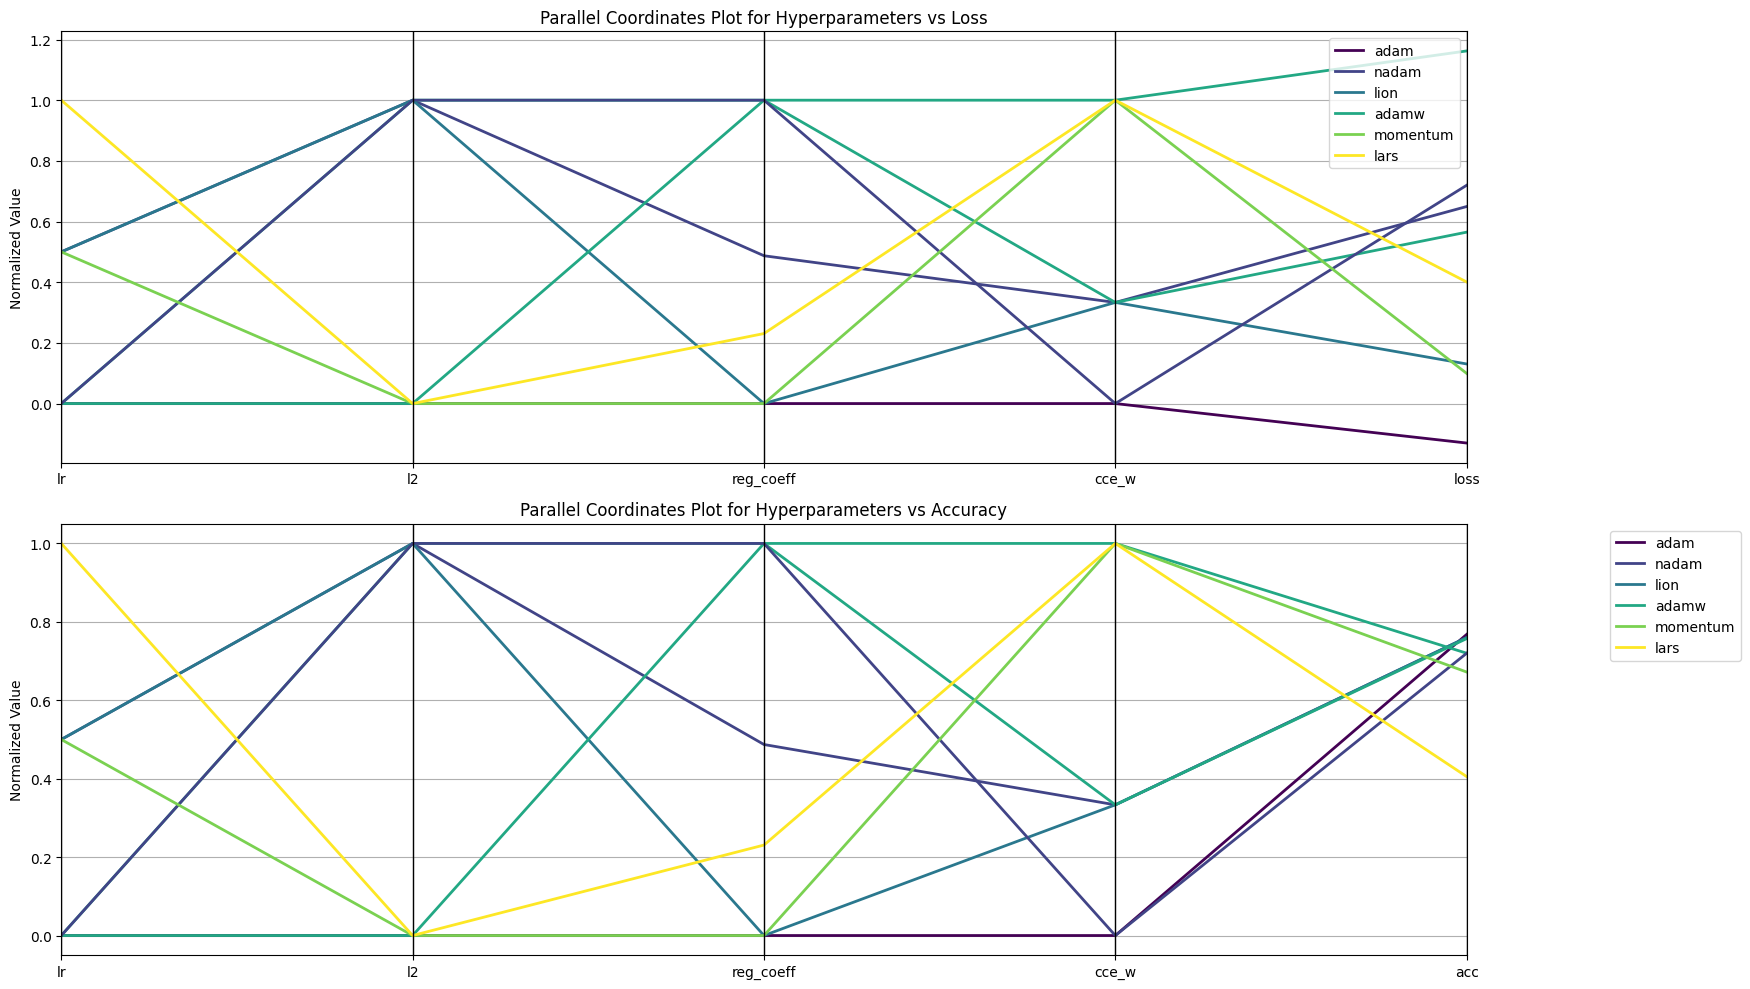

In [11]:
# Parallel Coordinates Plot
parallel_df = df.copy()

# Log transformations
parallel_df[['lr', 'l2', 'loss']] = np.log10(parallel_df[['lr', 'l2', 'loss']])

# Convert 'clip' and 'mu' to categorical and map to normalized float values
clip_categories = parallel_df['clip'].astype('category').cat.categories
parallel_df['clip'] = parallel_df['clip'].astype('category').cat.codes / (len(clip_categories) - 1)

mu_categories = parallel_df['mu'].astype('category').cat.categories
parallel_df['mu'] = parallel_df['mu'].astype('category').cat.codes / (len(mu_categories) - 1)

# Renaming and modifying the list
cols_to_normalize = ["lr", "l2", "reg_coeff", "cce_w"]
parallel_df[cols_to_normalize] = (parallel_df[cols_to_normalize] - parallel_df[cols_to_normalize].min()) / (parallel_df[cols_to_normalize].max() - parallel_df[cols_to_normalize].min())

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# For the loss plot
plot_cols_loss = cols_to_normalize + ["loss"]
parallel_coordinates(parallel_df[plot_cols_loss + ["optimizer"]], class_column='optimizer', cols=plot_cols_loss, ax=axes[0], colormap='viridis', linewidth=2)
axes[0].set_title('Parallel Coordinates Plot for Hyperparameters vs Loss')
axes[0].set_xticks(range(len(plot_cols_loss)))
axes[0].set_xticklabels(plot_cols_loss)
axes[0].set_ylabel('Normalized Value')
axes[0].grid(True)

# For the accuracy plot
plot_cols_acc = cols_to_normalize + ["acc"]
parallel_coordinates(parallel_df[plot_cols_acc + ["optimizer"]], class_column='optimizer', cols=plot_cols_acc, ax=axes[1], colormap='viridis', linewidth=2)
axes[1].set_title('Parallel Coordinates Plot for Hyperparameters vs Accuracy')
axes[1].set_xticks(range(len(plot_cols_acc)))
axes[1].set_xticklabels(plot_cols_acc)
axes[1].set_ylabel('Normalized Value')
axes[1].grid(True)

plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

## parameter search

In [ ]:
ranges = {
    "bs": [1],
    "eval_bs": [1],
    "eval_round": [77], 
    "learning_rate": [5e-4, 1e-4, 1e-5, 5e-6, 1e-6],
    "use_warmup": [False],
    "optimizer": ['adam'],
    "clip_norm": [-1.0],
    "l2_coeff": [5e-5, 1e-5, 5e-6, 1e-6],
    "l1_coeff": [1e-5],
    "regional_coeff": [0.0, 0.10, 0.25, 0.5],
    "momentum": [0.99],
    "mask_num": [1],
    'noise_aug': [0.05, 0.1, 0.25, 0.5, 1.0],
    'dampen_noise': [0.0, 0.05, 0.1, 0.25, 0.5, 1.0, 2.0],
    'dampen_fraction': [0.5, 0.75, 1.0],
    "early_stop_cutoff": [25],
    "pos_frac": [0.15, 0.18, 0.20, 0.25, 0.5]
}
DATE = "042324_lg_soft"

best_loss = 0.5
save_dir = join(RESOURCE_DIR, "PRS_data_256_sm")

train_steps = 100000
model = create_model(False)

dataset_size = -1
best_params = model.parameter_search(dataset, dataset_size, ranges, train_steps, best_loss, save_dir,
                                     k=5, n=2, standard_bs=1, n_iter=25,
                                     read_previous=False,
                                     save_file_name=DATE + "_best_hypers.feather",
                                    save_metric="f1")

2024-04-05 16:10:37,991 Building model...


Using Background tile located: /home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/background_tile_norm.npy
[128]
input sizes ListWrapper([(32, 32), (16, 16)])


2024-04-05 16:10:39,914 Creating our log file for parameter search
2024-04-05 16:10:39,919 Iter: 0
Params:
{'bs': 1, 'eval_bs': 1, 'eval_round': 77, 'learning_rate': 1e-06, 'use_warmup': False, 'optimizer': 'adam', 'clip_norm': -1.0, 'l2_coeff': 5e-05, 'l1_coeff': 1e-05, 'regional_coeff': 0.25, 'momentum': 0.99, 'mask_num': 1, 'noise_aug': 0.5, 'dampen_noise': 2.0, 'dampen_fraction': 0.5, 'early_stop_cutoff': 25, 'pos_frac': 0.15, 'eval_every': 1, 'cce_weight': [0.5882352941176471, 3.3333333333333335], 'bestLoss': 0.0}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:745: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)


Using Background tile located: /home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/background_tile_norm.npy
[128]
input sizes ListWrapper([(32, 32), (16, 16)])


2024-04-05 16:10:42,545 Training for 100000 steps..
2024-04-05 16:10:54,452 Training for Fold 1/5 ...
2024-04-05 16:10:54,505 
Set up Training! Preparing Datasets...
2024-04-05 16:10:54,511 Updates per training cycle: 752
2024-04-05 16:10:54,512 Updates per evaluation cycle: 187
2024-04-05 16:10:54.529698: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype string and shape [939]
	 [[{{node Placeholder/_14}}]]
2024-04-05 16:10:54.530239: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [939]
	 [[{{node Placeholder/_0}}]]
2024-04-05 16:10:54.625085: I te

Using Adam 

Not using mixed precision



2024-04-05 16:10:54,868 Starting training!
2024-04-05 16:11:04.914752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:386] Filling up shuffle buffer (this may take a while): 335 of 752
2024-04-05 16:11:14.664096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:411] Shuffle buffer filled.
2024-04-05 16:21:12,851 Eval..
2024-04-05 16:22:15,326 Iter 752, Loss (Trn/ Tst): (1.7299, 1.7454) Acc: (0.466 , 0.508) F1: (0.367 , 0.489)
2024-04-05 16:31:56,438 Eval..
2024-04-05 16:32:58,819 Iter 1504, Loss (Trn/ Tst): (1.6815, 1.7270) Acc: (0.426 , 0.513) F1: (0.415 , 0.492)
2024-04-05 16:32:59,252 Saved Model!
2024-04-05 16:42:45,259 Eval..
2024-04-05 16:43:47,786 Iter 2256, Loss (Trn/ Tst): (1.6658, 1.7185) Acc: (0.418 , 0.503) F1: (0.413 , 0.497)
2024-04-05 16:43:48,201 Saved Model!
2024-04-05 16:53:36,185 Eval..
2024-04-05 16:54:38,768 Iter 3008, Loss (Trn/ Tst): (1.6572, 1.7150) Acc: (0.438 , 0.519) F1: (0.427 , 0.471)
2024-04-05 17:04:24,976 Eval..
2024-04-05 17:05:27,287 Iter 376

Using Background tile located: /home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/background_tile_norm.npy
[128]
input sizes ListWrapper([(32, 32), (16, 16)])


/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:780: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2024-04-06 03:34:44,871 Iter: 1
Params:
{'bs': 1, 'eval_bs': 1, 'eval_round': 77, 'learning_rate': 0.0001, 'use_warmup': False, 'optimizer': 'adam', 'clip_norm': -1.0, 'l2_coeff': 5e-05, 'l1_coeff': 1e-05, 'regional_coeff': 0.0, 'momentum': 0.99, 'mask_num': 1, 'noise_aug': 0.5, 'dampen_noise': 2.0, 'dampen_fraction': 1.0, 'early_stop_cutoff': 25, 'pos_frac': 0.5, 'eval_every': 1, 'cce_weight': [1.0, 1.0], 'bestLoss': 0.0}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:745: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)




New best found: loss = 0.5826771259307861, params = {'bs': 1, 'eval_bs': 1, 'eval_round': 187, 'learning_rate': 1e-06, 'use_warmup': False, 'optimizer': 'adam', 'clip_norm': -1.0, 'l2_coeff': 5e-05, 'l1_coeff': 1e-05, 'regional_coeff': 0.25, 'momentum': 0.99, 'mask_num': 1, 'noise_aug': 0.5, 'dampen_noise': 2.0, 'dampen_fraction': 0.5, 'early_stop_cutoff': 25, 'pos_frac': 0.15, 'eval_every': 1, 'cce_weight': [0.5882352941176471, 3.3333333333333335], 'bestLoss': 0.0, 'train_round': 752, 'train_steps': 100000}


Using Background tile located: /home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/background_tile_norm.npy
[128]
input sizes ListWrapper([(32, 32), (16, 16)])


2024-04-06 03:34:48,330 Training for 100000 steps..
2024-04-06 03:34:58,922 Training for Fold 1/5 ...
2024-04-06 03:34:58,999 
Set up Training! Preparing Datasets...


Using Adam 

Not using mixed precision



2024-04-06 03:34:59,192 Updates per training cycle: 752
2024-04-06 03:34:59,196 Updates per evaluation cycle: 187
2024-04-06 03:34:59.276604: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [939]
	 [[{{node Placeholder/_0}}]]
2024-04-06 03:34:59.277491: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [939]
	 [[{{node Placeholder/_0}}]]
2024-04-06 03:34:59.457404: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): I

Using Background tile located: /home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/background_tile_norm.npy
[128]
input sizes ListWrapper([(32, 32), (16, 16)])


/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:780: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2024-04-06 09:16:01,789 Iter: 2
Params:
{'bs': 1, 'eval_bs': 1, 'eval_round': 77, 'learning_rate': 0.0001, 'use_warmup': False, 'optimizer': 'adam', 'clip_norm': -1.0, 'l2_coeff': 1e-05, 'l1_coeff': 1e-05, 'regional_coeff': 0.25, 'momentum': 0.99, 'mask_num': 1, 'noise_aug': 0.05, 'dampen_noise': 1.0, 'dampen_fraction': 1.0, 'early_stop_cutoff': 25, 'pos_frac': 0.15, 'eval_every': 1, 'cce_weight': [0.5882352941176471, 3.3333333333333335], 'bestLoss': 0.0}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:745: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)




New best found: loss = 0.6000000238418579, params = {'bs': 1, 'eval_bs': 1, 'eval_round': 187, 'learning_rate': 0.0001, 'use_warmup': False, 'optimizer': 'adam', 'clip_norm': -1.0, 'l2_coeff': 5e-05, 'l1_coeff': 1e-05, 'regional_coeff': 0.0, 'momentum': 0.99, 'mask_num': 1, 'noise_aug': 0.5, 'dampen_noise': 2.0, 'dampen_fraction': 1.0, 'early_stop_cutoff': 25, 'pos_frac': 0.5, 'eval_every': 1, 'cce_weight': [1.0, 1.0], 'bestLoss': 0.0, 'train_round': 752, 'train_steps': 100000}


Using Background tile located: /home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/background_tile_norm.npy
[128]
input sizes ListWrapper([(32, 32), (16, 16)])


2024-04-06 09:16:05,364 Training for 100000 steps..
2024-04-06 09:16:22,405 Training for Fold 1/5 ...
2024-04-06 09:16:22,461 
Set up Training! Preparing Datasets...


Using Adam 

Not using mixed precision



2024-04-06 09:16:22,657 Updates per training cycle: 752
2024-04-06 09:16:22,661 Updates per evaluation cycle: 187
2024-04-06 09:16:22.752741: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype string and shape [939]
	 [[{{node Placeholder/_14}}]]
2024-04-06 09:16:22.759535: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype string and shape [939]
	 [[{{node Placeholder/_14}}]]
2024-04-06 09:16:22.902107: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message

Using Background tile located: /home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/background_tile_norm.npy
[128]
input sizes ListWrapper([(32, 32), (16, 16)])


/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:780: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2024-04-06 16:12:33,673 Iter: 3
Params:
{'bs': 1, 'eval_bs': 1, 'eval_round': 77, 'learning_rate': 0.0001, 'use_warmup': False, 'optimizer': 'adam', 'clip_norm': -1.0, 'l2_coeff': 1e-06, 'l1_coeff': 1e-05, 'regional_coeff': 0.1, 'momentum': 0.99, 'mask_num': 1, 'noise_aug': 0.05, 'dampen_noise': 0.5, 'dampen_fraction': 1.0, 'early_stop_cutoff': 25, 'pos_frac': 0.2, 'eval_every': 1, 'cce_weight': [0.625, 2.5], 'bestLoss': 0.0}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:745: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)




New best found: loss = 0.6771654486656189, params = {'bs': 1, 'eval_bs': 1, 'eval_round': 187, 'learning_rate': 0.0001, 'use_warmup': False, 'optimizer': 'adam', 'clip_norm': -1.0, 'l2_coeff': 1e-05, 'l1_coeff': 1e-05, 'regional_coeff': 0.25, 'momentum': 0.99, 'mask_num': 1, 'noise_aug': 0.05, 'dampen_noise': 1.0, 'dampen_fraction': 1.0, 'early_stop_cutoff': 25, 'pos_frac': 0.15, 'eval_every': 1, 'cce_weight': [0.5882352941176471, 3.3333333333333335], 'bestLoss': 0.0, 'train_round': 752, 'train_steps': 100000}


Using Background tile located: /home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/background_tile_norm.npy
[128]
input sizes ListWrapper([(32, 32), (16, 16)])


2024-04-06 16:12:37,324 Training for 100000 steps..
2024-04-06 16:12:46,852 Training for Fold 1/5 ...
2024-04-06 16:12:46,907 
Set up Training! Preparing Datasets...


Using Adam 

Not using mixed precision



2024-04-06 16:12:47,098 Updates per training cycle: 752
2024-04-06 16:12:47,109 Updates per evaluation cycle: 187
2024-04-06 16:12:47.169873: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [939]
	 [[{{node Placeholder/_0}}]]
2024-04-06 16:12:47.177977: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype string and shape [939]
	 [[{{node Placeholder/_14}}]]
2024-04-06 16:12:47.362466: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

Using Background tile located: /home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/background_tile_norm.npy
[128]
input sizes ListWrapper([(32, 32), (16, 16)])


/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:780: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2024-04-07 05:35:36,770 Iter: 4
Params:
{'bs': 1, 'eval_bs': 1, 'eval_round': 77, 'learning_rate': 0.0001, 'use_warmup': False, 'optimizer': 'adam', 'clip_norm': -1.0, 'l2_coeff': 1e-06, 'l1_coeff': 1e-05, 'regional_coeff': 0.5, 'momentum': 0.99, 'mask_num': 1, 'noise_aug': 0.5, 'dampen_noise': 2.0, 'dampen_fraction': 1.0, 'early_stop_cutoff': 25, 'pos_frac': 0.15, 'eval_every': 1, 'cce_weight': [0.5882352941176471, 3.3333333333333335], 'bestLoss': 0.0}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:745: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)




New best found: loss = 0.695652186870575, params = {'bs': 1, 'eval_bs': 1, 'eval_round': 187, 'learning_rate': 0.0001, 'use_warmup': False, 'optimizer': 'adam', 'clip_norm': -1.0, 'l2_coeff': 1e-06, 'l1_coeff': 1e-05, 'regional_coeff': 0.1, 'momentum': 0.99, 'mask_num': 1, 'noise_aug': 0.05, 'dampen_noise': 0.5, 'dampen_fraction': 1.0, 'early_stop_cutoff': 25, 'pos_frac': 0.2, 'eval_every': 1, 'cce_weight': [0.625, 2.5], 'bestLoss': 0.0, 'train_round': 752, 'train_steps': 100000}


Using Background tile located: /home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/background_tile_norm.npy
[128]
input sizes ListWrapper([(32, 32), (16, 16)])


2024-04-07 05:35:40,325 Training for 100000 steps..
2024-04-07 05:35:50,958 Training for Fold 1/5 ...
2024-04-07 05:35:51,013 
Set up Training! Preparing Datasets...


Using Adam 

Not using mixed precision



2024-04-07 05:35:51,212 Updates per training cycle: 752
2024-04-07 05:35:51,216 Updates per evaluation cycle: 187
2024-04-07 05:35:51.287562: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype string and shape [939]
	 [[{{node Placeholder/_14}}]]
2024-04-07 05:35:51.291021: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [939]
	 [[{{node Placeholder/_0}}]]
2024-04-07 05:35:51.482295: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

Using Background tile located: /home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/background_tile_norm.npy
[128]
input sizes ListWrapper([(32, 32), (16, 16)])


/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:780: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2024-04-07 12:34:00,038 Iter: 5
Params:
{'bs': 1, 'eval_bs': 1, 'eval_round': 77, 'learning_rate': 5e-06, 'use_warmup': False, 'optimizer': 'adam', 'clip_norm': -1.0, 'l2_coeff': 5e-05, 'l1_coeff': 1e-05, 'regional_coeff': 0.1, 'momentum': 0.99, 'mask_num': 1, 'noise_aug': 0.25, 'dampen_noise': 2.0, 'dampen_fraction': 1.0, 'early_stop_cutoff': 25, 'pos_frac': 0.5, 'eval_every': 1, 'cce_weight': [1.0, 1.0], 'bestLoss': 0.0}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:745: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)


Using Background tile located: /home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/background_tile_norm.npy
[128]
input sizes ListWrapper([(32, 32), (16, 16)])


2024-04-07 12:34:03,903 Training for 100000 steps..
2024-04-07 12:34:13,817 Training for Fold 1/5 ...
2024-04-07 12:34:13,876 
Set up Training! Preparing Datasets...


Using Adam 

Not using mixed precision



2024-04-07 12:34:14,066 Updates per training cycle: 752
2024-04-07 12:34:14,089 Updates per evaluation cycle: 187
2024-04-07 12:34:14.156906: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [939]
	 [[{{node Placeholder/_0}}]]
2024-04-07 12:34:14.162431: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [939]
	 [[{{node Placeholder/_0}}]]
2024-04-07 12:34:14.363967: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): I

In [ ]:
import gc
gc.collect()

# Final Training

In [11]:
dataset_size = 939

In [ ]:
##### from src.vit_slide.model import *
f = 0.2
hyper_params = {
    # 'prefetch': None,
    'bs': 1,
    'train_round': 300,
    'eval_every': 1,
    'eval_bs': 1,
    'eval_round': 77, 
    'learning_rate': 1e-4,
    'use_warmup': False,
    'warmup_epochs': 3,
    'optimizer': 'adam',
    'clip_norm': -1,
    'l2_coeff': 1e-5,
    'l1_coeff': 1e-4,
    "regional_coeff": 0.5,
    'noise_aug': 0.05,
    'dampen_noise': 0.25,
    'dampen_fraction': 0.75,
    'momentum': 0.99,
    "cce_weight": [(1 / (2 * (1-f))), (1 / (2 * f))],
    "mask_num": 1,
    'early_stop_cutoff': 100,
    "bestLoss": 0.7
}

train_steps = 100000
model = create_model(False)
model.model.set_mask_num(hyper_params["mask_num"])

k = 10
total_size = dataset_size
fold_size = total_size // k
val_ds = dataset.take(fold_size)
trn_ds = dataset.skip(fold_size)

hyper_params["train_round"] = (total_size - fold_size) // hyper_params["bs"]
hyper_params["eval_round"] = fold_size // hyper_params["eval_bs"]

model.train(trn_ds, train_steps, val_ds=val_ds,
           restore=False,
           shuffle_buffer=fold_size,
           cache_dataset=False,
           save_checkpoints=True,
           hyper_params=hyper_params,
           fold=1,
           save_metric="f1")

# k = 10
# n = 3
# total_size = dataset_size
# dataset = dataset.take(total_size)

# k_losses, k_accs = model.train_kfold(
#     dataset,
#     train_steps,
#     total_size=total_size,
#     shuffle_ds=True,
#     k=k,
#     n=n,
#     hyper_params=hyper_params,
#     save_metric='f1',
# )

2024-04-26 21:26:55,081 Building model...


Using Background tile located: /home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm/background_tile_norm.npy
[128]
input sizes ListWrapper([(32, 32), (16, 16)])


2024-04-26 21:26:57,662 
Set up Training! Preparing Datasets...
2024-04-26 21:26:57,668 Updates per training cycle: 846
2024-04-26 21:26:57,669 Updates per evaluation cycle: 93


Using Adam 

Not using mixed precision



2024-04-26 21:26:57.686783: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [939]
	 [[{{node Placeholder/_0}}]]
2024-04-26 21:26:57.687719: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [939]
	 [[{{node Placeholder/_0}}]]
2024-04-26 21:26:57.786886: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [939]
	

In [ ]:
k_losses, k_accs

In [ ]:
np.array(k_losses).mean(), np.array(k_accs).mean()

# Old Method

In [3]:
labels = [SLIDES_PRS_DATA.loc[SLIDES_PRS_DATA.slide == splitext(basename(f))[0]].odx85.values[0] for f in SLIDES_PRS]
labels = np.eye(2)[(np.array(labels) == "H").astype(int)]

inputs = np.load(join(DATA_DIR, "all_features.npy"))

# Create a list of shuffled indices
indices = np.arange(len(inputs))
np.random.shuffle(indices)

# Use the shuffled indices to shuffle inputs and labels
inputs = inputs[indices]
labels = labels[indices]

# Create the dictionary
data = {
    "inputs": inputs,
    "labels": labels
}

# Convert to tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices(data)
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
dataset = dataset.with_options(options)

2023-08-04 06:54:46.510268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-04 06:54:46.510729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-04 06:54:46.511116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
labels[:, 0].sum() / len(labels[:, 0])

0.7167300380228137

In [24]:
in_dim = 192
out_dim = 512

drop_path_rate = 0.0
drop_rate = 0.0

num_embed = 1024
num_classes = 2

depth = 2
global_depth = 1
num_heads = 16

model = RS_Predictor(
    in_dim, out_dim, drop_path_rate, drop_rate,
    num_embed, num_classes,
    depth, num_heads,
    LOG_PATH, OUT_PATH, DATA_DIR)
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2023-08-04 14:06:20,643 Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Model: "wsi_vit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wsi_vit_phi (Sequential)    (2, 1024, 512)            98816     
                                                                 
 wsi_vit_pos_drop (Dropout)  multiple                  0         
                                                                 
 wsi_vit_block_0 (Block)     multiple                  1050112   
                                                                 
 wsi_vit_block_1 (Block)     multiple                  1050112   
                                                                 
 wsi_vit_norm_layer (LayerN  multiple                  1024      
 ormalization)                                                   
                                                                 
 wsi_vit_head_dense (Dense)  multiple                  1026      
                                                           

In [ ]:
# Convert generator to tf.data.Dataset
dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(join(RESOURCE_DIR, "PRS_data")),
    output_signature={
        "inputs": tf.TensorSpec(shape=(None, None, None, 192), dtype=tf.float32),
        "labels": tf.TensorSpec(shape=(), dtype=tf.int32),
        "patient": tf.TensorSpec(shape=(), dtype=tf.string),
        "patient_files": tf.TensorSpec(shape=(None), dtype=tf.string)
    }
)
dataset = iter(dataset)

In [25]:
hyper_params = {
    'bs': 24,
    'train_round': 16,
    'eval_every': 1,
    'eval_bs': 64,
    'eval_round': 2,
    'learning_rate': 1e-6,
    'use_warmup': False,
    'warmup_epochs': 10,
    'optimizer': 'momentum',
    'clip_norm': -1.0,
    'l2_coeff': 1e-5,
    'momentum': 0.99,
    'early_stop_cutoff': 50,
}

model.train(dataset, 50000, hyper_params=hyper_params)

2023-08-04 14:06:21,686 Updates per training cycle: 16
2023-08-04 14:06:21,686 Updates per evaluation cycle: 2


Using SGD

Not using mixed precision



2023-08-04 14:06:22.223068: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 14:06:22.223608: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 14:06:22.803381: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 14:06:30,135 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 14:06:36,473 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 14:06:42,240 Eval..
2023-08-04 14:06:42,307 Iter 16, Train Loss: 0.6852, Train Accuracy: 0.600 Test Loss 0.4999, Test Accuracy: 0.812
2023-08-04 14:06:42,508 Saved Model!
2023-08-04 14:06:43,429 Eval..
2023-08-04 14:06:43,496 Iter 32, Train Loss: 0.6272, Train Accuracy: 0.715 Test Loss 0.6847, Test Accuracy: 0.646
2023-08-04 14:06:44,472 Eval..
2023-08-04 14:06:44,540 Iter 48, Train Loss: 0.6190, Train Accuracy: 0.710 Test Loss 0.6232, Test Accuracy: 0.729
2023-08-04 14:06:45,517 Eval..
2023-08-04 14:06:45,585 Iter 64, Train Loss: 0.6008, Train Accuracy: 0.725 Test Loss 0.6127, Test Accuracy: 0.688
2023-08-04 14:06:46,557 Eval..
2023-08-04 14:06:46,625 Iter 80, Train Loss: 0.6129, Train Accuracy: 0.706 Test Loss 0.6265, Test Accuracy: 0.708
2023-08-04 14:06:47,599 Eval..
2023-08-04 14:06:47,667 Iter 96, Train

In [9]:
ranges = {
    "bs": [4, 8, 16, 24, 32, 48],
    "eval_bs": [64],
    "eval_round": [2], 
    "learning_rate": [1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
    "use_warmup": [True, False],
    "optimizer": ['momentum', 'adam', 'nadam', 'lars'],
    "clip_norm": [-1.0, 0.5, 1.0, 2.0],
    "warmup_epochs": [5, 10, 15],
    "l2_coeff": [1e-4, 1e-5, 1e-6, 1e-7],
    "momentum": [0.8, 0.9, 0.99, 0.999],
    "early_stop_cutoff": [100],
}


best_loss = float('inf')  # Initialize best loss as a very large number
save_dir = join(RESOURCE_DIR, "slide_level")
train_steps = 25000
size = labels.shape[0]

best_params = model.parameter_search(dataset, size, ranges, train_steps, best_loss, save_dir, standard_bs=4, n_iter=100)

2023-08-04 06:58:48,172 Creating our log file for parameter search
2023-08-04 06:58:48,183 Iter: 0
Params:
{'bs': 4, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-07, 'use_warmup': True, 'optimizer': 'nadam', 'clip_norm': 2.0, 'warmup_epochs': 5, 'l2_coeff': 0.0001, 'momentum': 0.99, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 99}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 06:58:48,381 Training for 25000 steps..
2023-08-04 06:58:48,482 Updates per training cycle: 99
2023-08-04 06:58:48,482 Updates per evaluation cycle: 2


Using Nadam 

Not using mixed precision



2023-08-04 06:58:49.035855: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 06:58:49.036438: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 06:58:49.651900: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 06:58:57,664 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 06:59:06,369 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 06:59:16,705 Eval..
2023-08-04 06:59:16,735 Iter 99, Train Loss: nan, Train Accuracy: 0.499 Test Loss nan, Test Accuracy: 0.500
2023-08-04 06:59:16,740 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 06:59:16,898 Iter: 1
Params:
{'bs': 48, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-06, 'use_warmup': True, 'optimizer': 'lars', 'clip_norm': 2.0, 'warmup_epochs': 15, 'l2_coeff': 1e-07, 'momentum': 0.999, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 8}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append metho



New best found: loss = 1000000000.0, params = {'bs': 4, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-07, 'use_warmup': True, 'optimizer': 'nadam', 'clip_norm': 2.0, 'warmup_epochs': 5, 'l2_coeff': 0.0001, 'momentum': 0.99, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 99, 'train_steps': 25000}


Using LARS 

Not using mixed precision



2023-08-04 06:59:17,182 Updates per training cycle: 8
2023-08-04 06:59:17,182 Updates per evaluation cycle: 2
2023-08-04 06:59:17.742338: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 06:59:17.743005: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 06:59:18.369903: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this mess

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 06:59:26,412 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 06:59:32,936 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 06:59:40,878 Eval..
2023-08-04 06:59:40,990 Iter 8, Train Loss: 0.7081, Train Accuracy: 0.456 Test Loss 0.7130, Test Accuracy: 0.469
2023-08-04 06:59:41,241 Saved Model!
2023-08-04 06:59:42,107 Eval..
2023-08-04 06:59:42,219 Iter 16, Train Loss: 0.7048, Train Accuracy: 0.465 Test Loss 0.7072, Test Accuracy: 0.448
2023-08-04 06:59:42,444 Saved Model!
2023-08-04 06:59:43,305 Eval..
2023-08-04 06:59:43,418 Iter 24, Train Loss: 0.7098, Train Accuracy: 0.449 Test Loss 0.7139, Test Accuracy: 0.443
2023-08-04 06:59:44,339 Eval..
2023-08-04 06:59:44,450 Iter 32, Train Loss: 0.7090, Train Accuracy: 0.451 Test Loss 0.7114, Test Accuracy: 0.438
2023-08-04 06:59:45,373 Eval..
2023-08-04 06:59:45,485 Iter 40, Train Loss: 0.7059, Train Accuracy: 0.473 Test Loss 0.7129, Test Accuracy: 0.469
2023-08-04 06:59:46,403 Eval..
20



New best found: loss = 0.7033846974372864, params = {'bs': 48, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-06, 'use_warmup': True, 'optimizer': 'lars', 'clip_norm': 2.0, 'warmup_epochs': 15, 'l2_coeff': 1e-07, 'momentum': 0.999, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 8, 'train_steps': 2083}




2023-08-04 07:02:01,327 Updates per training cycle: 99
2023-08-04 07:02:01,328 Updates per evaluation cycle: 2


Using LARS 

Not using mixed precision



2023-08-04 07:02:01.890149: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:02:01.890771: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 07:02:02.521951: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:02:11,221 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:02:17,802 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:02:26,633 Eval..
2023-08-04 07:02:26,665 Iter 99, Train Loss: 0.6277, Train Accuracy: 0.721 Test Loss 0.6650, Test Accuracy: 0.625
2023-08-04 07:02:26,834 Saved Model!
2023-08-04 07:02:28,569 Eval..
2023-08-04 07:02:28,602 Iter 198, Train Loss: 0.6283, Train Accuracy: 0.718 Test Loss 0.7008, Test Accuracy: 0.500
2023-08-04 07:02:30,387 Eval..
2023-08-04 07:02:30,420 Iter 297, Train Loss: 0.6273, Train Accuracy: 0.718 Test Loss 0.6763, Test Accuracy: 0.562
2023-08-04 07:02:32,203 Eval..
2023-08-04 07:02:32,237 Iter 396, Train Loss: 0.6273, Train Accuracy: 0.721 Test Loss 0.6490, Test Accuracy: 0.625
2023-08-04 07:02:32,411 Saved Model!
2023-08-04 07:02:34,162 Eval..
2023-08-04 07:02:34,194 Iter 495, Train Loss: 0.6287, Train Accuracy: 0.721 Test Loss 0.5792, Test Accuracy: 0.812
2023-08-04 07:02:34,368 Save



New best found: loss = 0.5748780965805054, params = {'bs': 4, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-06, 'use_warmup': True, 'optimizer': 'lars', 'clip_norm': 1.0, 'warmup_epochs': 5, 'l2_coeff': 1e-06, 'momentum': 0.9, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 99, 'train_steps': 25000}


Using Nadam 



2023-08-04 07:05:42,238 Updates per training cycle: 12
2023-08-04 07:05:42,239 Updates per evaluation cycle: 2


Not using mixed precision



2023-08-04 07:05:42.792372: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:05:42.793133: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:05:43.409883: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:05:51,048 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:05:59,666 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:06:07,861 Eval..
2023-08-04 07:06:07,944 Iter 12, Train Loss: nan, Train Accuracy: 0.512 Test Loss nan, Test Accuracy: 0.500
2023-08-04 07:06:07,949 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 07:06:08,130 Iter: 4
Params:
{'bs': 32, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-05, 'use_warmup': False, 'optimizer': 'momentum', 'clip_norm': -1.0, 'warmup_epochs': 10, 'l2_coeff': 1e-07, 'momentum': 0.99, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 12}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append

Using SGD

Not using mixed precision



2023-08-04 07:06:08.952709: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 07:06:08.953366: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 07:06:09.568825: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:06:18,065 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:06:23,066 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:06:28,126 Eval..
2023-08-04 07:06:28,209 Iter 12, Train Loss: 0.6236, Train Accuracy: 0.711 Test Loss 0.6194, Test Accuracy: 0.703
2023-08-04 07:06:28,456 Saved Model!
2023-08-04 07:06:29,337 Eval..
2023-08-04 07:06:29,420 Iter 24, Train Loss: 0.5940, Train Accuracy: 0.721 Test Loss 0.5691, Test Accuracy: 0.734
2023-08-04 07:06:29,644 Saved Model!
2023-08-04 07:06:30,536 Eval..
2023-08-04 07:06:30,618 Iter 36, Train Loss: 0.5819, Train Accuracy: 0.721 Test Loss 0.6131, Test Accuracy: 0.703
2023-08-04 07:06:31,557 Eval..
2023-08-04 07:06:31,640 Iter 48, Train Loss: 0.5779, Train Accuracy: 0.717 Test Loss 0.5506, Test Accuracy: 0.734
2023-08-04 07:06:31,883 Saved Model!
2023-08-04 07:06:32,767 Eval..
2023-08-04 07:06:32,844 Iter 60, Train Loss: 0.5829, Train Accuracy: 0.693 Test Loss 0.6037, Test Accuracy: 0



New best found: loss = 0.42486029863357544, params = {'bs': 32, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-05, 'use_warmup': False, 'optimizer': 'momentum', 'clip_norm': -1.0, 'warmup_epochs': 10, 'l2_coeff': 1e-07, 'momentum': 0.99, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 12, 'train_steps': 3125}


Using SGD



2023-08-04 07:10:55,347 Updates per training cycle: 99
2023-08-04 07:10:55,349 Updates per evaluation cycle: 2


Not using mixed precision



2023-08-04 07:10:55.900109: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 07:10:55.900804: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 07:10:56.517287: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:11:04,662 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:11:09,656 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:11:15,300 Eval..
2023-08-04 07:11:15,332 Iter 99, Train Loss: 0.7405, Train Accuracy: 0.702 Test Loss 0.8372, Test Accuracy: 0.562
2023-08-04 07:11:15,506 Saved Model!
2023-08-04 07:11:17,067 Eval..
2023-08-04 07:11:17,098 Iter 198, Train Loss: 0.7147, Train Accuracy: 0.722 Test Loss 0.8736, Test Accuracy: 0.625
2023-08-04 07:11:18,733 Eval..
2023-08-04 07:11:18,764 Iter 297, Train Loss: 0.7223, Train Accuracy: 0.711 Test Loss 0.7669, Test Accuracy: 0.625
2023-08-04 07:11:18,933 Saved Model!
2023-08-04 07:11:20,507 Eval..
2023-08-04 07:11:20,540 Iter 396, Train Loss: 0.7120, Train Accuracy: 0.718 Test Loss 0.8077, Test Accuracy: 0.625
2023-08-04 07:11:22,165 Eval..
2023-08-04 07:11:22,196 Iter 495, Train Loss: 0.7077, Train Accuracy: 0.715 Test Loss 0.5795, Test Accuracy: 0.875
2023-08-04 07:11:22,367 Save



New best found: loss = 0.2311285138130188, params = {'bs': 4, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-06, 'use_warmup': False, 'optimizer': 'momentum', 'clip_norm': 0.5, 'warmup_epochs': 15, 'l2_coeff': 0.0001, 'momentum': 0.9, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 99, 'train_steps': 25000}


Using LARS 

Not using mixed precision



2023-08-04 07:18:12,510 Updates per training cycle: 99
2023-08-04 07:18:12,511 Updates per evaluation cycle: 2
2023-08-04 07:18:13.063467: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:18:13.064135: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 07:18:13.680982: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this mes

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:18:22,024 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:18:28,399 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:18:36,889 Eval..
2023-08-04 07:18:36,922 Iter 99, Train Loss: 0.7494, Train Accuracy: 0.352 Test Loss 0.7011, Test Accuracy: 0.438
2023-08-04 07:18:37,092 Saved Model!
2023-08-04 07:18:38,834 Eval..
2023-08-04 07:18:38,865 Iter 198, Train Loss: 0.7490, Train Accuracy: 0.350 Test Loss 0.7451, Test Accuracy: 0.500
2023-08-04 07:18:40,655 Eval..
2023-08-04 07:18:40,688 Iter 297, Train Loss: 0.7496, Train Accuracy: 0.348 Test Loss 0.7784, Test Accuracy: 0.250
2023-08-04 07:18:42,473 Eval..
2023-08-04 07:18:42,505 Iter 396, Train Loss: 0.7487, Train Accuracy: 0.348 Test Loss 0.7344, Test Accuracy: 0.500
2023-08-04 07:18:44,281 Eval..
2023-08-04 07:18:44,314 Iter 495, Train Loss: 0.7472, Train Accuracy: 0.354 Test Loss 0.7804, Test Accuracy: 0.312
2023-08-04 07:18:46,107 Eval..
2023-08-04 07:18:46,138 Iter 594, 

Using Adam 

Not using mixed precision



2023-08-04 07:22:02.442309: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 07:22:02.442965: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:22:03.060940: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:22:11,183 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:22:18,577 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:22:27,084 Eval..
2023-08-04 07:22:27,196 Iter 8, Train Loss: 0.6782, Train Accuracy: 0.591 Test Loss 0.6668, Test Accuracy: 0.620
2023-08-04 07:22:27,493 Saved Model!
2023-08-04 07:22:28,359 Eval..
2023-08-04 07:22:28,471 Iter 16, Train Loss: 0.6509, Train Accuracy: 0.680 Test Loss 0.6487, Test Accuracy: 0.672
2023-08-04 07:22:28,775 Saved Model!
2023-08-04 07:22:29,642 Eval..
2023-08-04 07:22:29,753 Iter 24, Train Loss: 0.6365, Train Accuracy: 0.685 Test Loss 0.6107, Test Accuracy: 0.714
2023-08-04 07:22:30,056 Saved Model!
2023-08-04 07:22:30,921 Eval..
2023-08-04 07:22:31,033 Iter 32, Train Loss: 0.6213, Train Accuracy: 0.688 Test Loss 0.5763, Test Accuracy: 0.766
2023-08-04 07:22:31,244 Saved Model!
2023-08-04 07:22:32,109 Eval..
2023-08-04 07:22:32,222 Iter 40, Train Loss: 0.6040, Train Accuracy: 0.71

Using SGD

Not using mixed precision



2023-08-04 07:27:04.231989: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 07:27:04.232612: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:27:04.850497: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:27:12,935 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:27:17,964 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:27:23,193 Eval..
2023-08-04 07:27:23,230 Iter 49, Train Loss: 0.8240, Train Accuracy: 0.658 Test Loss 0.8024, Test Accuracy: 0.531
2023-08-04 07:27:23,405 Saved Model!
2023-08-04 07:27:24,527 Eval..
2023-08-04 07:27:24,564 Iter 98, Train Loss: 0.7779, Train Accuracy: 0.611 Test Loss 0.6836, Test Accuracy: 0.750
2023-08-04 07:27:24,737 Saved Model!
2023-08-04 07:27:25,859 Eval..
2023-08-04 07:27:25,896 Iter 147, Train Loss: 0.8079, Train Accuracy: 0.625 Test Loss 0.6996, Test Accuracy: 0.812
2023-08-04 07:27:27,072 Eval..
2023-08-04 07:27:27,109 Iter 196, Train Loss: 0.7612, Train Accuracy: 0.688 Test Loss 0.7420, Test Accuracy: 0.750
2023-08-04 07:27:28,289 Eval..
2023-08-04 07:27:28,326 Iter 245, Train Loss: 0.7699, Train Accuracy: 0.663 Test Loss 0.5213, Test Accuracy: 0.875
2023-08-04 07:27:28,498 Saved



New best found: loss = 0.205227792263031, params = {'bs': 8, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 0.001, 'use_warmup': False, 'optimizer': 'momentum', 'clip_norm': 0.5, 'warmup_epochs': 10, 'l2_coeff': 0.0001, 'momentum': 0.9, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 49, 'train_steps': 12500}




2023-08-04 07:30:10,891 Updates per training cycle: 16
2023-08-04 07:30:10,892 Updates per evaluation cycle: 2


Using Nadam 

Not using mixed precision



2023-08-04 07:30:11.453252: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 07:30:11.453912: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:30:12.082619: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:30:19,619 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:30:29,121 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:30:37,294 Eval..
2023-08-04 07:30:37,363 Iter 16, Train Loss: nan, Train Accuracy: 0.492 Test Loss nan, Test Accuracy: 0.500
2023-08-04 07:30:37,367 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 07:30:37,563 Iter: 10
Params:
{'bs': 16, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-05, 'use_warmup': False, 'optimizer': 'nadam', 'clip_norm': 1.0, 'warmup_epochs': 15, 'l2_coeff': 1e-05, 'momentum': 0.9, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 24}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append met

Using Nadam 

Not using mixed precision



2023-08-04 07:30:38.409994: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:30:38.410684: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 07:30:39.035494: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:30:47,328 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:30:56,356 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:31:04,685 Eval..
2023-08-04 07:31:04,735 Iter 24, Train Loss: nan, Train Accuracy: 0.499 Test Loss nan, Test Accuracy: 0.500
2023-08-04 07:31:04,740 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 07:31:04,934 Iter: 11
Params:
{'bs': 16, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 0.0001, 'use_warmup': False, 'optimizer': 'adam', 'clip_norm': 1.0, 'warmup_epochs': 15, 'l2_coeff': 1e-07, 'momentum': 0.99, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 24}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append me

Using Adam 

Not using mixed precision



2023-08-04 07:31:05.794071: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 07:31:05.794740: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:31:06.424055: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:31:14,545 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:31:22,192 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:31:31,110 Eval..
2023-08-04 07:31:31,162 Iter 24, Train Loss: 0.5390, Train Accuracy: 0.750 Test Loss 0.5028, Test Accuracy: 0.766
2023-08-04 07:31:31,409 Saved Model!
2023-08-04 07:31:32,395 Eval..
2023-08-04 07:31:32,444 Iter 48, Train Loss: 0.6352, Train Accuracy: 0.702 Test Loss 0.5204, Test Accuracy: 0.797
2023-08-04 07:31:33,467 Eval..
2023-08-04 07:31:33,519 Iter 72, Train Loss: 0.4700, Train Accuracy: 0.772 Test Loss 0.7178, Test Accuracy: 0.672
2023-08-04 07:31:34,539 Eval..
2023-08-04 07:31:34,589 Iter 96, Train Loss: 0.4315, Train Accuracy: 0.826 Test Loss 0.7307, Test Accuracy: 0.625
2023-08-04 07:31:35,616 Eval..
2023-08-04 07:31:35,665 Iter 120, Train Loss: 0.4970, Train Accuracy: 0.788 Test Loss 0.4594, Test Accuracy: 0.781
2023-08-04 07:31:35,879 Saved Model!
2023-08-04 07:31:36,851 Eval..


Using SGD

Not using mixed precision



2023-08-04 07:33:30.482216: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:33:30.482873: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:33:31.101995: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:33:39,264 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:33:44,303 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:33:49,250 Eval..
2023-08-04 07:33:49,365 Iter 8, Train Loss: 0.6928, Train Accuracy: 0.544 Test Loss 0.6835, Test Accuracy: 0.557
2023-08-04 07:33:49,594 Saved Model!
2023-08-04 07:33:50,447 Eval..
2023-08-04 07:33:50,557 Iter 16, Train Loss: 0.6505, Train Accuracy: 0.673 Test Loss 0.6485, Test Accuracy: 0.641
2023-08-04 07:33:50,785 Saved Model!
2023-08-04 07:33:51,629 Eval..
2023-08-04 07:33:51,742 Iter 24, Train Loss: 0.6193, Train Accuracy: 0.712 Test Loss 0.6107, Test Accuracy: 0.714
2023-08-04 07:33:51,974 Saved Model!
2023-08-04 07:33:52,821 Eval..
2023-08-04 07:33:52,932 Iter 32, Train Loss: 0.6247, Train Accuracy: 0.703 Test Loss 0.5884, Test Accuracy: 0.755
2023-08-04 07:33:53,102 Saved Model!
2023-08-04 07:33:53,953 Eval..
2023-08-04 07:33:54,065 Iter 40, Train Loss: 0.5953, Train Accuracy: 0.72

Using LARS 

Not using mixed precision



2023-08-04 07:38:18.612239: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:38:18.612860: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 07:38:19.229952: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:38:27,336 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:38:34,396 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:38:42,047 Eval..
2023-08-04 07:38:42,127 Iter 12, Train Loss: 0.7265, Train Accuracy: 0.426 Test Loss 0.7268, Test Accuracy: 0.359
2023-08-04 07:38:42,305 Saved Model!
2023-08-04 07:38:43,202 Eval..
2023-08-04 07:38:43,286 Iter 24, Train Loss: 0.7263, Train Accuracy: 0.427 Test Loss 0.7474, Test Accuracy: 0.328
2023-08-04 07:38:44,243 Eval..
2023-08-04 07:38:44,327 Iter 36, Train Loss: 0.7237, Train Accuracy: 0.439 Test Loss 0.7262, Test Accuracy: 0.359
2023-08-04 07:38:44,495 Saved Model!
2023-08-04 07:38:45,388 Eval..
2023-08-04 07:38:45,472 Iter 48, Train Loss: 0.7270, Train Accuracy: 0.432 Test Loss 0.7465, Test Accuracy: 0.312
2023-08-04 07:38:46,418 Eval..
2023-08-04 07:38:46,500 Iter 60, Train Loss: 0.7251, Train Accuracy: 0.423 Test Loss 0.7248, Test Accuracy: 0.359
2023-08-04 07:38:46,669 Saved Mo

Using LARS 

Not using mixed precision



2023-08-04 07:40:51.998049: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 07:40:51.998711: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 07:40:52.614912: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:41:00,366 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:41:07,092 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:41:15,040 Eval..
2023-08-04 07:41:15,109 Iter 16, Train Loss: 0.7937, Train Accuracy: 0.439 Test Loss 0.8346, Test Accuracy: 0.396
2023-08-04 07:41:15,298 Saved Model!
2023-08-04 07:41:16,237 Eval..
2023-08-04 07:41:16,306 Iter 32, Train Loss: 0.7923, Train Accuracy: 0.435 Test Loss 0.7710, Test Accuracy: 0.448
2023-08-04 07:41:16,476 Saved Model!
2023-08-04 07:41:17,414 Eval..
2023-08-04 07:41:17,485 Iter 48, Train Loss: 0.7920, Train Accuracy: 0.449 Test Loss 0.8062, Test Accuracy: 0.479
2023-08-04 07:41:18,481 Eval..
2023-08-04 07:41:18,551 Iter 64, Train Loss: 0.7769, Train Accuracy: 0.462 Test Loss 0.7699, Test Accuracy: 0.427
2023-08-04 07:41:18,730 Saved Model!
2023-08-04 07:41:19,671 Eval..
2023-08-04 07:41:19,741 Iter 80, Train Loss: 0.7886, Train Accuracy: 0.461 Test Loss 0.7891, Test Accuracy: 0

Using Adam 

Not using mixed precision



2023-08-04 07:45:55.804429: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 07:45:55.805050: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:45:56.422866: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:46:04,096 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:46:11,219 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:46:18,759 Eval..
2023-08-04 07:46:18,870 Iter 8, Train Loss: 0.6482, Train Accuracy: 0.682 Test Loss 0.6404, Test Accuracy: 0.688
2023-08-04 07:46:19,086 Saved Model!
2023-08-04 07:46:19,938 Eval..
2023-08-04 07:46:20,049 Iter 16, Train Loss: 0.6257, Train Accuracy: 0.710 Test Loss 0.6214, Test Accuracy: 0.698
2023-08-04 07:46:20,263 Saved Model!
2023-08-04 07:46:21,119 Eval..
2023-08-04 07:46:21,230 Iter 24, Train Loss: 0.5684, Train Accuracy: 0.742 Test Loss 0.5596, Test Accuracy: 0.740
2023-08-04 07:46:21,440 Saved Model!
2023-08-04 07:46:22,293 Eval..
2023-08-04 07:46:22,403 Iter 32, Train Loss: 0.5194, Train Accuracy: 0.757 Test Loss 0.5848, Test Accuracy: 0.703
2023-08-04 07:46:23,313 Eval..
2023-08-04 07:46:23,424 Iter 40, Train Loss: 0.4790, Train Accuracy: 0.779 Test Loss 0.6053, Test Accuracy: 0.

Using SGD

Not using mixed precision



2023-08-04 07:48:14.219899: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 07:48:14.220540: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:48:14.837653: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:48:22,317 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:48:28,015 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:48:33,483 Eval..
2023-08-04 07:48:33,522 Iter 49, Train Loss: 0.7252, Train Accuracy: 0.668 Test Loss 1.0129, Test Accuracy: 0.625
2023-08-04 07:48:33,771 Saved Model!
2023-08-04 07:48:34,910 Eval..
2023-08-04 07:48:34,948 Iter 98, Train Loss: 0.6746, Train Accuracy: 0.694 Test Loss 0.9039, Test Accuracy: 0.250
2023-08-04 07:48:35,184 Saved Model!
2023-08-04 07:48:36,327 Eval..
2023-08-04 07:48:36,365 Iter 147, Train Loss: 0.6612, Train Accuracy: 0.691 Test Loss 0.6949, Test Accuracy: 0.500
2023-08-04 07:48:36,600 Saved Model!
2023-08-04 07:48:37,744 Eval..
2023-08-04 07:48:37,783 Iter 196, Train Loss: 0.6502, Train Accuracy: 0.688 Test Loss 0.6120, Test Accuracy: 0.750
2023-08-04 07:48:38,022 Saved Model!
2023-08-04 07:48:39,162 Eval..
2023-08-04 07:48:39,201 Iter 245, Train Loss: 0.6536, Train Accuracy: 



New best found: loss = 0.12286755442619324, params = {'bs': 8, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 0.001, 'use_warmup': False, 'optimizer': 'momentum', 'clip_norm': 2.0, 'warmup_epochs': 15, 'l2_coeff': 1e-06, 'momentum': 0.999, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 49, 'train_steps': 12500}


Using SGD



2023-08-04 07:51:23,277 Updates per training cycle: 12
2023-08-04 07:51:23,278 Updates per evaluation cycle: 2


Not using mixed precision



2023-08-04 07:51:23.833326: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:51:23.834037: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:51:24.452768: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:51:32,178 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:51:37,210 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:51:42,931 Eval..
2023-08-04 07:51:43,013 Iter 12, Train Loss: 0.7188, Train Accuracy: 0.513 Test Loss 0.7044, Test Accuracy: 0.562
2023-08-04 07:51:43,185 Saved Model!
2023-08-04 07:51:44,071 Eval..
2023-08-04 07:51:44,154 Iter 24, Train Loss: 0.6848, Train Accuracy: 0.604 Test Loss 0.6706, Test Accuracy: 0.648
2023-08-04 07:51:44,323 Saved Model!
2023-08-04 07:51:45,213 Eval..
2023-08-04 07:51:45,295 Iter 36, Train Loss: 0.6353, Train Accuracy: 0.678 Test Loss 0.6190, Test Accuracy: 0.688
2023-08-04 07:51:45,464 Saved Model!
2023-08-04 07:51:46,353 Eval..
2023-08-04 07:51:46,435 Iter 48, Train Loss: 0.6290, Train Accuracy: 0.693 Test Loss 0.6283, Test Accuracy: 0.727
2023-08-04 07:51:47,375 Eval..
2023-08-04 07:51:47,457 Iter 60, Train Loss: 0.6149, Train Accuracy: 0.708 Test Loss 0.6082, Test Accuracy: 0

Using Adam 

Not using mixed precision



2023-08-04 07:53:52.628170: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:53:52.628884: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:53:53.245903: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:54:00,878 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:54:08,369 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:54:17,829 Eval..
2023-08-04 07:54:17,897 Iter 16, Train Loss: 0.8776, Train Accuracy: 0.368 Test Loss 0.8536, Test Accuracy: 0.396
2023-08-04 07:54:18,130 Saved Model!
2023-08-04 07:54:19,081 Eval..
2023-08-04 07:54:19,150 Iter 32, Train Loss: 0.8063, Train Accuracy: 0.530 Test Loss 0.7656, Test Accuracy: 0.625
2023-08-04 07:54:19,365 Saved Model!
2023-08-04 07:54:20,314 Eval..
2023-08-04 07:54:20,383 Iter 48, Train Loss: 0.7262, Train Accuracy: 0.712 Test Loss 0.6938, Test Accuracy: 0.719
2023-08-04 07:54:20,596 Saved Model!
2023-08-04 07:54:21,547 Eval..
2023-08-04 07:54:21,614 Iter 64, Train Loss: 0.6746, Train Accuracy: 0.733 Test Loss 0.7345, Test Accuracy: 0.688
2023-08-04 07:54:22,624 Eval..
2023-08-04 07:54:22,694 Iter 80, Train Loss: 0.6983, Train Accuracy: 0.691 Test Loss 0.6878, Test Accuracy: 0

Using SGD

Not using mixed precision



2023-08-04 07:56:25.925778: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:56:25.926541: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:56:26.552856: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:56:34,402 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:56:39,588 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:56:44,819 Eval..
2023-08-04 07:56:44,904 Iter 12, Train Loss: 0.6542, Train Accuracy: 0.648 Test Loss 0.6320, Test Accuracy: 0.703
2023-08-04 07:56:45,086 Saved Model!
2023-08-04 07:56:45,973 Eval..
2023-08-04 07:56:46,058 Iter 24, Train Loss: 0.6011, Train Accuracy: 0.699 Test Loss 0.5503, Test Accuracy: 0.734
2023-08-04 07:56:46,235 Saved Model!
2023-08-04 07:56:47,120 Eval..
2023-08-04 07:56:47,204 Iter 36, Train Loss: 0.6004, Train Accuracy: 0.691 Test Loss 0.6245, Test Accuracy: 0.703
2023-08-04 07:56:48,138 Eval..
2023-08-04 07:56:48,221 Iter 48, Train Loss: 0.5621, Train Accuracy: 0.746 Test Loss 0.6868, Test Accuracy: 0.555
2023-08-04 07:56:49,167 Eval..
2023-08-04 07:56:49,249 Iter 60, Train Loss: 0.5796, Train Accuracy: 0.681 Test Loss 0.8066, Test Accuracy: 0.703
2023-08-04 07:56:50,200 Eval..
2

Using Adam 

Not using mixed precision



2023-08-04 07:58:34.514493: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 07:58:34.515202: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 07:58:35.132808: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:58:43,472 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 07:58:50,379 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 07:58:58,093 Eval..
2023-08-04 07:58:58,142 Iter 24, Train Loss: 0.6419, Train Accuracy: 0.684 Test Loss 0.5264, Test Accuracy: 0.781
2023-08-04 07:58:58,474 Saved Model!
2023-08-04 07:58:59,425 Eval..
2023-08-04 07:58:59,475 Iter 48, Train Loss: 0.5456, Train Accuracy: 0.730 Test Loss 0.6363, Test Accuracy: 0.562
2023-08-04 07:59:00,480 Eval..
2023-08-04 07:59:00,530 Iter 72, Train Loss: 0.5141, Train Accuracy: 0.767 Test Loss 0.6617, Test Accuracy: 0.641
2023-08-04 07:59:01,535 Eval..
2023-08-04 07:59:01,586 Iter 96, Train Loss: 0.4643, Train Accuracy: 0.794 Test Loss 0.5995, Test Accuracy: 0.672
2023-08-04 07:59:02,595 Eval..
2023-08-04 07:59:02,645 Iter 120, Train Loss: 0.4291, Train Accuracy: 0.797 Test Loss 0.4399, Test Accuracy: 0.797
2023-08-04 07:59:02,954 Saved Model!
2023-08-04 07:59:03,904 Eval..


Using Nadam 

Not using mixed precision



2023-08-04 08:00:56.486119: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 08:00:56.486764: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 08:00:57.113749: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:01:05,361 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:01:14,470 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 08:01:23,661 Eval..
2023-08-04 08:01:23,694 Iter 99, Train Loss: nan, Train Accuracy: 0.499 Test Loss nan, Test Accuracy: 0.500
2023-08-04 08:01:23,699 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 08:01:23,913 Iter: 22
Params:
{'bs': 48, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-06, 'use_warmup': False, 'optimizer': 'lars', 'clip_norm': -1.0, 'warmup_epochs': 10, 'l2_coeff': 1e-05, 'momentum': 0.99, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 8}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append met

Using LARS 

Not using mixed precision



2023-08-04 08:01:24.758634: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 08:01:24.759321: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 08:01:25.385791: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:01:33,850 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:01:39,453 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 08:01:46,116 Eval..
2023-08-04 08:01:46,228 Iter 8, Train Loss: 0.6540, Train Accuracy: 0.660 Test Loss 0.6591, Test Accuracy: 0.688
2023-08-04 08:01:46,480 Saved Model!
2023-08-04 08:01:47,338 Eval..
2023-08-04 08:01:47,450 Iter 16, Train Loss: 0.6398, Train Accuracy: 0.703 Test Loss 0.6519, Test Accuracy: 0.698
2023-08-04 08:01:47,678 Saved Model!
2023-08-04 08:01:48,536 Eval..
2023-08-04 08:01:48,647 Iter 24, Train Loss: 0.6287, Train Accuracy: 0.716 Test Loss 0.6088, Test Accuracy: 0.729
2023-08-04 08:01:48,864 Saved Model!
2023-08-04 08:01:49,717 Eval..
2023-08-04 08:01:49,827 Iter 32, Train Loss: 0.6145, Train Accuracy: 0.716 Test Loss 0.5992, Test Accuracy: 0.760
2023-08-04 08:01:50,056 Saved Model!
2023-08-04 08:01:50,905 Eval..
2023-08-04 08:01:51,011 Iter 40, Train Loss: 0.6131, Train Accuracy: 0.72

Using Adam 

Not using mixed precision



2023-08-04 08:06:14.587576: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 08:06:14.588284: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 08:06:15.214976: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:06:22,986 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:06:30,205 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 08:06:38,557 Eval..
2023-08-04 08:06:38,590 Iter 99, Train Loss: 0.8700, Train Accuracy: 0.439 Test Loss 0.8511, Test Accuracy: 0.438
2023-08-04 08:06:38,821 Saved Model!
2023-08-04 08:06:40,479 Eval..
2023-08-04 08:06:40,512 Iter 198, Train Loss: 0.8674, Train Accuracy: 0.444 Test Loss 0.8881, Test Accuracy: 0.188
2023-08-04 08:06:42,212 Eval..
2023-08-04 08:06:42,244 Iter 297, Train Loss: 0.8659, Train Accuracy: 0.446 Test Loss 0.8746, Test Accuracy: 0.375
2023-08-04 08:06:43,963 Eval..
2023-08-04 08:06:43,994 Iter 396, Train Loss: 0.8669, Train Accuracy: 0.443 Test Loss 0.8470, Test Accuracy: 0.500
2023-08-04 08:06:44,208 Saved Model!
2023-08-04 08:06:45,869 Eval..
2023-08-04 08:06:45,902 Iter 495, Train Loss: 0.8673, Train Accuracy: 0.451 Test Loss 0.8994, Test Accuracy: 0.438
2023-08-04 08:06:47,607 Eval

Using SGD

Not using mixed precision



2023-08-04 08:09:50.145359: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 08:09:50.146001: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 08:09:50.763507: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:09:58,531 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:10:04,090 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 08:10:09,168 Eval..
2023-08-04 08:10:09,238 Iter 16, Train Loss: 0.6396, Train Accuracy: 0.658 Test Loss 0.5097, Test Accuracy: 0.812
2023-08-04 08:10:09,492 Saved Model!
2023-08-04 08:10:10,408 Eval..
2023-08-04 08:10:10,477 Iter 32, Train Loss: 0.6109, Train Accuracy: 0.716 Test Loss 0.6706, Test Accuracy: 0.646
2023-08-04 08:10:11,442 Eval..
2023-08-04 08:10:11,510 Iter 48, Train Loss: 0.5967, Train Accuracy: 0.727 Test Loss 0.6054, Test Accuracy: 0.729
2023-08-04 08:10:12,475 Eval..
2023-08-04 08:10:12,543 Iter 64, Train Loss: 0.6009, Train Accuracy: 0.716 Test Loss 0.6184, Test Accuracy: 0.688
2023-08-04 08:10:13,514 Eval..
2023-08-04 08:10:13,579 Iter 80, Train Loss: 0.5980, Train Accuracy: 0.711 Test Loss 0.6175, Test Accuracy: 0.708
2023-08-04 08:10:14,546 Eval..
2023-08-04 08:10:14,614 Iter 96, Train

Using Nadam 

Not using mixed precision



2023-08-04 08:14:41.438727: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 08:14:41.439456: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 08:14:42.058194: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:14:49,962 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:14:59,634 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 08:15:08,048 Eval..
2023-08-04 08:15:08,133 Iter 12, Train Loss: nan, Train Accuracy: 0.510 Test Loss nan, Test Accuracy: 0.500
2023-08-04 08:15:08,138 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 08:15:08,366 Iter: 26
Params:
{'bs': 24, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-05, 'use_warmup': True, 'optimizer': 'lars', 'clip_norm': 0.5, 'warmup_epochs': 15, 'l2_coeff': 1e-06, 'momentum': 0.8, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 16}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append metho

Using LARS 

Not using mixed precision



2023-08-04 08:15:09.183032: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 08:15:09.183704: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 08:15:09.800662: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:15:17,842 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:15:24,959 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 08:15:32,813 Eval..
2023-08-04 08:15:32,883 Iter 16, Train Loss: 0.7388, Train Accuracy: 0.447 Test Loss 0.7486, Test Accuracy: 0.406
2023-08-04 08:15:33,068 Saved Model!
2023-08-04 08:15:34,022 Eval..
2023-08-04 08:15:34,091 Iter 32, Train Loss: 0.7384, Train Accuracy: 0.457 Test Loss 0.7423, Test Accuracy: 0.438
2023-08-04 08:15:34,258 Saved Model!
2023-08-04 08:15:35,209 Eval..
2023-08-04 08:15:35,281 Iter 48, Train Loss: 0.7391, Train Accuracy: 0.443 Test Loss 0.7411, Test Accuracy: 0.438
2023-08-04 08:15:35,459 Saved Model!
2023-08-04 08:15:36,407 Eval..
2023-08-04 08:15:36,476 Iter 64, Train Loss: 0.7366, Train Accuracy: 0.465 Test Loss 0.7420, Test Accuracy: 0.448
2023-08-04 08:15:37,476 Eval..
2023-08-04 08:15:37,546 Iter 80, Train Loss: 0.7370, Train Accuracy: 0.440 Test Loss 0.7394, Test Accuracy: 0

Using Adam 

Not using mixed precision



2023-08-04 08:17:42.828336: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 08:17:42.828982: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 08:17:43.444590: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:17:51,015 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:17:59,066 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 08:18:08,333 Eval..
2023-08-04 08:18:08,370 Iter 49, Train Loss: 0.7971, Train Accuracy: 0.542 Test Loss 0.8093, Test Accuracy: 0.531
2023-08-04 08:18:08,599 Saved Model!
2023-08-04 08:18:09,828 Eval..
2023-08-04 08:18:09,866 Iter 98, Train Loss: 0.7916, Train Accuracy: 0.592 Test Loss 0.7649, Test Accuracy: 0.719
2023-08-04 08:18:10,078 Saved Model!
2023-08-04 08:18:11,294 Eval..
2023-08-04 08:18:11,332 Iter 147, Train Loss: 0.7834, Train Accuracy: 0.617 Test Loss 0.7636, Test Accuracy: 0.719
2023-08-04 08:18:11,544 Saved Model!
2023-08-04 08:18:12,771 Eval..
2023-08-04 08:18:12,809 Iter 196, Train Loss: 0.7785, Train Accuracy: 0.643 Test Loss 0.7792, Test Accuracy: 0.750
2023-08-04 08:18:14,096 Eval..
2023-08-04 08:18:14,133 Iter 245, Train Loss: 0.7807, Train Accuracy: 0.626 Test Loss 0.7675, Test Accuracy

Using Nadam 

Not using mixed precision



2023-08-04 08:20:31.393104: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 08:20:31.393754: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 08:20:32.010102: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:20:39,766 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:20:48,964 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 08:20:57,000 Eval..
2023-08-04 08:20:57,113 Iter 8, Train Loss: nan, Train Accuracy: 0.497 Test Loss nan, Test Accuracy: 0.500
2023-08-04 08:20:57,118 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 08:20:57,366 Iter: 29
Params:
{'bs': 32, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-06, 'use_warmup': False, 'optimizer': 'adam', 'clip_norm': 0.5, 'warmup_epochs': 15, 'l2_coeff': 0.0001, 'momentum': 0.99, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 12}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append met

Using Adam 

Not using mixed precision



2023-08-04 08:20:58.189633: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 08:20:58.190358: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 08:20:58.807503: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:21:06,601 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:21:14,825 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 08:21:23,889 Eval..
2023-08-04 08:21:23,967 Iter 12, Train Loss: 0.7902, Train Accuracy: 0.585 Test Loss 0.7719, Test Accuracy: 0.672
2023-08-04 08:21:24,309 Saved Model!
2023-08-04 08:21:25,223 Eval..
2023-08-04 08:21:25,308 Iter 24, Train Loss: 0.7518, Train Accuracy: 0.681 Test Loss 0.7295, Test Accuracy: 0.711
2023-08-04 08:21:25,631 Saved Model!
2023-08-04 08:21:26,536 Eval..
2023-08-04 08:21:26,620 Iter 36, Train Loss: 0.7200, Train Accuracy: 0.723 Test Loss 0.7317, Test Accuracy: 0.711
2023-08-04 08:21:27,597 Eval..
2023-08-04 08:21:27,681 Iter 48, Train Loss: 0.7172, Train Accuracy: 0.702 Test Loss 0.6862, Test Accuracy: 0.734
2023-08-04 08:21:27,991 Saved Model!
2023-08-04 08:21:28,909 Eval..
2023-08-04 08:21:28,993 Iter 60, Train Loss: 0.6974, Train Accuracy: 0.716 Test Loss 0.7214, Test Accuracy: 0

Using Adam 

Not using mixed precision



2023-08-04 08:26:04.153046: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 08:26:04.153667: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 08:26:04.769035: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:26:12,445 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:26:20,460 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 08:26:30,076 Eval..
2023-08-04 08:26:30,106 Iter 99, Train Loss: 0.6832, Train Accuracy: 0.567 Test Loss 0.6471, Test Accuracy: 0.688
2023-08-04 08:26:30,326 Saved Model!
2023-08-04 08:26:32,096 Eval..
2023-08-04 08:26:32,128 Iter 198, Train Loss: 0.6672, Train Accuracy: 0.631 Test Loss 0.6727, Test Accuracy: 0.562
2023-08-04 08:26:33,967 Eval..
2023-08-04 08:26:33,999 Iter 297, Train Loss: 0.6511, Train Accuracy: 0.670 Test Loss 0.6781, Test Accuracy: 0.562
2023-08-04 08:26:35,824 Eval..
2023-08-04 08:26:35,856 Iter 396, Train Loss: 0.6409, Train Accuracy: 0.674 Test Loss 0.6479, Test Accuracy: 0.688
2023-08-04 08:26:37,691 Eval..
2023-08-04 08:26:37,723 Iter 495, Train Loss: 0.6301, Train Accuracy: 0.691 Test Loss 0.5390, Test Accuracy: 0.875
2023-08-04 08:26:37,939 Saved Model!
2023-08-04 08:26:39,720 Eval

Using Adam 

Not using mixed precision



2023-08-04 08:34:21.694485: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 08:34:21.695151: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 08:34:22.312758: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:34:30,008 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:34:37,330 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 08:34:47,047 Eval..
2023-08-04 08:34:47,084 Iter 49, Train Loss: 0.7088, Train Accuracy: 0.673 Test Loss 0.5567, Test Accuracy: 0.688
2023-08-04 08:34:47,310 Saved Model!
2023-08-04 08:34:48,545 Eval..
2023-08-04 08:34:48,582 Iter 98, Train Loss: 0.6256, Train Accuracy: 0.735 Test Loss 0.6276, Test Accuracy: 0.688
2023-08-04 08:34:49,867 Eval..
2023-08-04 08:34:49,904 Iter 147, Train Loss: 0.5333, Train Accuracy: 0.768 Test Loss 0.4234, Test Accuracy: 0.812
2023-08-04 08:34:50,118 Saved Model!
2023-08-04 08:34:51,358 Eval..
2023-08-04 08:34:51,394 Iter 196, Train Loss: 0.6008, Train Accuracy: 0.796 Test Loss 0.5477, Test Accuracy: 0.750
2023-08-04 08:34:52,681 Eval..
2023-08-04 08:34:52,719 Iter 245, Train Loss: 0.5298, Train Accuracy: 0.784 Test Loss 0.3788, Test Accuracy: 0.875
2023-08-04 08:34:52,943 Saved

Using Adam 

Not using mixed precision



2023-08-04 08:38:32.271497: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 08:38:32.272257: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 08:38:32.897209: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:38:40,592 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:38:47,911 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 08:38:58,282 Eval..
2023-08-04 08:38:58,316 Iter 99, Train Loss: 0.7720, Train Accuracy: 0.673 Test Loss 0.9772, Test Accuracy: 0.625
2023-08-04 08:38:58,549 Saved Model!
2023-08-04 08:39:00,343 Eval..
2023-08-04 08:39:00,375 Iter 198, Train Loss: 0.7347, Train Accuracy: 0.696 Test Loss 0.7801, Test Accuracy: 0.625
2023-08-04 08:39:00,589 Saved Model!
2023-08-04 08:39:02,387 Eval..
2023-08-04 08:39:02,419 Iter 297, Train Loss: 0.6911, Train Accuracy: 0.708 Test Loss 0.9320, Test Accuracy: 0.625
2023-08-04 08:39:04,260 Eval..
2023-08-04 08:39:04,293 Iter 396, Train Loss: 0.6992, Train Accuracy: 0.740 Test Loss 0.6984, Test Accuracy: 0.625
2023-08-04 08:39:04,511 Saved Model!
2023-08-04 08:39:06,307 Eval..
2023-08-04 08:39:06,338 Iter 495, Train Loss: 0.6945, Train Accuracy: 0.720 Test Loss 0.5588, Test Accurac



New best found: loss = 0.007773559540510178, params = {'bs': 4, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 0.001, 'use_warmup': False, 'optimizer': 'adam', 'clip_norm': 0.5, 'warmup_epochs': 5, 'l2_coeff': 0.0001, 'momentum': 0.999, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 99, 'train_steps': 25000}


Using SGD

Not using mixed precision



2023-08-04 08:46:51,127 Updates per training cycle: 99
2023-08-04 08:46:51,128 Updates per evaluation cycle: 2
2023-08-04 08:46:51.681485: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 08:46:51.682150: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 08:46:52.297798: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this mes

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:47:00,146 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:47:05,293 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 08:47:11,096 Eval..
2023-08-04 08:47:11,130 Iter 99, Train Loss: 0.6413, Train Accuracy: 0.691 Test Loss 0.7002, Test Accuracy: 0.625
2023-08-04 08:47:11,304 Saved Model!
2023-08-04 08:47:12,894 Eval..
2023-08-04 08:47:12,926 Iter 198, Train Loss: 0.6193, Train Accuracy: 0.711 Test Loss 0.7157, Test Accuracy: 0.625
2023-08-04 08:47:14,567 Eval..
2023-08-04 08:47:14,600 Iter 297, Train Loss: 0.6055, Train Accuracy: 0.718 Test Loss 0.6380, Test Accuracy: 0.625
2023-08-04 08:47:14,780 Saved Model!
2023-08-04 08:47:16,374 Eval..
2023-08-04 08:47:16,406 Iter 396, Train Loss: 0.6136, Train Accuracy: 0.701 Test Loss 0.6725, Test Accuracy: 0.625
2023-08-04 08:47:18,039 Eval..
2023-08-04 08:47:18,071 Iter 495, Train Loss: 0.5999, Train Accuracy: 0.718 Test Loss 0.4894, Test Accuracy: 0.875
2023-08-04 08:47:18,240 Save

Using LARS 

Not using mixed precision



2023-08-04 08:54:12.664701: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 08:54:12.665343: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 08:54:13.283299: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:54:21,878 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 08:54:28,166 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 08:54:36,730 Eval..
2023-08-04 08:54:36,764 Iter 99, Train Loss: 0.6737, Train Accuracy: 0.528 Test Loss 0.7123, Test Accuracy: 0.500
2023-08-04 08:54:36,938 Saved Model!
2023-08-04 08:54:38,664 Eval..
2023-08-04 08:54:38,696 Iter 198, Train Loss: 0.6643, Train Accuracy: 0.558 Test Loss 0.7163, Test Accuracy: 0.500
2023-08-04 08:54:40,480 Eval..
2023-08-04 08:54:40,512 Iter 297, Train Loss: 0.6564, Train Accuracy: 0.581 Test Loss 0.6991, Test Accuracy: 0.500
2023-08-04 08:54:40,682 Saved Model!
2023-08-04 08:54:42,412 Eval..
2023-08-04 08:54:42,444 Iter 396, Train Loss: 0.6518, Train Accuracy: 0.606 Test Loss 0.6785, Test Accuracy: 0.625
2023-08-04 08:54:42,611 Saved Model!
2023-08-04 08:54:44,338 Eval..
2023-08-04 08:54:44,370 Iter 495, Train Loss: 0.6435, Train Accuracy: 0.650 Test Loss 0.5865, Test Accurac

Using Nadam 

Not using mixed precision



2023-08-04 09:00:24.523242: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:00:24.524038: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:00:25.152564: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:00:33,784 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:00:42,885 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:00:51,049 Eval..
2023-08-04 09:00:51,162 Iter 8, Train Loss: nan, Train Accuracy: 0.475 Test Loss nan, Test Accuracy: 0.500
2023-08-04 09:00:51,167 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 09:00:51,446 Iter: 36
Params:
{'bs': 8, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-07, 'use_warmup': False, 'optimizer': 'nadam', 'clip_norm': -1.0, 'warmup_epochs': 15, 'l2_coeff': 1e-06, 'momentum': 0.999, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 49}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append me

Using Nadam 

Not using mixed precision



2023-08-04 09:00:52.266964: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:00:52.267711: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:00:52.885631: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:01:01,326 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:01:10,074 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:01:18,705 Eval..
2023-08-04 09:01:18,742 Iter 49, Train Loss: nan, Train Accuracy: 0.497 Test Loss nan, Test Accuracy: 0.500
2023-08-04 09:01:18,747 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 09:01:18,978 Iter: 37
Params:
{'bs': 48, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-06, 'use_warmup': True, 'optimizer': 'momentum', 'clip_norm': 1.0, 'warmup_epochs': 10, 'l2_coeff': 1e-07, 'momentum': 0.99, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 8}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append m

Using SGD

Not using mixed precision



2023-08-04 09:01:19.804851: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:01:19.805579: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:01:20.423639: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:01:28,492 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:01:33,686 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:01:38,836 Eval..
2023-08-04 09:01:38,948 Iter 8, Train Loss: 0.6693, Train Accuracy: 0.547 Test Loss 0.6798, Test Accuracy: 0.552
2023-08-04 09:01:39,149 Saved Model!
2023-08-04 09:01:40,007 Eval..
2023-08-04 09:01:40,119 Iter 16, Train Loss: 0.6646, Train Accuracy: 0.555 Test Loss 0.6785, Test Accuracy: 0.557
2023-08-04 09:01:40,287 Saved Model!
2023-08-04 09:01:41,135 Eval..
2023-08-04 09:01:41,246 Iter 24, Train Loss: 0.6591, Train Accuracy: 0.578 Test Loss 0.6563, Test Accuracy: 0.609
2023-08-04 09:01:41,415 Saved Model!
2023-08-04 09:01:42,266 Eval..
2023-08-04 09:01:42,381 Iter 32, Train Loss: 0.6498, Train Accuracy: 0.625 Test Loss 0.6387, Test Accuracy: 0.661
2023-08-04 09:01:42,558 Saved Model!
2023-08-04 09:01:43,411 Eval..
2023-08-04 09:01:43,526 Iter 40, Train Loss: 0.6309, Train Accuracy: 0.68

Using SGD

Not using mixed precision



2023-08-04 09:03:39.739353: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:03:39.740143: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:03:40.371187: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:03:49,036 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:03:54,227 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:03:59,559 Eval..
2023-08-04 09:03:59,641 Iter 12, Train Loss: 0.7340, Train Accuracy: 0.479 Test Loss 0.7106, Test Accuracy: 0.516
2023-08-04 09:03:59,814 Saved Model!
2023-08-04 09:04:00,699 Eval..
2023-08-04 09:04:00,782 Iter 24, Train Loss: 0.7055, Train Accuracy: 0.507 Test Loss 0.6782, Test Accuracy: 0.570
2023-08-04 09:04:00,962 Saved Model!
2023-08-04 09:04:01,855 Eval..
2023-08-04 09:04:01,939 Iter 36, Train Loss: 0.6505, Train Accuracy: 0.664 Test Loss 0.6203, Test Accuracy: 0.703
2023-08-04 09:04:02,118 Saved Model!
2023-08-04 09:04:03,002 Eval..
2023-08-04 09:04:03,086 Iter 48, Train Loss: 0.6191, Train Accuracy: 0.714 Test Loss 0.6232, Test Accuracy: 0.734
2023-08-04 09:04:04,036 Eval..
2023-08-04 09:04:04,120 Iter 60, Train Loss: 0.6156, Train Accuracy: 0.720 Test Loss 0.6052, Test Accuracy: 0

Using LARS 

Not using mixed precision



2023-08-04 09:06:05.092473: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:06:05.093196: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:06:05.722472: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:06:14,358 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:06:20,282 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:06:27,133 Eval..
2023-08-04 09:06:27,216 Iter 12, Train Loss: 0.6989, Train Accuracy: 0.549 Test Loss 0.7061, Test Accuracy: 0.523
2023-08-04 09:06:27,395 Saved Model!
2023-08-04 09:06:28,279 Eval..
2023-08-04 09:06:28,362 Iter 24, Train Loss: 0.6966, Train Accuracy: 0.551 Test Loss 0.6872, Test Accuracy: 0.555
2023-08-04 09:06:28,537 Saved Model!
2023-08-04 09:06:29,423 Eval..
2023-08-04 09:06:29,506 Iter 36, Train Loss: 0.6864, Train Accuracy: 0.556 Test Loss 0.6852, Test Accuracy: 0.609
2023-08-04 09:06:29,681 Saved Model!
2023-08-04 09:06:30,565 Eval..
2023-08-04 09:06:30,649 Iter 48, Train Loss: 0.6702, Train Accuracy: 0.589 Test Loss 0.6617, Test Accuracy: 0.594
2023-08-04 09:06:30,824 Saved Model!
2023-08-04 09:06:31,716 Eval..
2023-08-04 09:06:31,800 Iter 60, Train Loss: 0.6571, Train Accuracy: 0.6

Using Adam 

Not using mixed precision



2023-08-04 09:08:36.223316: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:08:36.224019: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:08:36.842362: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:08:44,536 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:08:52,601 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:09:02,318 Eval..
2023-08-04 09:09:02,350 Iter 99, Train Loss: 0.7379, Train Accuracy: 0.698 Test Loss 0.8031, Test Accuracy: 0.625
2023-08-04 09:09:02,582 Saved Model!
2023-08-04 09:09:04,372 Eval..
2023-08-04 09:09:04,405 Iter 198, Train Loss: 0.6317, Train Accuracy: 0.758 Test Loss 0.8194, Test Accuracy: 0.500
2023-08-04 09:09:06,250 Eval..
2023-08-04 09:09:06,283 Iter 297, Train Loss: 0.6017, Train Accuracy: 0.782 Test Loss 0.6049, Test Accuracy: 0.875
2023-08-04 09:09:06,495 Saved Model!
2023-08-04 09:09:08,292 Eval..
2023-08-04 09:09:08,325 Iter 396, Train Loss: 0.5968, Train Accuracy: 0.787 Test Loss 0.8669, Test Accuracy: 0.625
2023-08-04 09:09:10,169 Eval..
2023-08-04 09:09:10,201 Iter 495, Train Loss: 0.6009, Train Accuracy: 0.782 Test Loss 0.5958, Test Accuracy: 0.750
2023-08-04 09:09:10,413 Save

Using Adam 

Not using mixed precision



2023-08-04 09:12:33.032164: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:12:33.032853: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:12:33.649528: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:12:41,420 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:12:49,481 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:12:58,124 Eval..
2023-08-04 09:12:58,234 Iter 8, Train Loss: 1.0609, Train Accuracy: 0.557 Test Loss 0.6889, Test Accuracy: 0.688
2023-08-04 09:12:58,541 Saved Model!
2023-08-04 09:12:59,408 Eval..
2023-08-04 09:12:59,519 Iter 16, Train Loss: 0.6129, Train Accuracy: 0.721 Test Loss 0.5953, Test Accuracy: 0.698
2023-08-04 09:12:59,812 Saved Model!
2023-08-04 09:13:00,678 Eval..
2023-08-04 09:13:00,789 Iter 24, Train Loss: 0.5817, Train Accuracy: 0.763 Test Loss 0.7505, Test Accuracy: 0.740
2023-08-04 09:13:01,717 Eval..
2023-08-04 09:13:01,835 Iter 32, Train Loss: 0.5609, Train Accuracy: 0.751 Test Loss 0.4944, Test Accuracy: 0.781
2023-08-04 09:13:02,136 Saved Model!
2023-08-04 09:13:03,008 Eval..
2023-08-04 09:13:03,118 Iter 40, Train Loss: 0.4471, Train Accuracy: 0.803 Test Loss 0.5078, Test Accuracy: 0.

Using Nadam 

Not using mixed precision



2023-08-04 09:15:08.450819: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:15:08.451516: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:15:09.076013: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:15:16,787 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:15:26,476 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:15:34,962 Eval..
2023-08-04 09:15:35,001 Iter 49, Train Loss: nan, Train Accuracy: 0.513 Test Loss nan, Test Accuracy: 0.500
2023-08-04 09:15:35,006 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 09:15:35,245 Iter: 43
Params:
{'bs': 4, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-05, 'use_warmup': True, 'optimizer': 'lars', 'clip_norm': -1.0, 'warmup_epochs': 10, 'l2_coeff': 1e-07, 'momentum': 0.8, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 99}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append metho

Using LARS 

Not using mixed precision



2023-08-04 09:15:36.086804: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:15:36.087483: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:15:36.705235: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:15:44,869 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:15:51,492 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:15:59,308 Eval..
2023-08-04 09:15:59,341 Iter 99, Train Loss: 0.6534, Train Accuracy: 0.668 Test Loss 0.7852, Test Accuracy: 0.562
2023-08-04 09:15:59,577 Saved Model!
2023-08-04 09:16:01,225 Eval..
2023-08-04 09:16:01,258 Iter 198, Train Loss: 0.6257, Train Accuracy: 0.707 Test Loss 0.8145, Test Accuracy: 0.625
2023-08-04 09:16:02,973 Eval..
2023-08-04 09:16:03,005 Iter 297, Train Loss: 0.6209, Train Accuracy: 0.713 Test Loss 0.6630, Test Accuracy: 0.625
2023-08-04 09:16:03,241 Saved Model!
2023-08-04 09:16:04,896 Eval..
2023-08-04 09:16:04,928 Iter 396, Train Loss: 0.6192, Train Accuracy: 0.713 Test Loss 0.7730, Test Accuracy: 0.625
2023-08-04 09:16:06,613 Eval..
2023-08-04 09:16:06,645 Iter 495, Train Loss: 0.6266, Train Accuracy: 0.706 Test Loss 0.4686, Test Accuracy: 0.875
2023-08-04 09:16:06,875 Save

Using Adam 

Not using mixed precision



2023-08-04 09:19:04.928932: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:19:04.929726: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:19:05.537078: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:19:13,254 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:19:20,421 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:19:27,881 Eval..
2023-08-04 09:19:27,992 Iter 8, Train Loss: 0.6794, Train Accuracy: 0.564 Test Loss 0.6703, Test Accuracy: 0.578
2023-08-04 09:19:28,306 Saved Model!
2023-08-04 09:19:29,162 Eval..
2023-08-04 09:19:29,274 Iter 16, Train Loss: 0.6772, Train Accuracy: 0.574 Test Loss 0.6698, Test Accuracy: 0.609
2023-08-04 09:19:29,575 Saved Model!
2023-08-04 09:19:30,436 Eval..
2023-08-04 09:19:30,549 Iter 24, Train Loss: 0.6731, Train Accuracy: 0.599 Test Loss 0.6589, Test Accuracy: 0.651
2023-08-04 09:19:30,876 Saved Model!
2023-08-04 09:19:31,731 Eval..
2023-08-04 09:19:31,843 Iter 32, Train Loss: 0.6780, Train Accuracy: 0.585 Test Loss 0.6465, Test Accuracy: 0.656
2023-08-04 09:19:32,150 Saved Model!
2023-08-04 09:19:33,009 Eval..
2023-08-04 09:19:33,116 Iter 40, Train Loss: 0.6659, Train Accuracy: 0.61

Using SGD

Not using mixed precision



2023-08-04 09:24:04.932532: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:24:04.933233: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:24:05.572638: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:24:13,287 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:24:18,945 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:24:24,438 Eval..
2023-08-04 09:24:24,503 Iter 16, Train Loss: 0.7010, Train Accuracy: 0.490 Test Loss 0.6915, Test Accuracy: 0.573
2023-08-04 09:24:24,677 Saved Model!
2023-08-04 09:24:25,602 Eval..
2023-08-04 09:24:25,670 Iter 32, Train Loss: 0.6949, Train Accuracy: 0.536 Test Loss 0.6979, Test Accuracy: 0.521
2023-08-04 09:24:26,651 Eval..
2023-08-04 09:24:26,719 Iter 48, Train Loss: 0.6757, Train Accuracy: 0.611 Test Loss 0.6818, Test Accuracy: 0.552
2023-08-04 09:24:26,890 Saved Model!
2023-08-04 09:24:27,811 Eval..
2023-08-04 09:24:27,879 Iter 64, Train Loss: 0.6578, Train Accuracy: 0.639 Test Loss 0.6341, Test Accuracy: 0.667
2023-08-04 09:24:28,047 Saved Model!
2023-08-04 09:24:28,971 Eval..
2023-08-04 09:24:29,040 Iter 80, Train Loss: 0.6308, Train Accuracy: 0.701 Test Loss 0.6515, Test Accuracy: 0

Using SGD

Not using mixed precision



2023-08-04 09:26:28.811239: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:26:28.812012: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:26:29.427311: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:26:37,176 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:26:42,272 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:26:47,675 Eval..
2023-08-04 09:26:47,712 Iter 49, Train Loss: 0.6364, Train Accuracy: 0.685 Test Loss 0.7149, Test Accuracy: 0.625
2023-08-04 09:26:48,437 Saved Model!
2023-08-04 09:26:49,578 Eval..
2023-08-04 09:26:49,615 Iter 98, Train Loss: 0.6065, Train Accuracy: 0.716 Test Loss 0.5542, Test Accuracy: 0.750
2023-08-04 09:26:49,786 Saved Model!
2023-08-04 09:26:50,931 Eval..
2023-08-04 09:26:50,969 Iter 147, Train Loss: 0.5853, Train Accuracy: 0.722 Test Loss 0.4538, Test Accuracy: 0.812
2023-08-04 09:26:51,142 Saved Model!
2023-08-04 09:26:52,300 Eval..
2023-08-04 09:26:52,337 Iter 196, Train Loss: 0.5751, Train Accuracy: 0.718 Test Loss 0.5567, Test Accuracy: 0.750
2023-08-04 09:26:53,542 Eval..
2023-08-04 09:26:53,579 Iter 245, Train Loss: 0.5784, Train Accuracy: 0.718 Test Loss 0.4057, Test Accuracy

Using SGD

Not using mixed precision



2023-08-04 09:29:09.448204: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:29:09.448923: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:29:10.052338: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:29:17,941 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:29:22,915 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:29:28,238 Eval..
2023-08-04 09:29:28,276 Iter 49, Train Loss: 0.6377, Train Accuracy: 0.690 Test Loss 0.7187, Test Accuracy: 0.625
2023-08-04 09:29:28,516 Saved Model!
2023-08-04 09:29:29,648 Eval..
2023-08-04 09:29:29,686 Iter 98, Train Loss: 0.6128, Train Accuracy: 0.710 Test Loss 0.5905, Test Accuracy: 0.750
2023-08-04 09:29:29,909 Saved Model!
2023-08-04 09:29:31,043 Eval..
2023-08-04 09:29:31,081 Iter 147, Train Loss: 0.6004, Train Accuracy: 0.718 Test Loss 0.4876, Test Accuracy: 0.844
2023-08-04 09:29:31,306 Saved Model!
2023-08-04 09:29:32,440 Eval..
2023-08-04 09:29:32,477 Iter 196, Train Loss: 0.5966, Train Accuracy: 0.716 Test Loss 0.5813, Test Accuracy: 0.750
2023-08-04 09:29:33,660 Eval..
2023-08-04 09:29:33,697 Iter 245, Train Loss: 0.5827, Train Accuracy: 0.726 Test Loss 0.4566, Test Accuracy

Using Adam 

Not using mixed precision



2023-08-04 09:34:44.552792: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:34:44.553508: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:34:45.158074: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:34:53,490 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:35:01,020 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:35:09,899 Eval..
2023-08-04 09:35:09,981 Iter 12, Train Loss: 0.7064, Train Accuracy: 0.527 Test Loss 0.6978, Test Accuracy: 0.562
2023-08-04 09:35:10,212 Saved Model!
2023-08-04 09:35:11,118 Eval..
2023-08-04 09:35:11,200 Iter 24, Train Loss: 0.7058, Train Accuracy: 0.530 Test Loss 0.6976, Test Accuracy: 0.531
2023-08-04 09:35:11,412 Saved Model!
2023-08-04 09:35:12,325 Eval..
2023-08-04 09:35:12,407 Iter 36, Train Loss: 0.7072, Train Accuracy: 0.523 Test Loss 0.6976, Test Accuracy: 0.562
2023-08-04 09:35:13,377 Eval..
2023-08-04 09:35:13,459 Iter 48, Train Loss: 0.7059, Train Accuracy: 0.539 Test Loss 0.6972, Test Accuracy: 0.539
2023-08-04 09:35:13,675 Saved Model!
2023-08-04 09:35:14,587 Eval..
2023-08-04 09:35:14,670 Iter 60, Train Loss: 0.7058, Train Accuracy: 0.530 Test Loss 0.6972, Test Accuracy: 0

Using Nadam 

Not using mixed precision



2023-08-04 09:37:07.501943: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:37:07.502653: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:37:08.108513: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:37:16,322 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:37:25,023 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:37:33,074 Eval..
2023-08-04 09:37:33,124 Iter 24, Train Loss: nan, Train Accuracy: 0.520 Test Loss nan, Test Accuracy: 0.500
2023-08-04 09:37:33,128 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 09:37:33,346 Iter: 50
Params:
{'bs': 24, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-05, 'use_warmup': True, 'optimizer': 'lars', 'clip_norm': -1.0, 'warmup_epochs': 15, 'l2_coeff': 0.0001, 'momentum': 0.999, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 16}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append m

Using LARS 

Not using mixed precision



2023-08-04 09:37:34.154951: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:37:34.155652: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:37:34.753235: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:37:43,574 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:37:49,224 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:37:55,826 Eval..
2023-08-04 09:37:55,895 Iter 16, Train Loss: 0.8270, Train Accuracy: 0.424 Test Loss 0.8056, Test Accuracy: 0.521
2023-08-04 09:37:56,077 Saved Model!
2023-08-04 09:37:57,000 Eval..
2023-08-04 09:37:57,072 Iter 32, Train Loss: 0.7929, Train Accuracy: 0.557 Test Loss 0.7763, Test Accuracy: 0.656
2023-08-04 09:37:57,245 Saved Model!
2023-08-04 09:37:58,166 Eval..
2023-08-04 09:37:58,231 Iter 48, Train Loss: 0.7479, Train Accuracy: 0.704 Test Loss 0.7374, Test Accuracy: 0.729
2023-08-04 09:37:58,399 Saved Model!
2023-08-04 09:37:59,317 Eval..
2023-08-04 09:37:59,385 Iter 64, Train Loss: 0.7513, Train Accuracy: 0.695 Test Loss 0.7088, Test Accuracy: 0.677
2023-08-04 09:37:59,554 Saved Model!
2023-08-04 09:38:00,480 Eval..
2023-08-04 09:38:00,550 Iter 80, Train Loss: 0.7283, Train Accuracy: 0.7

Using LARS 

Not using mixed precision



2023-08-04 09:40:00.626239: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:40:00.626997: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:40:01.228444: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:40:09,643 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:40:15,839 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:40:23,578 Eval..
2023-08-04 09:40:23,628 Iter 24, Train Loss: 0.7720, Train Accuracy: 0.440 Test Loss 0.7944, Test Accuracy: 0.484
2023-08-04 09:40:23,800 Saved Model!
2023-08-04 09:40:24,756 Eval..
2023-08-04 09:40:24,805 Iter 48, Train Loss: 0.7709, Train Accuracy: 0.443 Test Loss 0.7651, Test Accuracy: 0.484
2023-08-04 09:40:24,974 Saved Model!
2023-08-04 09:40:25,932 Eval..
2023-08-04 09:40:25,982 Iter 72, Train Loss: 0.7714, Train Accuracy: 0.441 Test Loss 0.7450, Test Accuracy: 0.422
2023-08-04 09:40:26,152 Saved Model!
2023-08-04 09:40:27,102 Eval..
2023-08-04 09:40:27,151 Iter 96, Train Loss: 0.7733, Train Accuracy: 0.432 Test Loss 0.7654, Test Accuracy: 0.484
2023-08-04 09:40:28,160 Eval..
2023-08-04 09:40:28,208 Iter 120, Train Loss: 0.7680, Train Accuracy: 0.447 Test Loss 0.7919, Test Accuracy: 

Using LARS 

Not using mixed precision



2023-08-04 09:45:06.993009: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:45:06.993757: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:45:07.602733: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:45:16,750 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:45:23,358 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:45:31,803 Eval..
2023-08-04 09:45:31,908 Iter 8, Train Loss: 0.7224, Train Accuracy: 0.484 Test Loss 0.7241, Test Accuracy: 0.510
2023-08-04 09:45:32,088 Saved Model!
2023-08-04 09:45:32,941 Eval..
2023-08-04 09:45:33,053 Iter 16, Train Loss: 0.7058, Train Accuracy: 0.512 Test Loss 0.6851, Test Accuracy: 0.589
2023-08-04 09:45:33,228 Saved Model!
2023-08-04 09:45:34,093 Eval..
2023-08-04 09:45:34,204 Iter 24, Train Loss: 0.6638, Train Accuracy: 0.620 Test Loss 0.6291, Test Accuracy: 0.688
2023-08-04 09:45:34,379 Saved Model!
2023-08-04 09:45:35,240 Eval..
2023-08-04 09:45:35,351 Iter 32, Train Loss: 0.6268, Train Accuracy: 0.695 Test Loss 0.5953, Test Accuracy: 0.760
2023-08-04 09:45:35,525 Saved Model!
2023-08-04 09:45:36,386 Eval..
2023-08-04 09:45:36,495 Iter 40, Train Loss: 0.5868, Train Accuracy: 0.73

Using Nadam 

Not using mixed precision



2023-08-04 09:47:29.027263: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:47:29.028058: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:47:29.630281: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:47:37,366 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:47:45,983 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:47:54,241 Eval..
2023-08-04 09:47:54,279 Iter 49, Train Loss: nan, Train Accuracy: 0.500 Test Loss nan, Test Accuracy: 0.500
2023-08-04 09:47:54,284 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 09:47:54,486 Iter: 54
Params:
{'bs': 32, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 0.001, 'use_warmup': True, 'optimizer': 'adam', 'clip_norm': 2.0, 'warmup_epochs': 15, 'l2_coeff': 1e-07, 'momentum': 0.999, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 12}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append met

Using Adam 

Not using mixed precision



2023-08-04 09:47:55.303060: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:47:55.303748: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:47:55.897346: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:48:04,517 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:48:12,103 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:48:21,331 Eval..
2023-08-04 09:48:21,405 Iter 12, Train Loss: 0.6690, Train Accuracy: 0.607 Test Loss 0.6352, Test Accuracy: 0.695
2023-08-04 09:48:21,623 Saved Model!
2023-08-04 09:48:22,533 Eval..
2023-08-04 09:48:22,615 Iter 24, Train Loss: 0.6056, Train Accuracy: 0.714 Test Loss 0.5439, Test Accuracy: 0.734
2023-08-04 09:48:22,829 Saved Model!
2023-08-04 09:48:23,744 Eval..
2023-08-04 09:48:23,827 Iter 36, Train Loss: 0.5460, Train Accuracy: 0.729 Test Loss 0.6004, Test Accuracy: 0.703
2023-08-04 09:48:24,788 Eval..
2023-08-04 09:48:24,872 Iter 48, Train Loss: 0.5340, Train Accuracy: 0.734 Test Loss 0.5251, Test Accuracy: 0.727
2023-08-04 09:48:25,095 Saved Model!
2023-08-04 09:48:26,003 Eval..
2023-08-04 09:48:26,082 Iter 60, Train Loss: 0.4501, Train Accuracy: 0.799 Test Loss 0.5921, Test Accuracy: 0

Using Adam 

Not using mixed precision



2023-08-04 09:50:22.779127: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:50:22.779897: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:50:23.379168: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:50:31,047 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:50:38,386 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:50:46,904 Eval..
2023-08-04 09:50:47,017 Iter 8, Train Loss: 1.1225, Train Accuracy: 0.555 Test Loss 0.6275, Test Accuracy: 0.688
2023-08-04 09:50:47,345 Saved Model!
2023-08-04 09:50:48,212 Eval..
2023-08-04 09:50:48,321 Iter 16, Train Loss: 0.6287, Train Accuracy: 0.664 Test Loss 0.6176, Test Accuracy: 0.698
2023-08-04 09:50:48,622 Saved Model!
2023-08-04 09:50:49,487 Eval..
2023-08-04 09:50:49,600 Iter 24, Train Loss: 0.6125, Train Accuracy: 0.706 Test Loss 0.6009, Test Accuracy: 0.729
2023-08-04 09:50:49,902 Saved Model!
2023-08-04 09:50:50,765 Eval..
2023-08-04 09:50:50,870 Iter 32, Train Loss: 0.5592, Train Accuracy: 0.727 Test Loss 0.4806, Test Accuracy: 0.771
2023-08-04 09:50:51,178 Saved Model!
2023-08-04 09:50:52,042 Eval..
2023-08-04 09:50:52,153 Iter 40, Train Loss: 0.4618, Train Accuracy: 0.78

Using Adam 

Not using mixed precision



2023-08-04 09:52:52.408266: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:52:52.408927: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:52:53.005962: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:53:01,509 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:53:08,915 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:53:18,384 Eval..
2023-08-04 09:53:18,423 Iter 49, Train Loss: 0.7032, Train Accuracy: 0.716 Test Loss 0.8987, Test Accuracy: 0.562
2023-08-04 09:53:18,641 Saved Model!
2023-08-04 09:53:19,882 Eval..
2023-08-04 09:53:19,921 Iter 98, Train Loss: 0.6229, Train Accuracy: 0.801 Test Loss 0.5979, Test Accuracy: 0.688
2023-08-04 09:53:20,137 Saved Model!
2023-08-04 09:53:21,382 Eval..
2023-08-04 09:53:21,419 Iter 147, Train Loss: 0.6080, Train Accuracy: 0.795 Test Loss 0.5343, Test Accuracy: 0.812
2023-08-04 09:53:21,633 Saved Model!
2023-08-04 09:53:22,863 Eval..
2023-08-04 09:53:22,900 Iter 196, Train Loss: 0.5822, Train Accuracy: 0.805 Test Loss 0.7568, Test Accuracy: 0.750
2023-08-04 09:53:24,191 Eval..
2023-08-04 09:53:24,229 Iter 245, Train Loss: 0.5867, Train Accuracy: 0.797 Test Loss 0.4081, Test Accuracy

Using SGD

Not using mixed precision



2023-08-04 09:55:47.622521: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:55:47.623331: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:55:48.225317: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:55:56,098 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:56:01,217 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:56:07,064 Eval..
2023-08-04 09:56:07,097 Iter 99, Train Loss: 0.6705, Train Accuracy: 0.591 Test Loss 0.7281, Test Accuracy: 0.500
2023-08-04 09:56:07,328 Saved Model!
2023-08-04 09:56:08,925 Eval..
2023-08-04 09:56:08,958 Iter 198, Train Loss: 0.6071, Train Accuracy: 0.713 Test Loss 0.7879, Test Accuracy: 0.625
2023-08-04 09:56:10,620 Eval..
2023-08-04 09:56:10,654 Iter 297, Train Loss: 0.6072, Train Accuracy: 0.713 Test Loss 0.6801, Test Accuracy: 0.625
2023-08-04 09:56:10,884 Saved Model!
2023-08-04 09:56:12,482 Eval..
2023-08-04 09:56:12,514 Iter 396, Train Loss: 0.6066, Train Accuracy: 0.713 Test Loss 0.7621, Test Accuracy: 0.625
2023-08-04 09:56:14,164 Eval..
2023-08-04 09:56:14,197 Iter 495, Train Loss: 0.6117, Train Accuracy: 0.713 Test Loss 0.4059, Test Accuracy: 0.875
2023-08-04 09:56:14,437 Save

Using Nadam 

Not using mixed precision



2023-08-04 09:59:13.891550: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:59:13.892220: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:59:14.490210: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:59:22,888 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:59:31,621 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 09:59:39,639 Eval..
2023-08-04 09:59:39,689 Iter 24, Train Loss: nan, Train Accuracy: 0.499 Test Loss nan, Test Accuracy: 0.500
2023-08-04 09:59:39,694 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 09:59:39,909 Iter: 59
Params:
{'bs': 8, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-06, 'use_warmup': False, 'optimizer': 'nadam', 'clip_norm': 0.5, 'warmup_epochs': 5, 'l2_coeff': 1e-07, 'momentum': 0.999, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 49}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append met

Using Nadam 

Not using mixed precision



2023-08-04 09:59:40.719262: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 09:59:40.719986: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 09:59:41.313285: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:59:49,653 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 09:59:58,331 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:00:06,762 Eval..
2023-08-04 10:00:06,800 Iter 49, Train Loss: nan, Train Accuracy: 0.494 Test Loss nan, Test Accuracy: 0.500
2023-08-04 10:00:06,805 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 10:00:07,051 Iter: 60
Params:
{'bs': 4, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 0.001, 'use_warmup': False, 'optimizer': 'lars', 'clip_norm': -1.0, 'warmup_epochs': 15, 'l2_coeff': 0.0001, 'momentum': 0.9, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 99}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append met

Using LARS 

Not using mixed precision



2023-08-04 10:00:07.861048: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:00:07.861740: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:00:08.453924: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:00:17,032 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:00:22,453 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:00:29,727 Eval..
2023-08-04 10:00:29,759 Iter 99, Train Loss: 0.7260, Train Accuracy: 0.713 Test Loss 0.8005, Test Accuracy: 0.625
2023-08-04 10:00:29,992 Saved Model!
2023-08-04 10:00:31,625 Eval..
2023-08-04 10:00:31,658 Iter 198, Train Loss: 0.7150, Train Accuracy: 0.715 Test Loss 0.7889, Test Accuracy: 0.625
2023-08-04 10:00:31,892 Saved Model!
2023-08-04 10:00:33,515 Eval..
2023-08-04 10:00:33,548 Iter 297, Train Loss: 0.7136, Train Accuracy: 0.715 Test Loss 0.7933, Test Accuracy: 0.625
2023-08-04 10:00:35,229 Eval..
2023-08-04 10:00:35,261 Iter 396, Train Loss: 0.7140, Train Accuracy: 0.717 Test Loss 0.7914, Test Accuracy: 0.625
2023-08-04 10:00:36,942 Eval..
2023-08-04 10:00:36,974 Iter 495, Train Loss: 0.7071, Train Accuracy: 0.720 Test Loss 0.5439, Test Accuracy: 0.875
2023-08-04 10:00:37,203 Save

Using Adam 

Not using mixed precision



2023-08-04 10:07:42.371172: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:07:42.372140: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:07:42.977717: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:07:51,401 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:07:59,141 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:08:09,007 Eval..
2023-08-04 10:08:09,045 Iter 49, Train Loss: 0.6778, Train Accuracy: 0.569 Test Loss 0.7163, Test Accuracy: 0.500
2023-08-04 10:08:09,283 Saved Model!
2023-08-04 10:08:10,539 Eval..
2023-08-04 10:08:10,577 Iter 98, Train Loss: 0.6778, Train Accuracy: 0.566 Test Loss 0.6428, Test Accuracy: 0.688
2023-08-04 10:08:10,789 Saved Model!
2023-08-04 10:08:12,020 Eval..
2023-08-04 10:08:12,058 Iter 147, Train Loss: 0.6759, Train Accuracy: 0.573 Test Loss 0.6400, Test Accuracy: 0.656
2023-08-04 10:08:12,281 Saved Model!
2023-08-04 10:08:13,537 Eval..
2023-08-04 10:08:13,575 Iter 196, Train Loss: 0.6785, Train Accuracy: 0.565 Test Loss 0.6676, Test Accuracy: 0.500
2023-08-04 10:08:14,881 Eval..
2023-08-04 10:08:14,919 Iter 245, Train Loss: 0.6801, Train Accuracy: 0.570 Test Loss 0.6099, Test Accuracy

Using SGD

Not using mixed precision



2023-08-04 10:10:31.208370: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 10:10:31.209110: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:10:31.807020: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:10:39,632 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:10:44,719 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:10:49,845 Eval..
2023-08-04 10:10:49,913 Iter 16, Train Loss: 0.6981, Train Accuracy: 0.503 Test Loss 0.5156, Test Accuracy: 0.812
2023-08-04 10:10:50,142 Saved Model!
2023-08-04 10:10:51,059 Eval..
2023-08-04 10:10:51,127 Iter 32, Train Loss: 0.6193, Train Accuracy: 0.715 Test Loss 0.6526, Test Accuracy: 0.646
2023-08-04 10:10:52,098 Eval..
2023-08-04 10:10:52,165 Iter 48, Train Loss: 0.5909, Train Accuracy: 0.724 Test Loss 0.5697, Test Accuracy: 0.729
2023-08-04 10:10:53,135 Eval..
2023-08-04 10:10:53,202 Iter 64, Train Loss: 0.5814, Train Accuracy: 0.714 Test Loss 0.6615, Test Accuracy: 0.688
2023-08-04 10:10:54,171 Eval..
2023-08-04 10:10:54,239 Iter 80, Train Loss: 0.5469, Train Accuracy: 0.734 Test Loss 0.5699, Test Accuracy: 0.708
2023-08-04 10:10:55,215 Eval..
2023-08-04 10:10:55,283 Iter 96, Train

Using Adam 

Not using mixed precision



2023-08-04 10:12:45.014080: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:12:45.014773: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 10:12:45.609226: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:12:54,034 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:13:01,577 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:13:10,406 Eval..
2023-08-04 10:13:10,515 Iter 8, Train Loss: 0.8098, Train Accuracy: 0.529 Test Loss 0.8014, Test Accuracy: 0.552
2023-08-04 10:13:10,838 Saved Model!
2023-08-04 10:13:11,694 Eval..
2023-08-04 10:13:11,805 Iter 16, Train Loss: 0.7889, Train Accuracy: 0.562 Test Loss 0.7667, Test Accuracy: 0.667
2023-08-04 10:13:12,116 Saved Model!
2023-08-04 10:13:12,973 Eval..
2023-08-04 10:13:13,083 Iter 24, Train Loss: 0.7522, Train Accuracy: 0.654 Test Loss 0.7236, Test Accuracy: 0.734
2023-08-04 10:13:13,387 Saved Model!
2023-08-04 10:13:14,236 Eval..
2023-08-04 10:13:14,345 Iter 32, Train Loss: 0.7104, Train Accuracy: 0.725 Test Loss 0.6673, Test Accuracy: 0.760
2023-08-04 10:13:14,647 Saved Model!
2023-08-04 10:13:15,507 Eval..
2023-08-04 10:13:15,616 Iter 40, Train Loss: 0.6909, Train Accuracy: 0.71

Using Adam 

Not using mixed precision



2023-08-04 10:15:07.375139: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 10:15:07.375869: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 10:15:07.971012: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:15:16,454 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:15:23,830 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:15:32,580 Eval..
2023-08-04 10:15:32,648 Iter 16, Train Loss: 0.7054, Train Accuracy: 0.505 Test Loss 0.6642, Test Accuracy: 0.719
2023-08-04 10:15:32,869 Saved Model!
2023-08-04 10:15:33,825 Eval..
2023-08-04 10:15:33,892 Iter 32, Train Loss: 0.6580, Train Accuracy: 0.682 Test Loss 0.6570, Test Accuracy: 0.646
2023-08-04 10:15:34,106 Saved Model!
2023-08-04 10:15:35,059 Eval..
2023-08-04 10:15:35,127 Iter 48, Train Loss: 0.6348, Train Accuracy: 0.710 Test Loss 0.6064, Test Accuracy: 0.729
2023-08-04 10:15:35,339 Saved Model!
2023-08-04 10:15:36,291 Eval..
2023-08-04 10:15:36,359 Iter 64, Train Loss: 0.6074, Train Accuracy: 0.720 Test Loss 0.6415, Test Accuracy: 0.688
2023-08-04 10:15:37,367 Eval..
2023-08-04 10:15:37,435 Iter 80, Train Loss: 0.6080, Train Accuracy: 0.711 Test Loss 0.6063, Test Accuracy: 0

Using Nadam 

Not using mixed precision



2023-08-04 10:20:16.602541: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:20:16.603269: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:20:17.199857: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:20:25,798 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:20:34,476 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:20:42,891 Eval..
2023-08-04 10:20:42,940 Iter 24, Train Loss: nan, Train Accuracy: 0.510 Test Loss nan, Test Accuracy: 0.500
2023-08-04 10:20:42,945 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 10:20:43,196 Iter: 66
Params:
{'bs': 8, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 0.0001, 'use_warmup': True, 'optimizer': 'lars', 'clip_norm': 2.0, 'warmup_epochs': 15, 'l2_coeff': 1e-06, 'momentum': 0.8, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 49}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append metho

Using LARS 

Not using mixed precision



2023-08-04 10:20:44.005488: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:20:44.006203: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:20:44.600093: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:20:52,591 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:20:59,040 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:21:06,934 Eval..
2023-08-04 10:21:06,972 Iter 49, Train Loss: 0.6714, Train Accuracy: 0.594 Test Loss 0.6895, Test Accuracy: 0.562
2023-08-04 10:21:07,148 Saved Model!
2023-08-04 10:21:08,364 Eval..
2023-08-04 10:21:08,402 Iter 98, Train Loss: 0.6498, Train Accuracy: 0.681 Test Loss 0.6281, Test Accuracy: 0.750
2023-08-04 10:21:08,569 Saved Model!
2023-08-04 10:21:09,787 Eval..
2023-08-04 10:21:09,824 Iter 147, Train Loss: 0.6175, Train Accuracy: 0.718 Test Loss 0.5280, Test Accuracy: 0.812
2023-08-04 10:21:09,992 Saved Model!
2023-08-04 10:21:11,207 Eval..
2023-08-04 10:21:11,245 Iter 196, Train Loss: 0.6236, Train Accuracy: 0.704 Test Loss 0.5563, Test Accuracy: 0.750
2023-08-04 10:21:12,515 Eval..
2023-08-04 10:21:12,552 Iter 245, Train Loss: 0.6063, Train Accuracy: 0.719 Test Loss 0.4692, Test Accuracy

Using SGD

Not using mixed precision



2023-08-04 10:23:36.328460: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:23:36.329162: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:23:36.921301: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:23:45,550 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:23:50,595 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:23:56,049 Eval..
2023-08-04 10:23:56,132 Iter 12, Train Loss: 0.6446, Train Accuracy: 0.694 Test Loss 0.6319, Test Accuracy: 0.711
2023-08-04 10:23:56,361 Saved Model!
2023-08-04 10:23:57,237 Eval..
2023-08-04 10:23:57,320 Iter 24, Train Loss: 0.6196, Train Accuracy: 0.710 Test Loss 0.5865, Test Accuracy: 0.742
2023-08-04 10:23:57,537 Saved Model!
2023-08-04 10:23:58,413 Eval..
2023-08-04 10:23:58,496 Iter 36, Train Loss: 0.5906, Train Accuracy: 0.732 Test Loss 0.5999, Test Accuracy: 0.703
2023-08-04 10:23:59,422 Eval..
2023-08-04 10:23:59,505 Iter 48, Train Loss: 0.6103, Train Accuracy: 0.706 Test Loss 0.5769, Test Accuracy: 0.734
2023-08-04 10:23:59,726 Saved Model!
2023-08-04 10:24:00,605 Eval..
2023-08-04 10:24:00,687 Iter 60, Train Loss: 0.5988, Train Accuracy: 0.714 Test Loss 0.5991, Test Accuracy: 0

Using SGD

Not using mixed precision



2023-08-04 10:25:56.412588: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 10:25:56.413297: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:25:57.006211: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:26:05,307 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:26:10,402 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:26:15,696 Eval..
2023-08-04 10:26:15,747 Iter 24, Train Loss: 0.7625, Train Accuracy: 0.661 Test Loss 0.7697, Test Accuracy: 0.219
2023-08-04 10:26:15,922 Saved Model!
2023-08-04 10:26:16,851 Eval..
2023-08-04 10:26:16,900 Iter 48, Train Loss: 0.7735, Train Accuracy: 0.646 Test Loss 0.5043, Test Accuracy: 0.812
2023-08-04 10:26:17,068 Saved Model!
2023-08-04 10:26:17,991 Eval..
2023-08-04 10:26:18,040 Iter 72, Train Loss: 0.7094, Train Accuracy: 0.667 Test Loss 0.6971, Test Accuracy: 0.594
2023-08-04 10:26:19,019 Eval..
2023-08-04 10:26:19,068 Iter 96, Train Loss: 0.7058, Train Accuracy: 0.620 Test Loss 0.8756, Test Accuracy: 0.688
2023-08-04 10:26:20,053 Eval..
2023-08-04 10:26:20,102 Iter 120, Train Loss: 0.6556, Train Accuracy: 0.684 Test Loss 0.5517, Test Accuracy: 0.781
2023-08-04 10:26:21,086 Eval..


Using SGD

Not using mixed precision



2023-08-04 10:28:40.286008: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:28:40.286763: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 10:28:40.890333: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:28:48,829 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:28:54,364 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:28:59,522 Eval..
2023-08-04 10:28:59,604 Iter 12, Train Loss: 1.7005, Train Accuracy: 0.542 Test Loss 0.9071, Test Accuracy: 0.703
2023-08-04 10:28:59,776 Saved Model!
2023-08-04 10:29:00,656 Eval..
2023-08-04 10:29:00,737 Iter 24, Train Loss: 0.7494, Train Accuracy: 0.628 Test Loss 0.6116, Test Accuracy: 0.734
2023-08-04 10:29:00,907 Saved Model!
2023-08-04 10:29:01,790 Eval..
2023-08-04 10:29:01,872 Iter 36, Train Loss: 0.9452, Train Accuracy: 0.654 Test Loss 0.6217, Test Accuracy: 0.703
2023-08-04 10:29:02,800 Eval..
2023-08-04 10:29:02,884 Iter 48, Train Loss: 0.9833, Train Accuracy: 0.573 Test Loss 0.7909, Test Accuracy: 0.734
2023-08-04 10:29:03,812 Eval..
2023-08-04 10:29:03,886 Iter 60, Train Loss: 0.9655, Train Accuracy: 0.565 Test Loss 1.1278, Test Accuracy: 0.703
2023-08-04 10:29:04,822 Eval..
2

Using LARS 

Not using mixed precision



2023-08-04 10:32:18.416488: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:32:18.417170: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 10:32:19.013147: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:32:27,064 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:32:33,184 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:32:40,001 Eval..
2023-08-04 10:32:40,084 Iter 12, Train Loss: 0.7580, Train Accuracy: 0.357 Test Loss 0.7555, Test Accuracy: 0.414
2023-08-04 10:32:40,261 Saved Model!
2023-08-04 10:32:41,142 Eval..
2023-08-04 10:32:41,222 Iter 24, Train Loss: 0.7534, Train Accuracy: 0.362 Test Loss 0.7433, Test Accuracy: 0.414
2023-08-04 10:32:41,390 Saved Model!
2023-08-04 10:32:42,278 Eval..
2023-08-04 10:32:42,357 Iter 36, Train Loss: 0.7352, Train Accuracy: 0.423 Test Loss 0.7234, Test Accuracy: 0.453
2023-08-04 10:32:42,523 Saved Model!
2023-08-04 10:32:43,398 Eval..
2023-08-04 10:32:43,481 Iter 48, Train Loss: 0.7141, Train Accuracy: 0.458 Test Loss 0.7012, Test Accuracy: 0.500
2023-08-04 10:32:43,655 Saved Model!
2023-08-04 10:32:44,538 Eval..
2023-08-04 10:32:44,621 Iter 60, Train Loss: 0.6914, Train Accuracy: 0.5

Using LARS 

Not using mixed precision



2023-08-04 10:34:47.984012: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:34:47.984709: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:34:48.578904: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:34:56,597 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:35:02,317 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:35:09,583 Eval..
2023-08-04 10:35:09,633 Iter 24, Train Loss: 0.6223, Train Accuracy: 0.716 Test Loss 0.6206, Test Accuracy: 0.766
2023-08-04 10:35:09,803 Saved Model!
2023-08-04 10:35:10,735 Eval..
2023-08-04 10:35:10,785 Iter 48, Train Loss: 0.6087, Train Accuracy: 0.703 Test Loss 0.5518, Test Accuracy: 0.812
2023-08-04 10:35:10,952 Saved Model!
2023-08-04 10:35:11,887 Eval..
2023-08-04 10:35:11,936 Iter 72, Train Loss: 0.5943, Train Accuracy: 0.729 Test Loss 0.6871, Test Accuracy: 0.594
2023-08-04 10:35:12,921 Eval..
2023-08-04 10:35:12,970 Iter 96, Train Loss: 0.6147, Train Accuracy: 0.701 Test Loss 0.6333, Test Accuracy: 0.688
2023-08-04 10:35:13,956 Eval..
2023-08-04 10:35:14,006 Iter 120, Train Loss: 0.5847, Train Accuracy: 0.727 Test Loss 0.5313, Test Accuracy: 0.781
2023-08-04 10:35:14,202 Saved M

Using Nadam 

Not using mixed precision



2023-08-04 10:37:10.604977: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 10:37:10.605686: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 10:37:11.211379: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:37:19,000 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:37:28,682 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:37:37,431 Eval..
2023-08-04 10:37:37,469 Iter 49, Train Loss: nan, Train Accuracy: 0.499 Test Loss nan, Test Accuracy: 0.500
2023-08-04 10:37:37,474 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 10:37:37,689 Iter: 73
Params:
{'bs': 4, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 0.0001, 'use_warmup': False, 'optimizer': 'adam', 'clip_norm': 2.0, 'warmup_epochs': 10, 'l2_coeff': 1e-07, 'momentum': 0.999, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 99}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append me

Using Adam 

Not using mixed precision



2023-08-04 10:37:38.526676: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:37:38.527422: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:37:39.131042: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:37:46,792 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:37:54,312 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:38:04,003 Eval..
2023-08-04 10:38:04,036 Iter 99, Train Loss: 0.6227, Train Accuracy: 0.725 Test Loss 0.8090, Test Accuracy: 0.625
2023-08-04 10:38:04,268 Saved Model!
2023-08-04 10:38:06,080 Eval..
2023-08-04 10:38:06,113 Iter 198, Train Loss: 0.5533, Train Accuracy: 0.784 Test Loss 1.0448, Test Accuracy: 0.500
2023-08-04 10:38:07,984 Eval..
2023-08-04 10:38:08,017 Iter 297, Train Loss: 0.5202, Train Accuracy: 0.787 Test Loss 0.5057, Test Accuracy: 0.750
2023-08-04 10:38:08,968 Saved Model!
2023-08-04 10:38:10,771 Eval..
2023-08-04 10:38:10,804 Iter 396, Train Loss: 0.5086, Train Accuracy: 0.792 Test Loss 0.5268, Test Accuracy: 0.625
2023-08-04 10:38:12,671 Eval..
2023-08-04 10:38:12,704 Iter 495, Train Loss: 0.4523, Train Accuracy: 0.846 Test Loss 0.4532, Test Accuracy: 0.875
2023-08-04 10:38:12,929 Save



New best found: loss = 7.587908476125449e-05, params = {'bs': 4, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 0.0001, 'use_warmup': False, 'optimizer': 'adam', 'clip_norm': 2.0, 'warmup_epochs': 10, 'l2_coeff': 1e-07, 'momentum': 0.999, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 99, 'train_steps': 25000}


Using LARS 

Not using mixed precision



2023-08-04 10:46:00,051 Updates per training cycle: 16
2023-08-04 10:46:00,052 Updates per evaluation cycle: 2
2023-08-04 10:46:00.593634: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:46:00.594353: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 10:46:01.189240: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this mes

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:46:09,162 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:46:15,311 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:46:22,940 Eval..
2023-08-04 10:46:23,009 Iter 16, Train Loss: 0.8510, Train Accuracy: 0.404 Test Loss 0.8721, Test Accuracy: 0.312
2023-08-04 10:46:23,185 Saved Model!
2023-08-04 10:46:24,132 Eval..
2023-08-04 10:46:24,201 Iter 32, Train Loss: 0.8440, Train Accuracy: 0.426 Test Loss 0.8314, Test Accuracy: 0.458
2023-08-04 10:46:24,372 Saved Model!
2023-08-04 10:46:25,309 Eval..
2023-08-04 10:46:25,377 Iter 48, Train Loss: 0.8502, Train Accuracy: 0.395 Test Loss 0.8538, Test Accuracy: 0.354
2023-08-04 10:46:26,368 Eval..
2023-08-04 10:46:26,436 Iter 64, Train Loss: 0.8449, Train Accuracy: 0.418 Test Loss 0.8382, Test Accuracy: 0.427
2023-08-04 10:46:27,424 Eval..
2023-08-04 10:46:27,492 Iter 80, Train Loss: 0.8456, Train Accuracy: 0.414 Test Loss 0.8342, Test Accuracy: 0.448
2023-08-04 10:46:28,486 Eval..
2

Using SGD

Not using mixed precision



2023-08-04 10:51:03.906206: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:51:03.907033: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:51:04.504083: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:51:13,402 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:51:18,524 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:51:24,007 Eval..
2023-08-04 10:51:24,090 Iter 12, Train Loss: 0.6593, Train Accuracy: 0.621 Test Loss 0.6104, Test Accuracy: 0.695
2023-08-04 10:51:24,272 Saved Model!
2023-08-04 10:51:25,151 Eval..
2023-08-04 10:51:25,234 Iter 24, Train Loss: 0.6139, Train Accuracy: 0.723 Test Loss 0.6073, Test Accuracy: 0.727
2023-08-04 10:51:25,413 Saved Model!
2023-08-04 10:51:26,299 Eval..
2023-08-04 10:51:26,381 Iter 36, Train Loss: 0.6358, Train Accuracy: 0.694 Test Loss 0.6097, Test Accuracy: 0.695
2023-08-04 10:51:27,320 Eval..
2023-08-04 10:51:27,402 Iter 48, Train Loss: 0.6091, Train Accuracy: 0.719 Test Loss 0.5925, Test Accuracy: 0.734
2023-08-04 10:51:27,580 Saved Model!
2023-08-04 10:51:28,469 Eval..
2023-08-04 10:51:28,551 Iter 60, Train Loss: 0.5838, Train Accuracy: 0.732 Test Loss 0.6081, Test Accuracy: 0

Using SGD

Not using mixed precision



2023-08-04 10:55:53.871677: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:55:53.872425: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 10:55:54.467735: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:56:02,870 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:56:07,939 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:56:13,265 Eval..
2023-08-04 10:56:13,347 Iter 12, Train Loss: 0.7349, Train Accuracy: 0.362 Test Loss 0.7333, Test Accuracy: 0.398
2023-08-04 10:56:13,520 Saved Model!
2023-08-04 10:56:14,389 Eval..
2023-08-04 10:56:14,471 Iter 24, Train Loss: 0.7320, Train Accuracy: 0.363 Test Loss 0.7308, Test Accuracy: 0.344
2023-08-04 10:56:14,640 Saved Model!
2023-08-04 10:56:15,519 Eval..
2023-08-04 10:56:15,601 Iter 36, Train Loss: 0.7116, Train Accuracy: 0.449 Test Loss 0.6987, Test Accuracy: 0.477
2023-08-04 10:56:15,770 Saved Model!
2023-08-04 10:56:16,648 Eval..
2023-08-04 10:56:16,730 Iter 48, Train Loss: 0.6920, Train Accuracy: 0.522 Test Loss 0.6856, Test Accuracy: 0.633
2023-08-04 10:56:16,898 Saved Model!
2023-08-04 10:56:17,782 Eval..
2023-08-04 10:56:17,861 Iter 60, Train Loss: 0.6689, Train Accuracy: 0.6

Using SGD

Not using mixed precision



2023-08-04 10:58:15.088847: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 10:58:15.089551: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 10:58:15.685905: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:58:23,872 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 10:58:28,946 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 10:58:34,275 Eval..
2023-08-04 10:58:34,313 Iter 49, Train Loss: 0.6239, Train Accuracy: 0.721 Test Loss 0.6889, Test Accuracy: 0.625
2023-08-04 10:58:34,494 Saved Model!
2023-08-04 10:58:35,639 Eval..
2023-08-04 10:58:35,676 Iter 98, Train Loss: 0.5964, Train Accuracy: 0.716 Test Loss 0.5581, Test Accuracy: 0.750
2023-08-04 10:58:35,843 Saved Model!
2023-08-04 10:58:36,979 Eval..
2023-08-04 10:58:37,018 Iter 147, Train Loss: 0.5861, Train Accuracy: 0.724 Test Loss 0.4497, Test Accuracy: 0.812
2023-08-04 10:58:37,204 Saved Model!
2023-08-04 10:58:38,344 Eval..
2023-08-04 10:58:38,382 Iter 196, Train Loss: 0.5810, Train Accuracy: 0.710 Test Loss 0.6225, Test Accuracy: 0.750
2023-08-04 10:58:39,579 Eval..
2023-08-04 10:58:39,617 Iter 245, Train Loss: 0.5666, Train Accuracy: 0.721 Test Loss 0.5471, Test Accuracy

Using Adam 

Not using mixed precision



2023-08-04 11:03:48.444144: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:03:48.444837: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 11:03:49.039525: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:03:56,804 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:04:04,056 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:04:12,389 Eval..
2023-08-04 11:04:12,421 Iter 99, Train Loss: 0.8165, Train Accuracy: 0.456 Test Loss 0.8458, Test Accuracy: 0.188
2023-08-04 11:04:12,635 Saved Model!
2023-08-04 11:04:14,291 Eval..
2023-08-04 11:04:14,324 Iter 198, Train Loss: 0.8153, Train Accuracy: 0.463 Test Loss 0.7960, Test Accuracy: 0.500
2023-08-04 11:04:14,546 Saved Model!
2023-08-04 11:04:16,208 Eval..
2023-08-04 11:04:16,240 Iter 297, Train Loss: 0.8154, Train Accuracy: 0.465 Test Loss 0.8146, Test Accuracy: 0.312
2023-08-04 11:04:17,965 Eval..
2023-08-04 11:04:17,998 Iter 396, Train Loss: 0.8154, Train Accuracy: 0.465 Test Loss 0.8097, Test Accuracy: 0.438
2023-08-04 11:04:19,704 Eval..
2023-08-04 11:04:19,736 Iter 495, Train Loss: 0.8159, Train Accuracy: 0.461 Test Loss 0.8355, Test Accuracy: 0.312
2023-08-04 11:04:21,455 Eval

Using Nadam 

Not using mixed precision



2023-08-04 11:07:31.204150: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:07:31.204843: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 11:07:31.798731: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:07:39,508 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:07:48,857 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:07:56,889 Eval..
2023-08-04 11:07:56,958 Iter 16, Train Loss: nan, Train Accuracy: 0.497 Test Loss nan, Test Accuracy: 0.500
2023-08-04 11:07:56,963 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 11:07:57,198 Iter: 80
Params:
{'bs': 8, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-06, 'use_warmup': False, 'optimizer': 'momentum', 'clip_norm': 0.5, 'warmup_epochs': 10, 'l2_coeff': 1e-07, 'momentum': 0.8, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 49}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append m

Using SGD

Not using mixed precision



2023-08-04 11:07:58.011668: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:07:58.012406: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:07:58.605792: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:08:06,352 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:08:12,017 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:08:17,580 Eval..
2023-08-04 11:08:17,618 Iter 49, Train Loss: 0.6002, Train Accuracy: 0.719 Test Loss 0.6848, Test Accuracy: 0.625
2023-08-04 11:08:17,853 Saved Model!
2023-08-04 11:08:19,002 Eval..
2023-08-04 11:08:19,040 Iter 98, Train Loss: 0.5897, Train Accuracy: 0.714 Test Loss 0.5867, Test Accuracy: 0.750
2023-08-04 11:08:19,274 Saved Model!
2023-08-04 11:08:20,422 Eval..
2023-08-04 11:08:20,459 Iter 147, Train Loss: 0.5820, Train Accuracy: 0.719 Test Loss 0.4997, Test Accuracy: 0.844
2023-08-04 11:08:20,686 Saved Model!
2023-08-04 11:08:21,838 Eval..
2023-08-04 11:08:21,875 Iter 196, Train Loss: 0.5824, Train Accuracy: 0.714 Test Loss 0.5741, Test Accuracy: 0.750
2023-08-04 11:08:23,073 Eval..
2023-08-04 11:08:23,111 Iter 245, Train Loss: 0.5737, Train Accuracy: 0.722 Test Loss 0.4325, Test Accuracy

Using LARS 

Not using mixed precision



2023-08-04 11:13:35.442646: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:13:35.443342: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:13:36.036004: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:13:43,852 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:13:49,228 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:13:55,820 Eval..
2023-08-04 11:13:55,858 Iter 49, Train Loss: 0.6587, Train Accuracy: 0.690 Test Loss 0.7155, Test Accuracy: 0.625
2023-08-04 11:13:56,031 Saved Model!
2023-08-04 11:13:57,181 Eval..
2023-08-04 11:13:57,219 Iter 98, Train Loss: 0.6208, Train Accuracy: 0.717 Test Loss 0.6106, Test Accuracy: 0.750
2023-08-04 11:13:57,388 Saved Model!
2023-08-04 11:13:58,539 Eval..
2023-08-04 11:13:58,581 Iter 147, Train Loss: 0.6207, Train Accuracy: 0.712 Test Loss 0.5509, Test Accuracy: 0.812
2023-08-04 11:13:58,770 Saved Model!
2023-08-04 11:13:59,917 Eval..
2023-08-04 11:13:59,954 Iter 196, Train Loss: 0.6068, Train Accuracy: 0.727 Test Loss 0.5627, Test Accuracy: 0.750
2023-08-04 11:14:01,159 Eval..
2023-08-04 11:14:01,197 Iter 245, Train Loss: 0.6259, Train Accuracy: 0.704 Test Loss 0.4882, Test Accuracy

Using LARS 

Not using mixed precision



2023-08-04 11:16:18.583331: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 11:16:18.584122: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 11:16:19.177709: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:16:27,475 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:16:33,169 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:16:39,614 Eval..
2023-08-04 11:16:39,682 Iter 16, Train Loss: 0.6372, Train Accuracy: 0.681 Test Loss 0.6076, Test Accuracy: 0.740
2023-08-04 11:16:39,925 Saved Model!
2023-08-04 11:16:40,846 Eval..
2023-08-04 11:16:40,914 Iter 32, Train Loss: 0.6294, Train Accuracy: 0.694 Test Loss 0.6685, Test Accuracy: 0.625
2023-08-04 11:16:41,882 Eval..
2023-08-04 11:16:41,950 Iter 48, Train Loss: 0.6269, Train Accuracy: 0.690 Test Loss 0.6078, Test Accuracy: 0.698
2023-08-04 11:16:42,919 Eval..
2023-08-04 11:16:42,987 Iter 64, Train Loss: 0.6267, Train Accuracy: 0.698 Test Loss 0.6493, Test Accuracy: 0.667
2023-08-04 11:16:43,957 Eval..
2023-08-04 11:16:44,024 Iter 80, Train Loss: 0.6101, Train Accuracy: 0.714 Test Loss 0.6331, Test Accuracy: 0.656
2023-08-04 11:16:44,995 Eval..
2023-08-04 11:16:45,063 Iter 96, Train

Using Adam 

Not using mixed precision



2023-08-04 11:18:43.527937: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:18:43.528750: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 11:18:44.131591: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:18:52,508 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:18:59,234 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:19:06,870 Eval..
2023-08-04 11:19:06,953 Iter 12, Train Loss: 0.8451, Train Accuracy: 0.392 Test Loss 0.8315, Test Accuracy: 0.438
2023-08-04 11:19:07,271 Saved Model!
2023-08-04 11:19:08,159 Eval..
2023-08-04 11:19:08,242 Iter 24, Train Loss: 0.8456, Train Accuracy: 0.384 Test Loss 0.8616, Test Accuracy: 0.328
2023-08-04 11:19:09,191 Eval..
2023-08-04 11:19:09,274 Iter 36, Train Loss: 0.8425, Train Accuracy: 0.392 Test Loss 0.8291, Test Accuracy: 0.445
2023-08-04 11:19:09,574 Saved Model!
2023-08-04 11:19:10,462 Eval..
2023-08-04 11:19:10,544 Iter 48, Train Loss: 0.8446, Train Accuracy: 0.391 Test Loss 0.8568, Test Accuracy: 0.344
2023-08-04 11:19:11,495 Eval..
2023-08-04 11:19:11,577 Iter 60, Train Loss: 0.8367, Train Accuracy: 0.427 Test Loss 0.8242, Test Accuracy: 0.445
2023-08-04 11:19:11,886 Saved Mo

Using Adam 

Not using mixed precision



2023-08-04 11:21:03.692726: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 11:21:03.693400: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 11:21:04.287974: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:21:12,508 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:21:19,254 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:21:27,633 Eval..
2023-08-04 11:21:27,667 Iter 99, Train Loss: 0.5836, Train Accuracy: 0.710 Test Loss 0.4911, Test Accuracy: 0.812
2023-08-04 11:21:27,894 Saved Model!
2023-08-04 11:21:29,548 Eval..
2023-08-04 11:21:29,581 Iter 198, Train Loss: 0.5363, Train Accuracy: 0.755 Test Loss 0.6827, Test Accuracy: 0.625
2023-08-04 11:21:31,303 Eval..
2023-08-04 11:21:31,334 Iter 297, Train Loss: 0.5121, Train Accuracy: 0.753 Test Loss 0.5947, Test Accuracy: 0.625
2023-08-04 11:21:33,060 Eval..
2023-08-04 11:21:33,092 Iter 396, Train Loss: 0.5068, Train Accuracy: 0.758 Test Loss 0.6516, Test Accuracy: 0.750
2023-08-04 11:21:34,811 Eval..
2023-08-04 11:21:34,844 Iter 495, Train Loss: 0.5004, Train Accuracy: 0.763 Test Loss 0.3625, Test Accuracy: 0.875
2023-08-04 11:21:35,069 Saved Model!
2023-08-04 11:21:36,746 Eval

Using LARS 

Not using mixed precision



2023-08-04 11:24:34.996538: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:24:34.997258: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 11:24:35.597399: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:24:44,451 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:24:51,236 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:24:59,331 Eval..
2023-08-04 11:24:59,399 Iter 16, Train Loss: 0.8532, Train Accuracy: 0.348 Test Loss 0.8721, Test Accuracy: 0.292
2023-08-04 11:24:59,641 Saved Model!
2023-08-04 11:25:00,573 Eval..
2023-08-04 11:25:00,643 Iter 32, Train Loss: 0.8525, Train Accuracy: 0.352 Test Loss 0.8388, Test Accuracy: 0.385
2023-08-04 11:25:00,875 Saved Model!
2023-08-04 11:25:01,818 Eval..
2023-08-04 11:25:01,888 Iter 48, Train Loss: 0.8469, Train Accuracy: 0.367 Test Loss 0.8512, Test Accuracy: 0.396
2023-08-04 11:25:02,881 Eval..
2023-08-04 11:25:02,949 Iter 64, Train Loss: 0.8371, Train Accuracy: 0.395 Test Loss 0.8257, Test Accuracy: 0.479
2023-08-04 11:25:03,188 Saved Model!
2023-08-04 11:25:04,124 Eval..
2023-08-04 11:25:04,191 Iter 80, Train Loss: 0.8298, Train Accuracy: 0.415 Test Loss 0.8209, Test Accuracy: 0

Using SGD

Not using mixed precision



2023-08-04 11:27:13.987245: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:27:13.988000: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:27:14.590068: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:27:23,086 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:27:28,236 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:27:33,547 Eval..
2023-08-04 11:27:33,597 Iter 24, Train Loss: 0.7186, Train Accuracy: 0.701 Test Loss 0.6539, Test Accuracy: 0.781
2023-08-04 11:27:33,777 Saved Model!
2023-08-04 11:27:34,708 Eval..
2023-08-04 11:27:34,758 Iter 48, Train Loss: 0.6791, Train Accuracy: 0.734 Test Loss 0.6212, Test Accuracy: 0.812
2023-08-04 11:27:34,934 Saved Model!
2023-08-04 11:27:35,866 Eval..
2023-08-04 11:27:35,916 Iter 72, Train Loss: 0.6897, Train Accuracy: 0.699 Test Loss 0.7626, Test Accuracy: 0.609
2023-08-04 11:27:36,906 Eval..
2023-08-04 11:27:36,956 Iter 96, Train Loss: 0.6745, Train Accuracy: 0.714 Test Loss 0.6898, Test Accuracy: 0.719
2023-08-04 11:27:37,944 Eval..
2023-08-04 11:27:37,994 Iter 120, Train Loss: 0.6560, Train Accuracy: 0.727 Test Loss 0.5630, Test Accuracy: 0.781
2023-08-04 11:27:38,164 Saved M

Using LARS 

Not using mixed precision



2023-08-04 11:31:12.287672: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:31:12.288422: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:31:12.881638: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:31:21,450 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:31:26,924 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:31:33,376 Eval..
2023-08-04 11:31:33,486 Iter 8, Train Loss: 0.6665, Train Accuracy: 0.686 Test Loss 0.6238, Test Accuracy: 0.688
2023-08-04 11:31:33,662 Saved Model!
2023-08-04 11:31:34,504 Eval..
2023-08-04 11:31:34,612 Iter 16, Train Loss: 0.6011, Train Accuracy: 0.724 Test Loss 0.6150, Test Accuracy: 0.698
2023-08-04 11:31:34,791 Saved Model!
2023-08-04 11:31:35,639 Eval..
2023-08-04 11:31:35,750 Iter 24, Train Loss: 0.6057, Train Accuracy: 0.708 Test Loss 0.5838, Test Accuracy: 0.729
2023-08-04 11:31:35,927 Saved Model!
2023-08-04 11:31:36,773 Eval..
2023-08-04 11:31:36,881 Iter 32, Train Loss: 0.5965, Train Accuracy: 0.719 Test Loss 0.5535, Test Accuracy: 0.760
2023-08-04 11:31:37,047 Saved Model!
2023-08-04 11:31:37,889 Eval..
2023-08-04 11:31:37,998 Iter 40, Train Loss: 0.5816, Train Accuracy: 0.73

Using SGD

Not using mixed precision



2023-08-04 11:33:20.074474: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 11:33:20.075213: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:33:20.670041: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:33:28,413 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:33:34,058 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:33:39,333 Eval..
2023-08-04 11:33:39,383 Iter 24, Train Loss: 0.6832, Train Accuracy: 0.553 Test Loss 0.6557, Test Accuracy: 0.703
2023-08-04 11:33:39,631 Saved Model!
2023-08-04 11:33:40,567 Eval..
2023-08-04 11:33:40,617 Iter 48, Train Loss: 0.6180, Train Accuracy: 0.715 Test Loss 0.5134, Test Accuracy: 0.797
2023-08-04 11:33:40,839 Saved Model!
2023-08-04 11:33:41,768 Eval..
2023-08-04 11:33:41,817 Iter 72, Train Loss: 0.6131, Train Accuracy: 0.711 Test Loss 0.7052, Test Accuracy: 0.594
2023-08-04 11:33:42,814 Eval..
2023-08-04 11:33:42,866 Iter 96, Train Loss: 0.6073, Train Accuracy: 0.707 Test Loss 0.6504, Test Accuracy: 0.688
2023-08-04 11:33:43,861 Eval..
2023-08-04 11:33:43,913 Iter 120, Train Loss: 0.6037, Train Accuracy: 0.714 Test Loss 0.5580, Test Accuracy: 0.781
2023-08-04 11:33:44,903 Eval..


Using Adam 

Not using mixed precision



2023-08-04 11:35:26.768260: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 11:35:26.768940: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:35:27.362593: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:35:35,173 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:35:43,231 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:35:51,941 Eval..
2023-08-04 11:35:52,050 Iter 8, Train Loss: 0.6950, Train Accuracy: 0.542 Test Loss 0.6814, Test Accuracy: 0.568
2023-08-04 11:35:52,367 Saved Model!
2023-08-04 11:35:53,221 Eval..
2023-08-04 11:35:53,331 Iter 16, Train Loss: 0.6884, Train Accuracy: 0.562 Test Loss 0.6795, Test Accuracy: 0.557
2023-08-04 11:35:53,621 Saved Model!
2023-08-04 11:35:54,478 Eval..
2023-08-04 11:35:54,588 Iter 24, Train Loss: 0.6804, Train Accuracy: 0.607 Test Loss 0.6653, Test Accuracy: 0.677
2023-08-04 11:35:54,878 Saved Model!
2023-08-04 11:35:55,735 Eval..
2023-08-04 11:35:55,845 Iter 32, Train Loss: 0.6724, Train Accuracy: 0.646 Test Loss 0.6381, Test Accuracy: 0.734
2023-08-04 11:35:56,145 Saved Model!
2023-08-04 11:35:57,006 Eval..
2023-08-04 11:35:57,109 Iter 40, Train Loss: 0.6480, Train Accuracy: 0.69

Using LARS 

Not using mixed precision



2023-08-04 11:37:53.378444: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:37:53.379146: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 11:37:53.980864: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:38:02,093 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:38:09,014 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:38:17,015 Eval..
2023-08-04 11:38:17,125 Iter 8, Train Loss: 0.8019, Train Accuracy: 0.544 Test Loss 0.7529, Test Accuracy: 0.672
2023-08-04 11:38:17,306 Saved Model!
2023-08-04 11:38:18,168 Eval..
2023-08-04 11:38:18,278 Iter 16, Train Loss: 0.7243, Train Accuracy: 0.714 Test Loss 0.7340, Test Accuracy: 0.698
2023-08-04 11:38:18,455 Saved Model!
2023-08-04 11:38:19,311 Eval..
2023-08-04 11:38:19,421 Iter 24, Train Loss: 0.7417, Train Accuracy: 0.703 Test Loss 0.6961, Test Accuracy: 0.729
2023-08-04 11:38:19,598 Saved Model!
2023-08-04 11:38:20,463 Eval..
2023-08-04 11:38:20,572 Iter 32, Train Loss: 0.7152, Train Accuracy: 0.712 Test Loss 0.6922, Test Accuracy: 0.755
2023-08-04 11:38:20,750 Saved Model!
2023-08-04 11:38:21,610 Eval..
2023-08-04 11:38:21,719 Iter 40, Train Loss: 0.7347, Train Accuracy: 0.69

Using Nadam 

Not using mixed precision



2023-08-04 11:42:46.323475: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:42:46.324216: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:42:46.928434: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:42:54,668 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:43:04,452 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:43:12,832 Eval..
2023-08-04 11:43:12,901 Iter 16, Train Loss: nan, Train Accuracy: 0.492 Test Loss nan, Test Accuracy: 0.500
2023-08-04 11:43:12,906 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)
2023-08-04 11:43:13,141 Iter: 92
Params:
{'bs': 8, 'eval_bs': 64, 'eval_round': 2, 'learning_rate': 1e-06, 'use_warmup': True, 'optimizer': 'adam', 'clip_norm': -1.0, 'warmup_epochs': 5, 'l2_coeff': 0.0001, 'momentum': 0.999, 'early_stop_cutoff': 100, 'eval_every': 1, 'train_round': 49}
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:575: FutureWarning: The frame.append met

Using Adam 

Not using mixed precision



2023-08-04 11:43:13.982371: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:43:13.983078: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:43:14.590120: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:43:22,405 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:43:29,882 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:43:38,160 Eval..
2023-08-04 11:43:38,198 Iter 49, Train Loss: 0.8420, Train Accuracy: 0.383 Test Loss 0.8316, Test Accuracy: 0.531
2023-08-04 11:43:38,440 Saved Model!
2023-08-04 11:43:39,626 Eval..
2023-08-04 11:43:39,664 Iter 98, Train Loss: 0.8256, Train Accuracy: 0.426 Test Loss 0.8565, Test Accuracy: 0.281
2023-08-04 11:43:40,893 Eval..
2023-08-04 11:43:40,932 Iter 147, Train Loss: 0.8246, Train Accuracy: 0.426 Test Loss 0.8312, Test Accuracy: 0.312
2023-08-04 11:43:41,167 Saved Model!
2023-08-04 11:43:42,348 Eval..
2023-08-04 11:43:42,385 Iter 196, Train Loss: 0.8189, Train Accuracy: 0.448 Test Loss 0.7996, Test Accuracy: 0.500
2023-08-04 11:43:42,610 Saved Model!
2023-08-04 11:43:43,787 Eval..
2023-08-04 11:43:43,826 Iter 245, Train Loss: 0.8224, Train Accuracy: 0.434 Test Loss 0.8294, Test Accuracy

Using Adam 

Not using mixed precision



2023-08-04 11:45:54.931515: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 11:45:54.932232: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 11:45:55.528643: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:46:03,386 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:46:10,623 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:46:18,309 Eval..
2023-08-04 11:46:18,420 Iter 8, Train Loss: 0.6928, Train Accuracy: 0.507 Test Loss 0.6957, Test Accuracy: 0.495
2023-08-04 11:46:18,713 Saved Model!
2023-08-04 11:46:19,566 Eval..
2023-08-04 11:46:19,676 Iter 16, Train Loss: 0.6921, Train Accuracy: 0.508 Test Loss 0.6961, Test Accuracy: 0.505
2023-08-04 11:46:20,586 Eval..
2023-08-04 11:46:20,696 Iter 24, Train Loss: 0.6936, Train Accuracy: 0.509 Test Loss 0.7013, Test Accuracy: 0.484
2023-08-04 11:46:21,601 Eval..
2023-08-04 11:46:21,711 Iter 32, Train Loss: 0.6921, Train Accuracy: 0.507 Test Loss 0.6942, Test Accuracy: 0.500
2023-08-04 11:46:22,022 Saved Model!
2023-08-04 11:46:22,857 Eval..
2023-08-04 11:46:22,966 Iter 40, Train Loss: 0.6909, Train Accuracy: 0.510 Test Loss 0.6955, Test Accuracy: 0.495
2023-08-04 11:46:23,876 Eval..
20

Using SGD

Not using mixed precision



2023-08-04 11:48:27.149393: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 11:48:27.150052: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 11:48:27.750444: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:48:35,493 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:48:40,537 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:48:46,237 Eval..
2023-08-04 11:48:46,269 Iter 99, Train Loss: 0.6231, Train Accuracy: 0.711 Test Loss 0.6469, Test Accuracy: 0.625
2023-08-04 11:48:46,446 Saved Model!
2023-08-04 11:48:48,018 Eval..
2023-08-04 11:48:48,052 Iter 198, Train Loss: 0.5893, Train Accuracy: 0.718 Test Loss 0.7746, Test Accuracy: 0.625
2023-08-04 11:48:49,710 Eval..
2023-08-04 11:48:49,742 Iter 297, Train Loss: 0.5776, Train Accuracy: 0.721 Test Loss 0.7003, Test Accuracy: 0.625
2023-08-04 11:48:51,395 Eval..
2023-08-04 11:48:51,428 Iter 396, Train Loss: 0.5707, Train Accuracy: 0.720 Test Loss 0.6493, Test Accuracy: 0.625
2023-08-04 11:48:53,069 Eval..
2023-08-04 11:48:53,102 Iter 495, Train Loss: 0.5439, Train Accuracy: 0.745 Test Loss 0.3589, Test Accuracy: 0.875
2023-08-04 11:48:53,280 Saved Model!
2023-08-04 11:48:54,865 Eval

Using Adam 

Not using mixed precision



2023-08-04 11:55:47.417444: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:55:47.418125: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:55:48.014053: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:55:56,639 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:56:04,348 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:56:13,767 Eval..
2023-08-04 11:56:13,806 Iter 49, Train Loss: 0.7377, Train Accuracy: 0.438 Test Loss 0.7248, Test Accuracy: 0.500
2023-08-04 11:56:14,048 Saved Model!
2023-08-04 11:56:15,275 Eval..
2023-08-04 11:56:15,313 Iter 98, Train Loss: 0.6530, Train Accuracy: 0.689 Test Loss 0.5919, Test Accuracy: 0.750
2023-08-04 11:56:15,524 Saved Model!
2023-08-04 11:56:16,760 Eval..
2023-08-04 11:56:16,798 Iter 147, Train Loss: 0.6334, Train Accuracy: 0.714 Test Loss 0.5632, Test Accuracy: 0.844
2023-08-04 11:56:17,011 Saved Model!
2023-08-04 11:56:18,234 Eval..
2023-08-04 11:56:18,272 Iter 196, Train Loss: 0.6347, Train Accuracy: 0.707 Test Loss 0.6096, Test Accuracy: 0.750
2023-08-04 11:56:19,563 Eval..
2023-08-04 11:56:19,601 Iter 245, Train Loss: 0.6351, Train Accuracy: 0.712 Test Loss 0.5633, Test Accuracy

Using SGD

Not using mixed precision



2023-08-04 11:58:31.892760: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 11:58:31.893472: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 11:58:32.487288: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:58:40,950 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 11:58:46,089 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 11:58:51,754 Eval..
2023-08-04 11:58:51,792 Iter 49, Train Loss: 0.7312, Train Accuracy: 0.699 Test Loss 0.7767, Test Accuracy: 0.625
2023-08-04 11:58:52,030 Saved Model!
2023-08-04 11:58:53,179 Eval..
2023-08-04 11:58:53,217 Iter 98, Train Loss: 0.6905, Train Accuracy: 0.721 Test Loss 0.6464, Test Accuracy: 0.750
2023-08-04 11:58:53,455 Saved Model!
2023-08-04 11:58:54,610 Eval..
2023-08-04 11:58:54,649 Iter 147, Train Loss: 0.7059, Train Accuracy: 0.695 Test Loss 0.5585, Test Accuracy: 0.812
2023-08-04 11:58:54,881 Saved Model!
2023-08-04 11:58:56,035 Eval..
2023-08-04 11:58:56,072 Iter 196, Train Loss: 0.7247, Train Accuracy: 0.696 Test Loss 0.9232, Test Accuracy: 0.750
2023-08-04 11:58:57,272 Eval..
2023-08-04 11:58:57,309 Iter 245, Train Loss: 1.0352, Train Accuracy: 0.719 Test Loss 0.5617, Test Accuracy

Using SGD

Not using mixed precision



2023-08-04 12:01:01.551156: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 12:01:01.551950: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 12:01:02.159662: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 12:01:10,636 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 12:01:15,918 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 12:01:21,364 Eval..
2023-08-04 12:01:21,474 Iter 8, Train Loss: 0.6339, Train Accuracy: 0.638 Test Loss 0.6203, Test Accuracy: 0.688
2023-08-04 12:01:21,716 Saved Model!
2023-08-04 12:01:22,563 Eval..
2023-08-04 12:01:22,674 Iter 16, Train Loss: 0.5946, Train Accuracy: 0.721 Test Loss 0.6071, Test Accuracy: 0.698
2023-08-04 12:01:22,913 Saved Model!
2023-08-04 12:01:23,762 Eval..
2023-08-04 12:01:23,872 Iter 24, Train Loss: 0.5855, Train Accuracy: 0.719 Test Loss 0.6471, Test Accuracy: 0.641
2023-08-04 12:01:24,768 Eval..
2023-08-04 12:01:24,877 Iter 32, Train Loss: 0.5863, Train Accuracy: 0.716 Test Loss 0.5571, Test Accuracy: 0.766
2023-08-04 12:01:25,105 Saved Model!
2023-08-04 12:01:25,946 Eval..
2023-08-04 12:01:26,056 Iter 40, Train Loss: 0.5576, Train Accuracy: 0.737 Test Loss 0.5933, Test Accuracy: 0.

Using Adam 

Not using mixed precision



2023-08-04 12:03:12.601766: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [526,1024,192]
	 [[{{node Placeholder/_0}}]]
2023-08-04 12:03:12.602441: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 12:03:13.197245: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and sh

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 12:03:21,573 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 12:03:29,036 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 12:03:38,519 Eval..
2023-08-04 12:03:38,550 Iter 99, Train Loss: 0.7061, Train Accuracy: 0.639 Test Loss 0.9056, Test Accuracy: 0.625
2023-08-04 12:03:38,873 Saved Model!
2023-08-04 12:03:40,649 Eval..
2023-08-04 12:03:40,681 Iter 198, Train Loss: 0.6394, Train Accuracy: 0.705 Test Loss 0.6763, Test Accuracy: 0.625
2023-08-04 12:03:40,989 Saved Model!
2023-08-04 12:03:42,767 Eval..
2023-08-04 12:03:42,800 Iter 297, Train Loss: 0.6128, Train Accuracy: 0.712 Test Loss 0.7167, Test Accuracy: 0.625
2023-08-04 12:03:44,639 Eval..
2023-08-04 12:03:44,672 Iter 396, Train Loss: 0.6161, Train Accuracy: 0.715 Test Loss 0.7118, Test Accuracy: 0.625
2023-08-04 12:03:46,507 Eval..
2023-08-04 12:03:46,539 Iter 495, Train Loss: 0.6132, Train Accuracy: 0.717 Test Loss 0.4800, Test Accuracy: 0.875
2023-08-04 12:03:46,854 Save

Using Nadam 

Not using mixed precision



2023-08-04 12:11:33.555862: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 12:11:33.556571: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [526,2]
	 [[{{node Placeholder/_1}}]]
2023-08-04 12:11:34.148517: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 12:11:42,561 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-08-04 12:11:51,263 Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
2023-08-04 12:11:59,261 Eval..
2023-08-04 12:11:59,340 Iter 12, Train Loss: nan, Train Accuracy: 0.499 Test Loss nan, Test Accuracy: 0.500
2023-08-04 12:11:59,345 Stopping early cuz NaNs
/home/ubuntu/notebooks/cpc_hist/src/vit_slide/model.py:593: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True).reset_index(drop=True)


In [10]:
best_params

{'bs': 4,
 'eval_bs': 64,
 'eval_round': 2,
 'learning_rate': 0.0001,
 'use_warmup': False,
 'optimizer': 'adam',
 'clip_norm': 2.0,
 'warmup_epochs': 10,
 'l2_coeff': 1e-07,
 'momentum': 0.999,
 'early_stop_cutoff': 100,
 'eval_every': 1,
 'train_round': 99,
 'train_steps': 25000}